# Analyzing with iNNvestigate

**iNNvestigate** got created to make analyzing neural network's predictions easy! The library should help the user to focus on research and development by providing implemented analysis methods and facilitating rapid development of new methods. In this notebook we will show you how to use **iNNvestigate** and for a better understanding we recommend to read [iNNvestigate neural networks!](https://arxiv.org/abs/1808.04260) first! How to use **iNNvestigate** you can read in this notebook: [Developing with iNNvestigate](introduction_development.ipynb)

-----

**The intention behind iNNvestigate is to make it easy to use analysis methods, but it is not to explain the underlying concepts and assumptions. Please, read the according publication(s) when using a certain method and when publishing please cite the according paper(s) (as well as the [iNNvestigate paper](https://arxiv.org/abs/1808.04260)). Thank you!** You can find most related publication in [iNNvestigate neural networks!](https://arxiv.org/abs/1808.04260) and in the README file.

### Analysis methods

The field of analyizing neural network's predictions is about gaining insights how and why a potentially complex network gave as output a certain value or choose a certain class over others. This is often called interpretability or explanation of neural networks. We just call it analyzing a neural network's prediction to be as neutral as possible and to leave any conclusions to the user.

Most methods have in common that they analyze the input features w.r.t. a specific neuron's output. Which insights a method reveals about this output can be grouped into (see [Learning how to explain: PatternNet and PatternAttribution](https://arxiv.org/abs/1705.05598)):

* **function:** analyzing the operations the network function uses to extract or compute the output. E.g., how would changing an input feature change the output.
* **signal:** analyzing the components of the input that cause the output. E.g., which parts of an input image or which directions of an input are used to determine the output.
* **attribution:** attributing the "importance" of input features for the output. E.g., how much would changing an input feature change the output.

----

In this notebook we will introduce methods for each of these categories and along show how to use different features of **iNNvestigate**, namely how to:

* analyze a prediction.
* train an analyzer.
* analyze a prediction w.r.t to a specific output neuron.

Let's dive right into it!


### Training a network

To analyze a network, we need a network! As a base for **iNNvestigate** we chose the Keras deep learning library, because it is easy to use and allows to inspect build models.

In this first piece of code we import all the necessary modules:

In [17]:
PATH = '/home/ms/github/innvestigate'
import sys
sys.path.append(PATH)

import warnings
warnings.simplefilter('ignore')

In [3]:
%matplotlib inline  

import imp
import matplotlib.pyplot as plot
import numpy as np
import os

import keras
import keras.backend
import keras.layers
import keras.models
import keras.utils

In [4]:
import innvestigate
import innvestigate.utils as iutils


# Use utility libraries to focus on relevant iNNvestigate routines.
mnistutils = imp.load_source("utils_mnist", os.path.join(PATH,'examples',"utils_mnist.py"))


to load the data:

In [ ]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), keras.utils.to_categorical(data_not_preprocessed[1], 10),
    preprocess(data_not_preprocessed[2]), keras.utils.to_categorical(data_not_preprocessed[3], 10),
)

if keras.backend.image_data_format == "channels_first":
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)
    


<function utils_mnist.create_preprocessing_f.<locals>.preprocessing>

<function utils_mnist.create_preprocessing_f.<locals>.preprocessing>

and to now create and train a CNN model:

In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(data[0], data[1], epochs=4, batch_size=128)

scores = model.evaluate(data[2], data[3], batch_size=128)
print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))

Epoch 1/4


  128/60000 [..............................] - ETA: 9:04 - loss: 2.2929 - acc: 0.1641

  256/60000 [..............................] - ETA: 6:13 - loss: 2.4725 - acc: 0.1445

  384/60000 [..............................] - ETA: 5:00 - loss: 2.3396 - acc: 0.2005

  512/60000 [..............................] - ETA: 4:23 - loss: 2.2212 - acc: 0.2285

  640/60000 [..............................] - ETA: 4:00 - loss: 2.0910 - acc: 0.3063

  768/60000 [..............................] - ETA: 3:44 - loss: 1.9832 - acc: 0.3620

  896/60000 [..............................] - ETA: 3:33 - loss: 1.8707 - acc: 0.4096

 1024/60000 [..............................] - ETA: 3:25 - loss: 1.7787 - acc: 0.4375

 1152/60000 [..............................] - ETA: 3:19 - loss: 1.6897 - acc: 0.4722

 1280/60000 [..............................] - ETA: 3:14 - loss: 1.6004 - acc: 0.5023

 1408/60000 [..............................] - ETA: 3:09 - loss: 1.5232 - acc: 0.5270

 1536/60000 [..............................] - ETA: 3:06 - loss: 1.4398 - acc: 0.5540

 1664/60000 [..............................] - ETA: 3:02 - loss: 1.3667 - acc: 0.5793

 1792/60000 [..............................] - ETA: 3:00 - loss: 1.3085 - acc: 0.5982

 1920/60000 [..............................] - ETA: 2:58 - loss: 1.2552 - acc: 0.6146

 2048/60000 [>.............................] - ETA: 2:57 - loss: 1.2205 - acc: 0.6250

 2176/60000 [>.............................] - ETA: 2:58 - loss: 1.1699 - acc: 0.6392

 2304/60000 [>.............................] - ETA: 2:56 - loss: 1.1264 - acc: 0.6523

 2432/60000 [>.............................] - ETA: 2:55 - loss: 1.0949 - acc: 0.6628

 2560/60000 [>.............................] - ETA: 2:53 - loss: 1.0615 - acc: 0.6707

 2688/60000 [>.............................] - ETA: 2:51 - loss: 1.0346 - acc: 0.6793

 2816/60000 [>.............................] - ETA: 2:50 - loss: 1.0037 - acc: 0.6900

 2944/60000 [>.............................] - ETA: 2:48 - loss: 0.9889 - acc: 0.6960

 3072/60000 [>.............................] - ETA: 2:47 - loss: 0.9646 - acc: 0.7054

 3200/60000 [>.............................] - ETA: 2:47 - loss: 0.9354 - acc: 0.7144

 3328/60000 [>.............................] - ETA: 2:46 - loss: 0.9156 - acc: 0.7206

 3456/60000 [>.............................] - ETA: 2:45 - loss: 0.9012 - acc: 0.7257

 3584/60000 [>.............................] - ETA: 2:44 - loss: 0.8837 - acc: 0.7324

 3712/60000 [>.............................] - ETA: 2:43 - loss: 0.8637 - acc: 0.7384

 3840/60000 [>.............................] - ETA: 2:42 - loss: 0.8461 - acc: 0.7443

 3968/60000 [>.............................] - ETA: 2:41 - loss: 0.8324 - acc: 0.7477

 4096/60000 [=>............................] - ETA: 2:40 - loss: 0.8178 - acc: 0.7520

 4224/60000 [=>............................] - ETA: 2:39 - loss: 0.8045 - acc: 0.7571

 4352/60000 [=>............................] - ETA: 2:38 - loss: 0.7883 - acc: 0.7617

 4480/60000 [=>............................] - ETA: 2:38 - loss: 0.7722 - acc: 0.7665

 4608/60000 [=>............................] - ETA: 2:37 - loss: 0.7570 - acc: 0.7706

 4736/60000 [=>............................] - ETA: 2:36 - loss: 0.7440 - acc: 0.7745

 4864/60000 [=>............................] - ETA: 2:35 - loss: 0.7355 - acc: 0.7769

 4992/60000 [=>............................] - ETA: 2:35 - loss: 0.7241 - acc: 0.7802

 5120/60000 [=>............................] - ETA: 2:34 - loss: 0.7111 - acc: 0.7834

 5248/60000 [=>............................] - ETA: 2:33 - loss: 0.6992 - acc: 0.7868

 5376/60000 [=>............................] - ETA: 2:33 - loss: 0.6894 - acc: 0.7891

 5504/60000 [=>............................] - ETA: 2:32 - loss: 0.6826 - acc: 0.7903

 5632/60000 [=>............................] - ETA: 2:32 - loss: 0.6717 - acc: 0.7931

 5760/60000 [=>............................] - ETA: 2:32 - loss: 0.6626 - acc: 0.7962

 5888/60000 [=>............................] - ETA: 2:33 - loss: 0.6539 - acc: 0.7993

 6016/60000 [==>...........................] - ETA: 2:35 - loss: 0.6460 - acc: 0.8012

 6144/60000 [==>...........................] - ETA: 2:39 - loss: 0.6353 - acc: 0.8047

 6272/60000 [==>...........................] - ETA: 2:41 - loss: 0.6279 - acc: 0.8072

 6400/60000 [==>...........................] - ETA: 2:41 - loss: 0.6189 - acc: 0.8100

 6528/60000 [==>...........................] - ETA: 2:41 - loss: 0.6089 - acc: 0.8134

 6656/60000 [==>...........................] - ETA: 2:42 - loss: 0.6008 - acc: 0.8157

 6784/60000 [==>...........................] - ETA: 2:42 - loss: 0.5951 - acc: 0.8175

 6912/60000 [==>...........................] - ETA: 2:41 - loss: 0.5880 - acc: 0.8197

 7040/60000 [==>...........................] - ETA: 2:41 - loss: 0.5808 - acc: 0.8219

 7168/60000 [==>...........................] - ETA: 2:40 - loss: 0.5733 - acc: 0.8241

 7296/60000 [==>...........................] - ETA: 2:39 - loss: 0.5662 - acc: 0.8261

 7424/60000 [==>...........................] - ETA: 2:38 - loss: 0.5600 - acc: 0.8284

 7552/60000 [==>...........................] - ETA: 2:37 - loss: 0.5541 - acc: 0.8302

 7680/60000 [==>...........................] - ETA: 2:37 - loss: 0.5478 - acc: 0.8320

 7808/60000 [==>...........................] - ETA: 2:36 - loss: 0.5420 - acc: 0.8341

 7936/60000 [==>...........................] - ETA: 2:35 - loss: 0.5354 - acc: 0.8361

 8064/60000 [===>..........................] - ETA: 2:34 - loss: 0.5285 - acc: 0.8382

 8192/60000 [===>..........................] - ETA: 2:34 - loss: 0.5250 - acc: 0.8390

 8320/60000 [===>..........................] - ETA: 2:33 - loss: 0.5192 - acc: 0.8410

 8448/60000 [===>..........................] - ETA: 2:32 - loss: 0.5138 - acc: 0.8428

 8576/60000 [===>..........................] - ETA: 2:32 - loss: 0.5084 - acc: 0.8446

 8704/60000 [===>..........................] - ETA: 2:31 - loss: 0.5034 - acc: 0.8460

 8832/60000 [===>..........................] - ETA: 2:30 - loss: 0.4994 - acc: 0.8473

 8960/60000 [===>..........................] - ETA: 2:30 - loss: 0.4949 - acc: 0.8489

 9088/60000 [===>..........................] - ETA: 2:30 - loss: 0.4916 - acc: 0.8501

 9216/60000 [===>..........................] - ETA: 2:29 - loss: 0.4868 - acc: 0.8515

 9344/60000 [===>..........................] - ETA: 2:29 - loss: 0.4825 - acc: 0.8530

 9472/60000 [===>..........................] - ETA: 2:29 - loss: 0.4786 - acc: 0.8542

 9600/60000 [===>..........................] - ETA: 2:29 - loss: 0.4755 - acc: 0.8550

 9728/60000 [===>..........................] - ETA: 2:29 - loss: 0.4711 - acc: 0.8563

 9856/60000 [===>..........................] - ETA: 2:29 - loss: 0.4666 - acc: 0.8575

 9984/60000 [===>..........................] - ETA: 2:29 - loss: 0.4629 - acc: 0.8589

10112/60000 [====>.........................] - ETA: 2:28 - loss: 0.4593 - acc: 0.8600

10240/60000 [====>.........................] - ETA: 2:28 - loss: 0.4555 - acc: 0.8611

10368/60000 [====>.........................] - ETA: 2:27 - loss: 0.4518 - acc: 0.8625

10496/60000 [====>.........................] - ETA: 2:26 - loss: 0.4483 - acc: 0.8637

10624/60000 [====>.........................] - ETA: 2:26 - loss: 0.4443 - acc: 0.8649

10752/60000 [====>.........................] - ETA: 2:25 - loss: 0.4402 - acc: 0.8663

10880/60000 [====>.........................] - ETA: 2:24 - loss: 0.4366 - acc: 0.8675

11008/60000 [====>.........................] - ETA: 2:24 - loss: 0.4331 - acc: 0.8685

11136/60000 [====>.........................] - ETA: 2:23 - loss: 0.4302 - acc: 0.8694

11264/60000 [====>.........................] - ETA: 2:23 - loss: 0.4271 - acc: 0.8703

11392/60000 [====>.........................] - ETA: 2:22 - loss: 0.4234 - acc: 0.8714

11520/60000 [====>.........................] - ETA: 2:22 - loss: 0.4198 - acc: 0.8725

11648/60000 [====>.........................] - ETA: 2:21 - loss: 0.4164 - acc: 0.8736

11776/60000 [====>.........................] - ETA: 2:20 - loss: 0.4125 - acc: 0.8748

11904/60000 [====>.........................] - ETA: 2:20 - loss: 0.4090 - acc: 0.8758

12032/60000 [=====>........................] - ETA: 2:19 - loss: 0.4065 - acc: 0.8766

12160/60000 [=====>........................] - ETA: 2:19 - loss: 0.4043 - acc: 0.8771

12288/60000 [=====>........................] - ETA: 2:19 - loss: 0.4008 - acc: 0.8783

12416/60000 [=====>........................] - ETA: 2:18 - loss: 0.3975 - acc: 0.8790

12544/60000 [=====>........................] - ETA: 2:19 - loss: 0.3946 - acc: 0.8799

12672/60000 [=====>........................] - ETA: 2:18 - loss: 0.3913 - acc: 0.8809

12800/60000 [=====>........................] - ETA: 2:18 - loss: 0.3889 - acc: 0.8814

12928/60000 [=====>........................] - ETA: 2:17 - loss: 0.3873 - acc: 0.8818

13056/60000 [=====>........................] - ETA: 2:17 - loss: 0.3846 - acc: 0.8827

13184/60000 [=====>........................] - ETA: 2:17 - loss: 0.3820 - acc: 0.8837

13312/60000 [=====>........................] - ETA: 2:17 - loss: 0.3805 - acc: 0.8845

13440/60000 [=====>........................] - ETA: 2:16 - loss: 0.3783 - acc: 0.8849

13568/60000 [=====>........................] - ETA: 2:16 - loss: 0.3764 - acc: 0.8855

13696/60000 [=====>........................] - ETA: 2:15 - loss: 0.3735 - acc: 0.8864

13824/60000 [=====>........................] - ETA: 2:15 - loss: 0.3712 - acc: 0.8871

13952/60000 [=====>........................] - ETA: 2:14 - loss: 0.3687 - acc: 0.8879

14080/60000 [======>.......................] - ETA: 2:14 - loss: 0.3661 - acc: 0.8888

14208/60000 [======>.......................] - ETA: 2:13 - loss: 0.3639 - acc: 0.8895

14336/60000 [======>.......................] - ETA: 2:13 - loss: 0.3617 - acc: 0.8902

14464/60000 [======>.......................] - ETA: 2:13 - loss: 0.3596 - acc: 0.8907

14592/60000 [======>.......................] - ETA: 2:12 - loss: 0.3573 - acc: 0.8913

14720/60000 [======>.......................] - ETA: 2:12 - loss: 0.3554 - acc: 0.8918

14848/60000 [======>.......................] - ETA: 2:11 - loss: 0.3531 - acc: 0.8924

14976/60000 [======>.......................] - ETA: 2:11 - loss: 0.3509 - acc: 0.8932

15104/60000 [======>.......................] - ETA: 2:10 - loss: 0.3488 - acc: 0.8939

15232/60000 [======>.......................] - ETA: 2:10 - loss: 0.3467 - acc: 0.8946

15360/60000 [======>.......................] - ETA: 2:09 - loss: 0.3443 - acc: 0.8953

15488/60000 [======>.......................] - ETA: 2:09 - loss: 0.3423 - acc: 0.8960

15616/60000 [======>.......................] - ETA: 2:09 - loss: 0.3402 - acc: 0.8967

15744/60000 [======>.......................] - ETA: 2:08 - loss: 0.3383 - acc: 0.8974

15872/60000 [======>.......................] - ETA: 2:08 - loss: 0.3361 - acc: 0.8981

16000/60000 [=======>......................] - ETA: 2:08 - loss: 0.3343 - acc: 0.8985

16128/60000 [=======>......................] - ETA: 2:07 - loss: 0.3328 - acc: 0.8990

16256/60000 [=======>......................] - ETA: 2:07 - loss: 0.3314 - acc: 0.8995

16384/60000 [=======>......................] - ETA: 2:07 - loss: 0.3293 - acc: 0.9001

16512/60000 [=======>......................] - ETA: 2:06 - loss: 0.3272 - acc: 0.9008

16640/60000 [=======>......................] - ETA: 2:06 - loss: 0.3258 - acc: 0.9011

16768/60000 [=======>......................] - ETA: 2:05 - loss: 0.3239 - acc: 0.9017

16896/60000 [=======>......................] - ETA: 2:05 - loss: 0.3217 - acc: 0.9023

17024/60000 [=======>......................] - ETA: 2:04 - loss: 0.3195 - acc: 0.9030

17152/60000 [=======>......................] - ETA: 2:04 - loss: 0.3184 - acc: 0.9033

17280/60000 [=======>......................] - ETA: 2:04 - loss: 0.3167 - acc: 0.9038

17408/60000 [=======>......................] - ETA: 2:03 - loss: 0.3147 - acc: 0.9044

17536/60000 [=======>......................] - ETA: 2:03 - loss: 0.3130 - acc: 0.9048

17664/60000 [=======>......................] - ETA: 2:02 - loss: 0.3114 - acc: 0.9053

17792/60000 [=======>......................] - ETA: 2:02 - loss: 0.3095 - acc: 0.9059

17920/60000 [=======>......................] - ETA: 2:01 - loss: 0.3077 - acc: 0.9064

18048/60000 [========>.....................] - ETA: 2:01 - loss: 0.3068 - acc: 0.9066

18176/60000 [========>.....................] - ETA: 2:00 - loss: 0.3054 - acc: 0.9070

18304/60000 [========>.....................] - ETA: 2:00 - loss: 0.3045 - acc: 0.9073

18432/60000 [========>.....................] - ETA: 2:00 - loss: 0.3032 - acc: 0.9077

18560/60000 [========>.....................] - ETA: 1:59 - loss: 0.3017 - acc: 0.9082

18688/60000 [========>.....................] - ETA: 1:59 - loss: 0.3002 - acc: 0.9086

18816/60000 [========>.....................] - ETA: 1:58 - loss: 0.2988 - acc: 0.9090

18944/60000 [========>.....................] - ETA: 1:58 - loss: 0.2975 - acc: 0.9094

19072/60000 [========>.....................] - ETA: 1:57 - loss: 0.2971 - acc: 0.9095

19200/60000 [========>.....................] - ETA: 1:57 - loss: 0.2962 - acc: 0.9097

19328/60000 [========>.....................] - ETA: 1:57 - loss: 0.2947 - acc: 0.9102

19456/60000 [========>.....................] - ETA: 1:56 - loss: 0.2938 - acc: 0.9105

19584/60000 [========>.....................] - ETA: 1:56 - loss: 0.2925 - acc: 0.9109

19712/60000 [========>.....................] - ETA: 1:55 - loss: 0.2913 - acc: 0.9112

19840/60000 [========>.....................] - ETA: 1:55 - loss: 0.2901 - acc: 0.9116

19968/60000 [========>.....................] - ETA: 1:55 - loss: 0.2890 - acc: 0.9119

20096/60000 [=========>....................] - ETA: 1:54 - loss: 0.2881 - acc: 0.9122

20224/60000 [=========>....................] - ETA: 1:54 - loss: 0.2869 - acc: 0.9125

20352/60000 [=========>....................] - ETA: 1:54 - loss: 0.2857 - acc: 0.9128

20480/60000 [=========>....................] - ETA: 1:53 - loss: 0.2843 - acc: 0.9133

20608/60000 [=========>....................] - ETA: 1:53 - loss: 0.2830 - acc: 0.9138

20736/60000 [=========>....................] - ETA: 1:52 - loss: 0.2820 - acc: 0.9139

20864/60000 [=========>....................] - ETA: 1:52 - loss: 0.2808 - acc: 0.9143

20992/60000 [=========>....................] - ETA: 1:51 - loss: 0.2796 - acc: 0.9146

21120/60000 [=========>....................] - ETA: 1:51 - loss: 0.2784 - acc: 0.9150

21248/60000 [=========>....................] - ETA: 1:51 - loss: 0.2771 - acc: 0.9154

21376/60000 [=========>....................] - ETA: 1:50 - loss: 0.2758 - acc: 0.9158

21504/60000 [=========>....................] - ETA: 1:50 - loss: 0.2748 - acc: 0.9161

21632/60000 [=========>....................] - ETA: 1:49 - loss: 0.2734 - acc: 0.9165

21760/60000 [=========>....................] - ETA: 1:49 - loss: 0.2723 - acc: 0.9168

21888/60000 [=========>....................] - ETA: 1:49 - loss: 0.2718 - acc: 0.9171

22016/60000 [==========>...................] - ETA: 1:48 - loss: 0.2706 - acc: 0.9174

22144/60000 [==========>...................] - ETA: 1:48 - loss: 0.2696 - acc: 0.9177

22272/60000 [==========>...................] - ETA: 1:47 - loss: 0.2693 - acc: 0.9178

22400/60000 [==========>...................] - ETA: 1:47 - loss: 0.2683 - acc: 0.9181

22528/60000 [==========>...................] - ETA: 1:47 - loss: 0.2671 - acc: 0.9185

22656/60000 [==========>...................] - ETA: 1:46 - loss: 0.2661 - acc: 0.9188

22784/60000 [==========>...................] - ETA: 1:46 - loss: 0.2649 - acc: 0.9192

22912/60000 [==========>...................] - ETA: 1:45 - loss: 0.2639 - acc: 0.9194

23040/60000 [==========>...................] - ETA: 1:45 - loss: 0.2627 - acc: 0.9198

23168/60000 [==========>...................] - ETA: 1:44 - loss: 0.2614 - acc: 0.9202

23296/60000 [==========>...................] - ETA: 1:44 - loss: 0.2604 - acc: 0.9205

23424/60000 [==========>...................] - ETA: 1:44 - loss: 0.2591 - acc: 0.9209

23552/60000 [==========>...................] - ETA: 1:43 - loss: 0.2583 - acc: 0.9212

23680/60000 [==========>...................] - ETA: 1:43 - loss: 0.2574 - acc: 0.9215

23808/60000 [==========>...................] - ETA: 1:43 - loss: 0.2562 - acc: 0.9219

23936/60000 [==========>...................] - ETA: 1:42 - loss: 0.2551 - acc: 0.9222

24064/60000 [===========>..................] - ETA: 1:42 - loss: 0.2540 - acc: 0.9225

24192/60000 [===========>..................] - ETA: 1:42 - loss: 0.2530 - acc: 0.9228

24320/60000 [===========>..................] - ETA: 1:42 - loss: 0.2520 - acc: 0.9231

24448/60000 [===========>..................] - ETA: 1:41 - loss: 0.2508 - acc: 0.9235

24576/60000 [===========>..................] - ETA: 1:41 - loss: 0.2497 - acc: 0.9239

24704/60000 [===========>..................] - ETA: 1:40 - loss: 0.2491 - acc: 0.9241

24832/60000 [===========>..................] - ETA: 1:40 - loss: 0.2479 - acc: 0.9245

24960/60000 [===========>..................] - ETA: 1:40 - loss: 0.2476 - acc: 0.9246

25088/60000 [===========>..................] - ETA: 1:39 - loss: 0.2468 - acc: 0.9249

25216/60000 [===========>..................] - ETA: 1:39 - loss: 0.2460 - acc: 0.9251

25344/60000 [===========>..................] - ETA: 1:38 - loss: 0.2448 - acc: 0.9254

25472/60000 [===========>..................] - ETA: 1:38 - loss: 0.2441 - acc: 0.9256

25600/60000 [===========>..................] - ETA: 1:38 - loss: 0.2431 - acc: 0.9259

25728/60000 [===========>..................] - ETA: 1:37 - loss: 0.2425 - acc: 0.9261

25856/60000 [===========>..................] - ETA: 1:37 - loss: 0.2416 - acc: 0.9263

25984/60000 [===========>..................] - ETA: 1:36 - loss: 0.2408 - acc: 0.9265

26112/60000 [============>.................] - ETA: 1:36 - loss: 0.2402 - acc: 0.9267

26240/60000 [============>.................] - ETA: 1:36 - loss: 0.2394 - acc: 0.9269

26368/60000 [============>.................] - ETA: 1:35 - loss: 0.2390 - acc: 0.9270

26496/60000 [============>.................] - ETA: 1:35 - loss: 0.2382 - acc: 0.9273

26624/60000 [============>.................] - ETA: 1:34 - loss: 0.2373 - acc: 0.9275

26752/60000 [============>.................] - ETA: 1:34 - loss: 0.2366 - acc: 0.9278

26880/60000 [============>.................] - ETA: 1:34 - loss: 0.2361 - acc: 0.9279

27008/60000 [============>.................] - ETA: 1:33 - loss: 0.2353 - acc: 0.9281

27136/60000 [============>.................] - ETA: 1:33 - loss: 0.2345 - acc: 0.9284

27264/60000 [============>.................] - ETA: 1:33 - loss: 0.2338 - acc: 0.9285

27392/60000 [============>.................] - ETA: 1:32 - loss: 0.2332 - acc: 0.9287

27520/60000 [============>.................] - ETA: 1:32 - loss: 0.2326 - acc: 0.9289

27648/60000 [============>.................] - ETA: 1:32 - loss: 0.2318 - acc: 0.9291

27776/60000 [============>.................] - ETA: 1:31 - loss: 0.2309 - acc: 0.9294

27904/60000 [============>.................] - ETA: 1:31 - loss: 0.2304 - acc: 0.9295

28032/60000 [=============>................] - ETA: 1:31 - loss: 0.2296 - acc: 0.9298

28160/60000 [=============>................] - ETA: 1:30 - loss: 0.2289 - acc: 0.9299

28288/60000 [=============>................] - ETA: 1:30 - loss: 0.2280 - acc: 0.9301

28416/60000 [=============>................] - ETA: 1:30 - loss: 0.2275 - acc: 0.9303

28544/60000 [=============>................] - ETA: 1:29 - loss: 0.2269 - acc: 0.9305

28672/60000 [=============>................] - ETA: 1:29 - loss: 0.2262 - acc: 0.9307

28800/60000 [=============>................] - ETA: 1:28 - loss: 0.2259 - acc: 0.9308

28928/60000 [=============>................] - ETA: 1:28 - loss: 0.2252 - acc: 0.9310

29056/60000 [=============>................] - ETA: 1:28 - loss: 0.2245 - acc: 0.9312

29184/60000 [=============>................] - ETA: 1:28 - loss: 0.2238 - acc: 0.9314

29312/60000 [=============>................] - ETA: 1:27 - loss: 0.2230 - acc: 0.9317

29440/60000 [=============>................] - ETA: 1:27 - loss: 0.2223 - acc: 0.9319

29568/60000 [=============>................] - ETA: 1:26 - loss: 0.2215 - acc: 0.9322

29696/60000 [=============>................] - ETA: 1:26 - loss: 0.2207 - acc: 0.9324

29824/60000 [=============>................] - ETA: 1:26 - loss: 0.2199 - acc: 0.9327

29952/60000 [=============>................] - ETA: 1:25 - loss: 0.2191 - acc: 0.9329

30080/60000 [==============>...............] - ETA: 1:25 - loss: 0.2183 - acc: 0.9332

30208/60000 [==============>...............] - ETA: 1:25 - loss: 0.2175 - acc: 0.9334

30336/60000 [==============>...............] - ETA: 1:24 - loss: 0.2167 - acc: 0.9337

30464/60000 [==============>...............] - ETA: 1:24 - loss: 0.2162 - acc: 0.9339

30592/60000 [==============>...............] - ETA: 1:23 - loss: 0.2155 - acc: 0.9341

30720/60000 [==============>...............] - ETA: 1:23 - loss: 0.2149 - acc: 0.9343

30848/60000 [==============>...............] - ETA: 1:23 - loss: 0.2141 - acc: 0.9346

30976/60000 [==============>...............] - ETA: 1:22 - loss: 0.2137 - acc: 0.9346

31104/60000 [==============>...............] - ETA: 1:22 - loss: 0.2129 - acc: 0.9349

31232/60000 [==============>...............] - ETA: 1:22 - loss: 0.2123 - acc: 0.9350

31360/60000 [==============>...............] - ETA: 1:21 - loss: 0.2115 - acc: 0.9352

31488/60000 [==============>...............] - ETA: 1:21 - loss: 0.2109 - acc: 0.9354

31616/60000 [==============>...............] - ETA: 1:20 - loss: 0.2103 - acc: 0.9356

31744/60000 [==============>...............] - ETA: 1:20 - loss: 0.2096 - acc: 0.9358

31872/60000 [==============>...............] - ETA: 1:20 - loss: 0.2089 - acc: 0.9360

32000/60000 [===============>..............] - ETA: 1:19 - loss: 0.2083 - acc: 0.9362

32128/60000 [===============>..............] - ETA: 1:19 - loss: 0.2076 - acc: 0.9363

32256/60000 [===============>..............] - ETA: 1:19 - loss: 0.2070 - acc: 0.9365

32384/60000 [===============>..............] - ETA: 1:18 - loss: 0.2064 - acc: 0.9367

32512/60000 [===============>..............] - ETA: 1:18 - loss: 0.2060 - acc: 0.9369

32640/60000 [===============>..............] - ETA: 1:17 - loss: 0.2055 - acc: 0.9369

32768/60000 [===============>..............] - ETA: 1:17 - loss: 0.2048 - acc: 0.9372

32896/60000 [===============>..............] - ETA: 1:17 - loss: 0.2044 - acc: 0.9373

33024/60000 [===============>..............] - ETA: 1:16 - loss: 0.2037 - acc: 0.9375

33152/60000 [===============>..............] - ETA: 1:16 - loss: 0.2031 - acc: 0.9377

33280/60000 [===============>..............] - ETA: 1:16 - loss: 0.2025 - acc: 0.9378

33408/60000 [===============>..............] - ETA: 1:15 - loss: 0.2019 - acc: 0.9380

33536/60000 [===============>..............] - ETA: 1:15 - loss: 0.2012 - acc: 0.9382

33664/60000 [===============>..............] - ETA: 1:15 - loss: 0.2008 - acc: 0.9384

33792/60000 [===============>..............] - ETA: 1:15 - loss: 0.2004 - acc: 0.9386

33920/60000 [===============>..............] - ETA: 1:14 - loss: 0.2000 - acc: 0.9387

34048/60000 [================>.............] - ETA: 1:14 - loss: 0.1994 - acc: 0.9389

34176/60000 [================>.............] - ETA: 1:14 - loss: 0.1988 - acc: 0.9391

34304/60000 [================>.............] - ETA: 1:13 - loss: 0.1984 - acc: 0.9392

34432/60000 [================>.............] - ETA: 1:13 - loss: 0.1981 - acc: 0.9393

34560/60000 [================>.............] - ETA: 1:13 - loss: 0.1977 - acc: 0.9395

34688/60000 [================>.............] - ETA: 1:12 - loss: 0.1976 - acc: 0.9395

34816/60000 [================>.............] - ETA: 1:12 - loss: 0.1971 - acc: 0.9396

34944/60000 [================>.............] - ETA: 1:11 - loss: 0.1966 - acc: 0.9397

35072/60000 [================>.............] - ETA: 1:11 - loss: 0.1961 - acc: 0.9399

35200/60000 [================>.............] - ETA: 1:11 - loss: 0.1957 - acc: 0.9400

35328/60000 [================>.............] - ETA: 1:10 - loss: 0.1950 - acc: 0.9402

35456/60000 [================>.............] - ETA: 1:10 - loss: 0.1945 - acc: 0.9403

35584/60000 [================>.............] - ETA: 1:09 - loss: 0.1942 - acc: 0.9404

35712/60000 [================>.............] - ETA: 1:09 - loss: 0.1937 - acc: 0.9405

35840/60000 [================>.............] - ETA: 1:09 - loss: 0.1931 - acc: 0.9407

35968/60000 [================>.............] - ETA: 1:08 - loss: 0.1925 - acc: 0.9409

36096/60000 [=================>............] - ETA: 1:08 - loss: 0.1923 - acc: 0.9410

36224/60000 [=================>............] - ETA: 1:08 - loss: 0.1918 - acc: 0.9411

36352/60000 [=================>............] - ETA: 1:07 - loss: 0.1913 - acc: 0.9413

36480/60000 [=================>............] - ETA: 1:07 - loss: 0.1906 - acc: 0.9415

36608/60000 [=================>............] - ETA: 1:06 - loss: 0.1903 - acc: 0.9416

36736/60000 [=================>............] - ETA: 1:06 - loss: 0.1899 - acc: 0.9417

36864/60000 [=================>............] - ETA: 1:06 - loss: 0.1895 - acc: 0.9418

36992/60000 [=================>............] - ETA: 1:05 - loss: 0.1890 - acc: 0.9419

37120/60000 [=================>............] - ETA: 1:05 - loss: 0.1885 - acc: 0.9421

37248/60000 [=================>............] - ETA: 1:04 - loss: 0.1882 - acc: 0.9422

37376/60000 [=================>............] - ETA: 1:04 - loss: 0.1879 - acc: 0.9423

37504/60000 [=================>............] - ETA: 1:04 - loss: 0.1874 - acc: 0.9425

37632/60000 [=================>............] - ETA: 1:03 - loss: 0.1869 - acc: 0.9427

37760/60000 [=================>............] - ETA: 1:03 - loss: 0.1866 - acc: 0.9428

37888/60000 [=================>............] - ETA: 1:03 - loss: 0.1863 - acc: 0.9429

38016/60000 [==================>...........] - ETA: 1:02 - loss: 0.1861 - acc: 0.9430

38144/60000 [==================>...........] - ETA: 1:02 - loss: 0.1856 - acc: 0.9432

38272/60000 [==================>...........] - ETA: 1:01 - loss: 0.1852 - acc: 0.9433

38400/60000 [==================>...........] - ETA: 1:01 - loss: 0.1848 - acc: 0.9434

38528/60000 [==================>...........] - ETA: 1:01 - loss: 0.1842 - acc: 0.9435

38656/60000 [==================>...........] - ETA: 1:00 - loss: 0.1838 - acc: 0.9437

38784/60000 [==================>...........] - ETA: 1:00 - loss: 0.1834 - acc: 0.9438

38912/60000 [==================>...........] - ETA: 1:00 - loss: 0.1829 - acc: 0.9439

39040/60000 [==================>...........] - ETA: 59s - loss: 0.1826 - acc: 0.9441 

39168/60000 [==================>...........] - ETA: 59s - loss: 0.1825 - acc: 0.9442

39296/60000 [==================>...........] - ETA: 58s - loss: 0.1821 - acc: 0.9443

39424/60000 [==================>...........] - ETA: 58s - loss: 0.1818 - acc: 0.9444

39552/60000 [==================>...........] - ETA: 58s - loss: 0.1814 - acc: 0.9446

39680/60000 [==================>...........] - ETA: 57s - loss: 0.1809 - acc: 0.9447

39808/60000 [==================>...........] - ETA: 57s - loss: 0.1804 - acc: 0.9449

39936/60000 [==================>...........] - ETA: 56s - loss: 0.1799 - acc: 0.9450

40064/60000 [===================>..........] - ETA: 56s - loss: 0.1796 - acc: 0.9451

40192/60000 [===================>..........] - ETA: 56s - loss: 0.1793 - acc: 0.9452

40320/60000 [===================>..........] - ETA: 55s - loss: 0.1788 - acc: 0.9453

40448/60000 [===================>..........] - ETA: 55s - loss: 0.1785 - acc: 0.9454

40576/60000 [===================>..........] - ETA: 55s - loss: 0.1782 - acc: 0.9455

40704/60000 [===================>..........] - ETA: 54s - loss: 0.1778 - acc: 0.9456

40832/60000 [===================>..........] - ETA: 54s - loss: 0.1773 - acc: 0.9458

40960/60000 [===================>..........] - ETA: 54s - loss: 0.1770 - acc: 0.9459

41088/60000 [===================>..........] - ETA: 53s - loss: 0.1765 - acc: 0.9460

41216/60000 [===================>..........] - ETA: 53s - loss: 0.1763 - acc: 0.9461

41344/60000 [===================>..........] - ETA: 52s - loss: 0.1758 - acc: 0.9463

41472/60000 [===================>..........] - ETA: 52s - loss: 0.1754 - acc: 0.9464

41600/60000 [===================>..........] - ETA: 52s - loss: 0.1750 - acc: 0.9466

41728/60000 [===================>..........] - ETA: 51s - loss: 0.1746 - acc: 0.9467

41856/60000 [===================>..........] - ETA: 51s - loss: 0.1741 - acc: 0.9468

41984/60000 [===================>..........] - ETA: 51s - loss: 0.1737 - acc: 0.9470

42112/60000 [====================>.........] - ETA: 50s - loss: 0.1732 - acc: 0.9471

42240/60000 [====================>.........] - ETA: 50s - loss: 0.1728 - acc: 0.9473

42368/60000 [====================>.........] - ETA: 50s - loss: 0.1724 - acc: 0.9474

42496/60000 [====================>.........] - ETA: 49s - loss: 0.1720 - acc: 0.9475

42624/60000 [====================>.........] - ETA: 49s - loss: 0.1716 - acc: 0.9477

42752/60000 [====================>.........] - ETA: 49s - loss: 0.1714 - acc: 0.9477

42880/60000 [====================>.........] - ETA: 48s - loss: 0.1711 - acc: 0.9478

43008/60000 [====================>.........] - ETA: 48s - loss: 0.1707 - acc: 0.9480

43136/60000 [====================>.........] - ETA: 47s - loss: 0.1703 - acc: 0.9480

43264/60000 [====================>.........] - ETA: 47s - loss: 0.1702 - acc: 0.9481

43392/60000 [====================>.........] - ETA: 47s - loss: 0.1698 - acc: 0.9482

43520/60000 [====================>.........] - ETA: 46s - loss: 0.1696 - acc: 0.9483

43648/60000 [====================>.........] - ETA: 46s - loss: 0.1691 - acc: 0.9484

43776/60000 [====================>.........] - ETA: 46s - loss: 0.1687 - acc: 0.9485

43904/60000 [====================>.........] - ETA: 45s - loss: 0.1685 - acc: 0.9486

44032/60000 [=====================>........] - ETA: 45s - loss: 0.1682 - acc: 0.9487

44160/60000 [=====================>........] - ETA: 45s - loss: 0.1682 - acc: 0.9487

44288/60000 [=====================>........] - ETA: 45s - loss: 0.1679 - acc: 0.9488

44416/60000 [=====================>........] - ETA: 44s - loss: 0.1676 - acc: 0.9488

44544/60000 [=====================>........] - ETA: 44s - loss: 0.1673 - acc: 0.9489

44672/60000 [=====================>........] - ETA: 43s - loss: 0.1671 - acc: 0.9490

44800/60000 [=====================>........] - ETA: 43s - loss: 0.1668 - acc: 0.9491

44928/60000 [=====================>........] - ETA: 43s - loss: 0.1665 - acc: 0.9491

45056/60000 [=====================>........] - ETA: 43s - loss: 0.1663 - acc: 0.9492

45184/60000 [=====================>........] - ETA: 42s - loss: 0.1661 - acc: 0.9493

45312/60000 [=====================>........] - ETA: 42s - loss: 0.1657 - acc: 0.9494

45440/60000 [=====================>........] - ETA: 41s - loss: 0.1656 - acc: 0.9495

45568/60000 [=====================>........] - ETA: 41s - loss: 0.1652 - acc: 0.9497

45696/60000 [=====================>........] - ETA: 41s - loss: 0.1649 - acc: 0.9498

45824/60000 [=====================>........] - ETA: 40s - loss: 0.1646 - acc: 0.9499

45952/60000 [=====================>........] - ETA: 40s - loss: 0.1642 - acc: 0.9500

46080/60000 [======================>.......] - ETA: 40s - loss: 0.1638 - acc: 0.9501

46208/60000 [======================>.......] - ETA: 39s - loss: 0.1635 - acc: 0.9502

46336/60000 [======================>.......] - ETA: 39s - loss: 0.1633 - acc: 0.9503

46464/60000 [======================>.......] - ETA: 39s - loss: 0.1631 - acc: 0.9503

46592/60000 [======================>.......] - ETA: 39s - loss: 0.1629 - acc: 0.9504

46720/60000 [======================>.......] - ETA: 38s - loss: 0.1628 - acc: 0.9505

46848/60000 [======================>.......] - ETA: 38s - loss: 0.1625 - acc: 0.9506

46976/60000 [======================>.......] - ETA: 38s - loss: 0.1621 - acc: 0.9507

47104/60000 [======================>.......] - ETA: 37s - loss: 0.1619 - acc: 0.9508

47232/60000 [======================>.......] - ETA: 37s - loss: 0.1616 - acc: 0.9509

47360/60000 [======================>.......] - ETA: 37s - loss: 0.1613 - acc: 0.9509

47488/60000 [======================>.......] - ETA: 36s - loss: 0.1611 - acc: 0.9510

47616/60000 [======================>.......] - ETA: 36s - loss: 0.1607 - acc: 0.9512

47744/60000 [======================>.......] - ETA: 36s - loss: 0.1603 - acc: 0.9513

47872/60000 [======================>.......] - ETA: 35s - loss: 0.1600 - acc: 0.9513

48000/60000 [=======================>......] - ETA: 35s - loss: 0.1597 - acc: 0.9515

48128/60000 [=======================>......] - ETA: 35s - loss: 0.1595 - acc: 0.9516

48256/60000 [=======================>......] - ETA: 34s - loss: 0.1592 - acc: 0.9517

48384/60000 [=======================>......] - ETA: 34s - loss: 0.1589 - acc: 0.9518

48512/60000 [=======================>......] - ETA: 34s - loss: 0.1585 - acc: 0.9518

48640/60000 [=======================>......] - ETA: 33s - loss: 0.1582 - acc: 0.9520

48768/60000 [=======================>......] - ETA: 33s - loss: 0.1581 - acc: 0.9520

48896/60000 [=======================>......] - ETA: 33s - loss: 0.1578 - acc: 0.9521

49024/60000 [=======================>......] - ETA: 33s - loss: 0.1576 - acc: 0.9521

49152/60000 [=======================>......] - ETA: 32s - loss: 0.1574 - acc: 0.9522

49280/60000 [=======================>......] - ETA: 32s - loss: 0.1571 - acc: 0.9523

49408/60000 [=======================>......] - ETA: 32s - loss: 0.1569 - acc: 0.9523

49536/60000 [=======================>......] - ETA: 31s - loss: 0.1566 - acc: 0.9524

49664/60000 [=======================>......] - ETA: 31s - loss: 0.1563 - acc: 0.9525

49792/60000 [=======================>......] - ETA: 31s - loss: 0.1561 - acc: 0.9526

49920/60000 [=======================>......] - ETA: 30s - loss: 0.1558 - acc: 0.9527

50048/60000 [========================>.....] - ETA: 30s - loss: 0.1557 - acc: 0.9527

50176/60000 [========================>.....] - ETA: 30s - loss: 0.1553 - acc: 0.9529

50304/60000 [========================>.....] - ETA: 29s - loss: 0.1551 - acc: 0.9529

50432/60000 [========================>.....] - ETA: 29s - loss: 0.1547 - acc: 0.9530

50560/60000 [========================>.....] - ETA: 29s - loss: 0.1545 - acc: 0.9531

50688/60000 [========================>.....] - ETA: 28s - loss: 0.1544 - acc: 0.9532

50816/60000 [========================>.....] - ETA: 28s - loss: 0.1541 - acc: 0.9532

50944/60000 [========================>.....] - ETA: 28s - loss: 0.1539 - acc: 0.9533

51072/60000 [========================>.....] - ETA: 27s - loss: 0.1536 - acc: 0.9534

51200/60000 [========================>.....] - ETA: 27s - loss: 0.1534 - acc: 0.9535

51328/60000 [========================>.....] - ETA: 27s - loss: 0.1533 - acc: 0.9535

51456/60000 [========================>.....] - ETA: 26s - loss: 0.1530 - acc: 0.9536

51584/60000 [========================>.....] - ETA: 26s - loss: 0.1527 - acc: 0.9537

51712/60000 [========================>.....] - ETA: 25s - loss: 0.1526 - acc: 0.9537

51840/60000 [========================>.....] - ETA: 25s - loss: 0.1524 - acc: 0.9537

51968/60000 [========================>.....] - ETA: 25s - loss: 0.1522 - acc: 0.9537

52096/60000 [=========================>....] - ETA: 24s - loss: 0.1520 - acc: 0.9538

52224/60000 [=========================>....] - ETA: 24s - loss: 0.1519 - acc: 0.9538

52352/60000 [=========================>....] - ETA: 23s - loss: 0.1516 - acc: 0.9539

52480/60000 [=========================>....] - ETA: 23s - loss: 0.1513 - acc: 0.9540

52608/60000 [=========================>....] - ETA: 23s - loss: 0.1513 - acc: 0.9540

52736/60000 [=========================>....] - ETA: 22s - loss: 0.1511 - acc: 0.9541

52864/60000 [=========================>....] - ETA: 22s - loss: 0.1509 - acc: 0.9541

52992/60000 [=========================>....] - ETA: 21s - loss: 0.1507 - acc: 0.9542

53120/60000 [=========================>....] - ETA: 21s - loss: 0.1505 - acc: 0.9542

53248/60000 [=========================>....] - ETA: 21s - loss: 0.1503 - acc: 0.9543

53376/60000 [=========================>....] - ETA: 20s - loss: 0.1500 - acc: 0.9544

53504/60000 [=========================>....] - ETA: 20s - loss: 0.1497 - acc: 0.9545

53632/60000 [=========================>....] - ETA: 19s - loss: 0.1494 - acc: 0.9546

53760/60000 [=========================>....] - ETA: 19s - loss: 0.1493 - acc: 0.9545

53888/60000 [=========================>....] - ETA: 19s - loss: 0.1492 - acc: 0.9546

54016/60000 [==========================>...] - ETA: 18s - loss: 0.1490 - acc: 0.9546

54144/60000 [==========================>...] - ETA: 18s - loss: 0.1486 - acc: 0.9547

54272/60000 [==========================>...] - ETA: 17s - loss: 0.1484 - acc: 0.9548

54400/60000 [==========================>...] - ETA: 17s - loss: 0.1482 - acc: 0.9549

54528/60000 [==========================>...] - ETA: 17s - loss: 0.1480 - acc: 0.9549

54656/60000 [==========================>...] - ETA: 16s - loss: 0.1478 - acc: 0.9550

54784/60000 [==========================>...] - ETA: 16s - loss: 0.1478 - acc: 0.9550

54912/60000 [==========================>...] - ETA: 16s - loss: 0.1475 - acc: 0.9551

55040/60000 [==========================>...] - ETA: 15s - loss: 0.1473 - acc: 0.9552

55168/60000 [==========================>...] - ETA: 15s - loss: 0.1470 - acc: 0.9552

55296/60000 [==========================>...] - ETA: 14s - loss: 0.1468 - acc: 0.9553

55424/60000 [==========================>...] - ETA: 14s - loss: 0.1465 - acc: 0.9554

55552/60000 [==========================>...] - ETA: 14s - loss: 0.1463 - acc: 0.9555

55680/60000 [==========================>...] - ETA: 13s - loss: 0.1461 - acc: 0.9555

55808/60000 [==========================>...] - ETA: 13s - loss: 0.1459 - acc: 0.9556

55936/60000 [==========================>...] - ETA: 12s - loss: 0.1457 - acc: 0.9557

56064/60000 [===========================>..] - ETA: 12s - loss: 0.1455 - acc: 0.9557

56192/60000 [===========================>..] - ETA: 11s - loss: 0.1452 - acc: 0.9558

56320/60000 [===========================>..] - ETA: 11s - loss: 0.1449 - acc: 0.9559

56448/60000 [===========================>..] - ETA: 11s - loss: 0.1448 - acc: 0.9559

56576/60000 [===========================>..] - ETA: 10s - loss: 0.1445 - acc: 0.9560

56704/60000 [===========================>..] - ETA: 10s - loss: 0.1443 - acc: 0.9561

56832/60000 [===========================>..] - ETA: 9s - loss: 0.1441 - acc: 0.9562 

56960/60000 [===========================>..] - ETA: 9s - loss: 0.1439 - acc: 0.9563

57088/60000 [===========================>..] - ETA: 9s - loss: 0.1436 - acc: 0.9564

57216/60000 [===========================>..] - ETA: 8s - loss: 0.1433 - acc: 0.9564

57344/60000 [===========================>..] - ETA: 8s - loss: 0.1432 - acc: 0.9565

57472/60000 [===========================>..] - ETA: 7s - loss: 0.1430 - acc: 0.9565

57600/60000 [===========================>..] - ETA: 7s - loss: 0.1428 - acc: 0.9566

57728/60000 [===========================>..] - ETA: 7s - loss: 0.1426 - acc: 0.9567

57856/60000 [===========================>..] - ETA: 6s - loss: 0.1424 - acc: 0.9567

57984/60000 [===========================>..] - ETA: 6s - loss: 0.1421 - acc: 0.9568

58112/60000 [============================>.] - ETA: 5s - loss: 0.1419 - acc: 0.9569

58240/60000 [============================>.] - ETA: 5s - loss: 0.1416 - acc: 0.9570

58368/60000 [============================>.] - ETA: 5s - loss: 0.1413 - acc: 0.9570

58496/60000 [============================>.] - ETA: 4s - loss: 0.1411 - acc: 0.9571

58624/60000 [============================>.] - ETA: 4s - loss: 0.1409 - acc: 0.9572

58752/60000 [============================>.] - ETA: 3s - loss: 0.1407 - acc: 0.9572

58880/60000 [============================>.] - ETA: 3s - loss: 0.1405 - acc: 0.9573

59008/60000 [============================>.] - ETA: 3s - loss: 0.1403 - acc: 0.9574

59136/60000 [============================>.] - ETA: 2s - loss: 0.1401 - acc: 0.9574

59264/60000 [============================>.] - ETA: 2s - loss: 0.1399 - acc: 0.9575

59392/60000 [============================>.] - ETA: 1s - loss: 0.1397 - acc: 0.9575

59520/60000 [============================>.] - ETA: 1s - loss: 0.1396 - acc: 0.9576

59648/60000 [============================>.] - ETA: 1s - loss: 0.1396 - acc: 0.9576

59776/60000 [============================>.] - ETA: 0s - loss: 0.1395 - acc: 0.9576

59904/60000 [============================>.] - ETA: 0s - loss: 0.1393 - acc: 0.9577

60000/60000 [==============================] - 189s 3ms/step - loss: 0.1392 - acc: 0.9577


Epoch 2/4


  128/60000 [..............................] - ETA: 3:13 - loss: 0.0633 - acc: 0.9766

  256/60000 [..............................] - ETA: 3:23 - loss: 0.0484 - acc: 0.9844

  384/60000 [..............................] - ETA: 3:19 - loss: 0.0376 - acc: 0.9896

  512/60000 [..............................] - ETA: 3:11 - loss: 0.0345 - acc: 0.9902

  640/60000 [..............................] - ETA: 3:07 - loss: 0.0301 - acc: 0.9922

  768/60000 [..............................] - ETA: 3:03 - loss: 0.0315 - acc: 0.9909

  896/60000 [..............................] - ETA: 3:01 - loss: 0.0309 - acc: 0.9911

 1024/60000 [..............................] - ETA: 3:00 - loss: 0.0333 - acc: 0.9902

 1152/60000 [..............................] - ETA: 2:57 - loss: 0.0349 - acc: 0.9896

 1280/60000 [..............................] - ETA: 2:59 - loss: 0.0340 - acc: 0.9891

 1408/60000 [..............................] - ETA: 3:00 - loss: 0.0332 - acc: 0.9886

 1536/60000 [..............................] - ETA: 2:58 - loss: 0.0349 - acc: 0.9876

 1664/60000 [..............................] - ETA: 2:56 - loss: 0.0351 - acc: 0.9880

 1792/60000 [..............................] - ETA: 2:56 - loss: 0.0359 - acc: 0.9883

 1920/60000 [..............................] - ETA: 2:56 - loss: 0.0342 - acc: 0.9891

 2048/60000 [>.............................] - ETA: 2:56 - loss: 0.0339 - acc: 0.9893

 2176/60000 [>.............................] - ETA: 2:56 - loss: 0.0366 - acc: 0.9885

 2304/60000 [>.............................] - ETA: 2:56 - loss: 0.0381 - acc: 0.9878

 2432/60000 [>.............................] - ETA: 2:58 - loss: 0.0385 - acc: 0.9881

 2560/60000 [>.............................] - ETA: 3:03 - loss: 0.0389 - acc: 0.9879

 2688/60000 [>.............................] - ETA: 3:07 - loss: 0.0377 - acc: 0.9885

 2816/60000 [>.............................] - ETA: 3:08 - loss: 0.0391 - acc: 0.9886

 2944/60000 [>.............................] - ETA: 3:07 - loss: 0.0388 - acc: 0.9888

 3072/60000 [>.............................] - ETA: 3:05 - loss: 0.0409 - acc: 0.9883

 3200/60000 [>.............................] - ETA: 3:04 - loss: 0.0396 - acc: 0.9888

 3328/60000 [>.............................] - ETA: 3:04 - loss: 0.0398 - acc: 0.9886

 3456/60000 [>.............................] - ETA: 3:04 - loss: 0.0389 - acc: 0.9890

 3584/60000 [>.............................] - ETA: 3:04 - loss: 0.0380 - acc: 0.9891

 3712/60000 [>.............................] - ETA: 3:04 - loss: 0.0390 - acc: 0.9890

 3840/60000 [>.............................] - ETA: 3:05 - loss: 0.0401 - acc: 0.9885

 3968/60000 [>.............................] - ETA: 3:04 - loss: 0.0400 - acc: 0.9884

 4096/60000 [=>............................] - ETA: 3:04 - loss: 0.0394 - acc: 0.9885

 4224/60000 [=>............................] - ETA: 3:04 - loss: 0.0400 - acc: 0.9882

 4352/60000 [=>............................] - ETA: 3:04 - loss: 0.0400 - acc: 0.9881

 4480/60000 [=>............................] - ETA: 3:04 - loss: 0.0394 - acc: 0.9884

 4608/60000 [=>............................] - ETA: 3:03 - loss: 0.0396 - acc: 0.9881

 4736/60000 [=>............................] - ETA: 3:02 - loss: 0.0389 - acc: 0.9882

 4864/60000 [=>............................] - ETA: 3:01 - loss: 0.0388 - acc: 0.9881

 4992/60000 [=>............................] - ETA: 3:01 - loss: 0.0401 - acc: 0.9880

 5120/60000 [=>............................] - ETA: 3:00 - loss: 0.0404 - acc: 0.9877

 5248/60000 [=>............................] - ETA: 3:00 - loss: 0.0407 - acc: 0.9876

 5376/60000 [=>............................] - ETA: 2:59 - loss: 0.0403 - acc: 0.9875

 5504/60000 [=>............................] - ETA: 2:58 - loss: 0.0413 - acc: 0.9875

 5632/60000 [=>............................] - ETA: 2:58 - loss: 0.0408 - acc: 0.9876

 5760/60000 [=>............................] - ETA: 2:58 - loss: 0.0432 - acc: 0.9866

 5888/60000 [=>............................] - ETA: 2:58 - loss: 0.0428 - acc: 0.9869

 6016/60000 [==>...........................] - ETA: 2:57 - loss: 0.0422 - acc: 0.9872

 6144/60000 [==>...........................] - ETA: 2:57 - loss: 0.0415 - acc: 0.9875

 6272/60000 [==>...........................] - ETA: 2:56 - loss: 0.0411 - acc: 0.9876

 6400/60000 [==>...........................] - ETA: 2:56 - loss: 0.0413 - acc: 0.9877

 6528/60000 [==>...........................] - ETA: 2:56 - loss: 0.0415 - acc: 0.9877

 6656/60000 [==>...........................] - ETA: 2:56 - loss: 0.0410 - acc: 0.9878

 6784/60000 [==>...........................] - ETA: 2:55 - loss: 0.0413 - acc: 0.9876

 6912/60000 [==>...........................] - ETA: 2:55 - loss: 0.0415 - acc: 0.9876

 7040/60000 [==>...........................] - ETA: 2:54 - loss: 0.0411 - acc: 0.9876

 7168/60000 [==>...........................] - ETA: 2:53 - loss: 0.0407 - acc: 0.9876

 7296/60000 [==>...........................] - ETA: 2:53 - loss: 0.0404 - acc: 0.9877

 7424/60000 [==>...........................] - ETA: 2:52 - loss: 0.0409 - acc: 0.9876

 7552/60000 [==>...........................] - ETA: 2:51 - loss: 0.0407 - acc: 0.9876

 7680/60000 [==>...........................] - ETA: 2:51 - loss: 0.0426 - acc: 0.9872

 7808/60000 [==>...........................] - ETA: 2:51 - loss: 0.0434 - acc: 0.9872

 7936/60000 [==>...........................] - ETA: 2:50 - loss: 0.0439 - acc: 0.9871

 8064/60000 [===>..........................] - ETA: 2:49 - loss: 0.0435 - acc: 0.9874

 8192/60000 [===>..........................] - ETA: 2:49 - loss: 0.0435 - acc: 0.9873

 8320/60000 [===>..........................] - ETA: 2:48 - loss: 0.0429 - acc: 0.9875

 8448/60000 [===>..........................] - ETA: 2:47 - loss: 0.0431 - acc: 0.9872

 8576/60000 [===>..........................] - ETA: 2:47 - loss: 0.0430 - acc: 0.9873

 8704/60000 [===>..........................] - ETA: 2:46 - loss: 0.0427 - acc: 0.9872

 8832/60000 [===>..........................] - ETA: 2:45 - loss: 0.0425 - acc: 0.9873

 8960/60000 [===>..........................] - ETA: 2:45 - loss: 0.0426 - acc: 0.9873

 9088/60000 [===>..........................] - ETA: 2:44 - loss: 0.0429 - acc: 0.9872

 9216/60000 [===>..........................] - ETA: 2:43 - loss: 0.0426 - acc: 0.9873

 9344/60000 [===>..........................] - ETA: 2:43 - loss: 0.0423 - acc: 0.9874

 9472/60000 [===>..........................] - ETA: 2:42 - loss: 0.0418 - acc: 0.9875

 9600/60000 [===>..........................] - ETA: 2:42 - loss: 0.0417 - acc: 0.9875

 9728/60000 [===>..........................] - ETA: 2:42 - loss: 0.0413 - acc: 0.9877

 9856/60000 [===>..........................] - ETA: 2:41 - loss: 0.0409 - acc: 0.9878

 9984/60000 [===>..........................] - ETA: 2:41 - loss: 0.0407 - acc: 0.9879

10112/60000 [====>.........................] - ETA: 2:40 - loss: 0.0408 - acc: 0.9877

10240/60000 [====>.........................] - ETA: 2:40 - loss: 0.0406 - acc: 0.9878

10368/60000 [====>.........................] - ETA: 2:39 - loss: 0.0403 - acc: 0.9879

10496/60000 [====>.........................] - ETA: 2:39 - loss: 0.0401 - acc: 0.9880

10624/60000 [====>.........................] - ETA: 2:38 - loss: 0.0399 - acc: 0.9880

10752/60000 [====>.........................] - ETA: 2:38 - loss: 0.0397 - acc: 0.9879

10880/60000 [====>.........................] - ETA: 2:37 - loss: 0.0397 - acc: 0.9878

11008/60000 [====>.........................] - ETA: 2:37 - loss: 0.0398 - acc: 0.9876

11136/60000 [====>.........................] - ETA: 2:37 - loss: 0.0398 - acc: 0.9876

11264/60000 [====>.........................] - ETA: 2:36 - loss: 0.0395 - acc: 0.9877

11392/60000 [====>.........................] - ETA: 2:36 - loss: 0.0393 - acc: 0.9877

11520/60000 [====>.........................] - ETA: 2:35 - loss: 0.0392 - acc: 0.9876

11648/60000 [====>.........................] - ETA: 2:34 - loss: 0.0389 - acc: 0.9877

11776/60000 [====>.........................] - ETA: 2:34 - loss: 0.0389 - acc: 0.9876

11904/60000 [====>.........................] - ETA: 2:34 - loss: 0.0387 - acc: 0.9877

12032/60000 [=====>........................] - ETA: 2:33 - loss: 0.0389 - acc: 0.9875

12160/60000 [=====>........................] - ETA: 2:33 - loss: 0.0390 - acc: 0.9875

12288/60000 [=====>........................] - ETA: 2:32 - loss: 0.0386 - acc: 0.9876

12416/60000 [=====>........................] - ETA: 2:32 - loss: 0.0390 - acc: 0.9874

12544/60000 [=====>........................] - ETA: 2:31 - loss: 0.0397 - acc: 0.9873

12672/60000 [=====>........................] - ETA: 2:31 - loss: 0.0397 - acc: 0.9873

12800/60000 [=====>........................] - ETA: 2:31 - loss: 0.0400 - acc: 0.9873

12928/60000 [=====>........................] - ETA: 2:31 - loss: 0.0399 - acc: 0.9872

13056/60000 [=====>........................] - ETA: 2:30 - loss: 0.0398 - acc: 0.9873

13184/60000 [=====>........................] - ETA: 2:30 - loss: 0.0396 - acc: 0.9873

13312/60000 [=====>........................] - ETA: 2:29 - loss: 0.0402 - acc: 0.9871

13440/60000 [=====>........................] - ETA: 2:29 - loss: 0.0399 - acc: 0.9871

13568/60000 [=====>........................] - ETA: 2:29 - loss: 0.0400 - acc: 0.9871

13696/60000 [=====>........................] - ETA: 2:29 - loss: 0.0396 - acc: 0.9872

13824/60000 [=====>........................] - ETA: 2:29 - loss: 0.0400 - acc: 0.9872

13952/60000 [=====>........................] - ETA: 2:28 - loss: 0.0399 - acc: 0.9872

14080/60000 [======>.......................] - ETA: 2:28 - loss: 0.0397 - acc: 0.9872

14208/60000 [======>.......................] - ETA: 2:27 - loss: 0.0396 - acc: 0.9872

14336/60000 [======>.......................] - ETA: 2:27 - loss: 0.0402 - acc: 0.9870

14464/60000 [======>.......................] - ETA: 2:26 - loss: 0.0400 - acc: 0.9871

14592/60000 [======>.......................] - ETA: 2:26 - loss: 0.0399 - acc: 0.9871

14720/60000 [======>.......................] - ETA: 2:25 - loss: 0.0397 - acc: 0.9872

14848/60000 [======>.......................] - ETA: 2:25 - loss: 0.0395 - acc: 0.9873

14976/60000 [======>.......................] - ETA: 2:24 - loss: 0.0396 - acc: 0.9872

15104/60000 [======>.......................] - ETA: 2:24 - loss: 0.0396 - acc: 0.9873

15232/60000 [======>.......................] - ETA: 2:23 - loss: 0.0398 - acc: 0.9873

15360/60000 [======>.......................] - ETA: 2:23 - loss: 0.0396 - acc: 0.9873

15488/60000 [======>.......................] - ETA: 2:23 - loss: 0.0394 - acc: 0.9874

15616/60000 [======>.......................] - ETA: 2:22 - loss: 0.0401 - acc: 0.9873

15744/60000 [======>.......................] - ETA: 2:22 - loss: 0.0401 - acc: 0.9872

15872/60000 [======>.......................] - ETA: 2:21 - loss: 0.0399 - acc: 0.9872

16000/60000 [=======>......................] - ETA: 2:21 - loss: 0.0398 - acc: 0.9872

16128/60000 [=======>......................] - ETA: 2:20 - loss: 0.0400 - acc: 0.9872

16256/60000 [=======>......................] - ETA: 2:20 - loss: 0.0399 - acc: 0.9873

16384/60000 [=======>......................] - ETA: 2:20 - loss: 0.0396 - acc: 0.9874

16512/60000 [=======>......................] - ETA: 2:20 - loss: 0.0394 - acc: 0.9874

16640/60000 [=======>......................] - ETA: 2:19 - loss: 0.0395 - acc: 0.9874

16768/60000 [=======>......................] - ETA: 2:19 - loss: 0.0394 - acc: 0.9875

16896/60000 [=======>......................] - ETA: 2:19 - loss: 0.0396 - acc: 0.9874

17024/60000 [=======>......................] - ETA: 2:18 - loss: 0.0395 - acc: 0.9874

17152/60000 [=======>......................] - ETA: 2:18 - loss: 0.0396 - acc: 0.9875

17280/60000 [=======>......................] - ETA: 2:17 - loss: 0.0394 - acc: 0.9875

17408/60000 [=======>......................] - ETA: 2:17 - loss: 0.0394 - acc: 0.9875

17536/60000 [=======>......................] - ETA: 2:16 - loss: 0.0392 - acc: 0.9876

17664/60000 [=======>......................] - ETA: 2:16 - loss: 0.0391 - acc: 0.9876

17792/60000 [=======>......................] - ETA: 2:16 - loss: 0.0391 - acc: 0.9876

17920/60000 [=======>......................] - ETA: 2:15 - loss: 0.0389 - acc: 0.9877

18048/60000 [========>.....................] - ETA: 2:15 - loss: 0.0388 - acc: 0.9877

18176/60000 [========>.....................] - ETA: 2:14 - loss: 0.0389 - acc: 0.9876

18304/60000 [========>.....................] - ETA: 2:14 - loss: 0.0387 - acc: 0.9877

18432/60000 [========>.....................] - ETA: 2:13 - loss: 0.0384 - acc: 0.9878

18560/60000 [========>.....................] - ETA: 2:13 - loss: 0.0385 - acc: 0.9878

18688/60000 [========>.....................] - ETA: 2:12 - loss: 0.0383 - acc: 0.9879

18816/60000 [========>.....................] - ETA: 2:12 - loss: 0.0383 - acc: 0.9878

18944/60000 [========>.....................] - ETA: 2:12 - loss: 0.0384 - acc: 0.9878

19072/60000 [========>.....................] - ETA: 2:11 - loss: 0.0383 - acc: 0.9878

19200/60000 [========>.....................] - ETA: 2:11 - loss: 0.0384 - acc: 0.9878

19328/60000 [========>.....................] - ETA: 2:11 - loss: 0.0382 - acc: 0.9878

19456/60000 [========>.....................] - ETA: 2:12 - loss: 0.0381 - acc: 0.9879

19584/60000 [========>.....................] - ETA: 2:12 - loss: 0.0384 - acc: 0.9879

19712/60000 [========>.....................] - ETA: 2:12 - loss: 0.0390 - acc: 0.9878

19840/60000 [========>.....................] - ETA: 2:11 - loss: 0.0389 - acc: 0.9878

19968/60000 [========>.....................] - ETA: 2:11 - loss: 0.0390 - acc: 0.9877

20096/60000 [=========>....................] - ETA: 2:11 - loss: 0.0389 - acc: 0.9877

20224/60000 [=========>....................] - ETA: 2:11 - loss: 0.0388 - acc: 0.9877

20352/60000 [=========>....................] - ETA: 2:11 - loss: 0.0388 - acc: 0.9877

20480/60000 [=========>....................] - ETA: 2:11 - loss: 0.0391 - acc: 0.9877

20608/60000 [=========>....................] - ETA: 2:11 - loss: 0.0393 - acc: 0.9876

20736/60000 [=========>....................] - ETA: 2:11 - loss: 0.0393 - acc: 0.9875

20864/60000 [=========>....................] - ETA: 2:12 - loss: 0.0393 - acc: 0.9874

20992/60000 [=========>....................] - ETA: 2:12 - loss: 0.0391 - acc: 0.9875

21120/60000 [=========>....................] - ETA: 2:12 - loss: 0.0390 - acc: 0.9875

21248/60000 [=========>....................] - ETA: 2:13 - loss: 0.0389 - acc: 0.9876

21376/60000 [=========>....................] - ETA: 2:13 - loss: 0.0389 - acc: 0.9875

21504/60000 [=========>....................] - ETA: 2:13 - loss: 0.0387 - acc: 0.9876

21632/60000 [=========>....................] - ETA: 2:13 - loss: 0.0389 - acc: 0.9876

21760/60000 [=========>....................] - ETA: 2:13 - loss: 0.0387 - acc: 0.9876

21888/60000 [=========>....................] - ETA: 2:13 - loss: 0.0386 - acc: 0.9877

22016/60000 [==========>...................] - ETA: 2:12 - loss: 0.0388 - acc: 0.9876

22144/60000 [==========>...................] - ETA: 2:12 - loss: 0.0387 - acc: 0.9876

22272/60000 [==========>...................] - ETA: 2:11 - loss: 0.0385 - acc: 0.9877

22400/60000 [==========>...................] - ETA: 2:11 - loss: 0.0384 - acc: 0.9877

22528/60000 [==========>...................] - ETA: 2:10 - loss: 0.0383 - acc: 0.9877

22656/60000 [==========>...................] - ETA: 2:09 - loss: 0.0384 - acc: 0.9877

22784/60000 [==========>...................] - ETA: 2:09 - loss: 0.0386 - acc: 0.9877

22912/60000 [==========>...................] - ETA: 2:08 - loss: 0.0386 - acc: 0.9877

23040/60000 [==========>...................] - ETA: 2:08 - loss: 0.0385 - acc: 0.9877

23168/60000 [==========>...................] - ETA: 2:07 - loss: 0.0383 - acc: 0.9878

23296/60000 [==========>...................] - ETA: 2:07 - loss: 0.0387 - acc: 0.9876

23424/60000 [==========>...................] - ETA: 2:06 - loss: 0.0392 - acc: 0.9875

23552/60000 [==========>...................] - ETA: 2:05 - loss: 0.0390 - acc: 0.9876

23680/60000 [==========>...................] - ETA: 2:05 - loss: 0.0393 - acc: 0.9875

23808/60000 [==========>...................] - ETA: 2:04 - loss: 0.0391 - acc: 0.9875

23936/60000 [==========>...................] - ETA: 2:04 - loss: 0.0391 - acc: 0.9876

24064/60000 [===========>..................] - ETA: 2:03 - loss: 0.0391 - acc: 0.9875

24192/60000 [===========>..................] - ETA: 2:03 - loss: 0.0390 - acc: 0.9876

24320/60000 [===========>..................] - ETA: 2:02 - loss: 0.0390 - acc: 0.9876

24448/60000 [===========>..................] - ETA: 2:02 - loss: 0.0388 - acc: 0.9876

24576/60000 [===========>..................] - ETA: 2:01 - loss: 0.0387 - acc: 0.9877

24704/60000 [===========>..................] - ETA: 2:01 - loss: 0.0387 - acc: 0.9877

24832/60000 [===========>..................] - ETA: 2:00 - loss: 0.0386 - acc: 0.9877

24960/60000 [===========>..................] - ETA: 2:00 - loss: 0.0388 - acc: 0.9877

25088/60000 [===========>..................] - ETA: 1:59 - loss: 0.0387 - acc: 0.9877

25216/60000 [===========>..................] - ETA: 1:59 - loss: 0.0386 - acc: 0.9877

25344/60000 [===========>..................] - ETA: 1:58 - loss: 0.0387 - acc: 0.9878

25472/60000 [===========>..................] - ETA: 1:57 - loss: 0.0388 - acc: 0.9878

25600/60000 [===========>..................] - ETA: 1:57 - loss: 0.0387 - acc: 0.9878

25728/60000 [===========>..................] - ETA: 1:56 - loss: 0.0386 - acc: 0.9878

25856/60000 [===========>..................] - ETA: 1:56 - loss: 0.0386 - acc: 0.9879

25984/60000 [===========>..................] - ETA: 1:56 - loss: 0.0385 - acc: 0.9879

26112/60000 [============>.................] - ETA: 1:56 - loss: 0.0385 - acc: 0.9879

26240/60000 [============>.................] - ETA: 1:56 - loss: 0.0383 - acc: 0.9880

26368/60000 [============>.................] - ETA: 1:56 - loss: 0.0384 - acc: 0.9880

26496/60000 [============>.................] - ETA: 1:56 - loss: 0.0384 - acc: 0.9880

26624/60000 [============>.................] - ETA: 1:56 - loss: 0.0383 - acc: 0.9881

26752/60000 [============>.................] - ETA: 1:56 - loss: 0.0384 - acc: 0.9881

26880/60000 [============>.................] - ETA: 1:56 - loss: 0.0382 - acc: 0.9881

27008/60000 [============>.................] - ETA: 1:56 - loss: 0.0382 - acc: 0.9882

27136/60000 [============>.................] - ETA: 1:56 - loss: 0.0381 - acc: 0.9882

27264/60000 [============>.................] - ETA: 1:55 - loss: 0.0380 - acc: 0.9882

27392/60000 [============>.................] - ETA: 1:55 - loss: 0.0380 - acc: 0.9881

27520/60000 [============>.................] - ETA: 1:54 - loss: 0.0383 - acc: 0.9881

27648/60000 [============>.................] - ETA: 1:54 - loss: 0.0384 - acc: 0.9880

27776/60000 [============>.................] - ETA: 1:53 - loss: 0.0385 - acc: 0.9880

27904/60000 [============>.................] - ETA: 1:53 - loss: 0.0384 - acc: 0.9880

28032/60000 [=============>................] - ETA: 1:52 - loss: 0.0384 - acc: 0.9880

28160/60000 [=============>................] - ETA: 1:52 - loss: 0.0384 - acc: 0.9880

28288/60000 [=============>................] - ETA: 1:51 - loss: 0.0384 - acc: 0.9880

28416/60000 [=============>................] - ETA: 1:51 - loss: 0.0387 - acc: 0.9879

28544/60000 [=============>................] - ETA: 1:50 - loss: 0.0386 - acc: 0.9879

28672/60000 [=============>................] - ETA: 1:50 - loss: 0.0385 - acc: 0.9879

28800/60000 [=============>................] - ETA: 1:49 - loss: 0.0385 - acc: 0.9879

28928/60000 [=============>................] - ETA: 1:49 - loss: 0.0385 - acc: 0.9879

29056/60000 [=============>................] - ETA: 1:48 - loss: 0.0384 - acc: 0.9879

29184/60000 [=============>................] - ETA: 1:48 - loss: 0.0382 - acc: 0.9880

29312/60000 [=============>................] - ETA: 1:47 - loss: 0.0381 - acc: 0.9880

29440/60000 [=============>................] - ETA: 1:46 - loss: 0.0384 - acc: 0.9879

29568/60000 [=============>................] - ETA: 1:46 - loss: 0.0385 - acc: 0.9879

29696/60000 [=============>................] - ETA: 1:45 - loss: 0.0385 - acc: 0.9879

29824/60000 [=============>................] - ETA: 1:45 - loss: 0.0384 - acc: 0.9879

29952/60000 [=============>................] - ETA: 1:45 - loss: 0.0385 - acc: 0.9878

30080/60000 [==============>...............] - ETA: 1:44 - loss: 0.0384 - acc: 0.9879

30208/60000 [==============>...............] - ETA: 1:44 - loss: 0.0383 - acc: 0.9879

30336/60000 [==============>...............] - ETA: 1:43 - loss: 0.0384 - acc: 0.9879

30464/60000 [==============>...............] - ETA: 1:43 - loss: 0.0383 - acc: 0.9880

30592/60000 [==============>...............] - ETA: 1:42 - loss: 0.0383 - acc: 0.9880

30720/60000 [==============>...............] - ETA: 1:42 - loss: 0.0382 - acc: 0.9880

30848/60000 [==============>...............] - ETA: 1:41 - loss: 0.0382 - acc: 0.9880

30976/60000 [==============>...............] - ETA: 1:41 - loss: 0.0382 - acc: 0.9880

31104/60000 [==============>...............] - ETA: 1:40 - loss: 0.0382 - acc: 0.9880

31232/60000 [==============>...............] - ETA: 1:40 - loss: 0.0381 - acc: 0.9880

31360/60000 [==============>...............] - ETA: 1:39 - loss: 0.0380 - acc: 0.9881

31488/60000 [==============>...............] - ETA: 1:39 - loss: 0.0380 - acc: 0.9881

31616/60000 [==============>...............] - ETA: 1:38 - loss: 0.0379 - acc: 0.9881

31744/60000 [==============>...............] - ETA: 1:38 - loss: 0.0378 - acc: 0.9881

31872/60000 [==============>...............] - ETA: 1:38 - loss: 0.0378 - acc: 0.9881

32000/60000 [===============>..............] - ETA: 1:37 - loss: 0.0377 - acc: 0.9882

32128/60000 [===============>..............] - ETA: 1:37 - loss: 0.0377 - acc: 0.9881

32256/60000 [===============>..............] - ETA: 1:36 - loss: 0.0376 - acc: 0.9882

32384/60000 [===============>..............] - ETA: 1:36 - loss: 0.0376 - acc: 0.9881

32512/60000 [===============>..............] - ETA: 1:36 - loss: 0.0376 - acc: 0.9882

32640/60000 [===============>..............] - ETA: 1:35 - loss: 0.0375 - acc: 0.9882

32768/60000 [===============>..............] - ETA: 1:35 - loss: 0.0376 - acc: 0.9882

32896/60000 [===============>..............] - ETA: 1:35 - loss: 0.0375 - acc: 0.9882

33024/60000 [===============>..............] - ETA: 1:34 - loss: 0.0375 - acc: 0.9883

33152/60000 [===============>..............] - ETA: 1:34 - loss: 0.0375 - acc: 0.9883

33280/60000 [===============>..............] - ETA: 1:33 - loss: 0.0374 - acc: 0.9883

33408/60000 [===============>..............] - ETA: 1:33 - loss: 0.0374 - acc: 0.9883

33536/60000 [===============>..............] - ETA: 1:33 - loss: 0.0374 - acc: 0.9883

33664/60000 [===============>..............] - ETA: 1:32 - loss: 0.0373 - acc: 0.9884

33792/60000 [===============>..............] - ETA: 1:32 - loss: 0.0373 - acc: 0.9884

33920/60000 [===============>..............] - ETA: 1:31 - loss: 0.0372 - acc: 0.9884

34048/60000 [================>.............] - ETA: 1:31 - loss: 0.0371 - acc: 0.9884

34176/60000 [================>.............] - ETA: 1:30 - loss: 0.0371 - acc: 0.9884

34304/60000 [================>.............] - ETA: 1:30 - loss: 0.0373 - acc: 0.9883

34432/60000 [================>.............] - ETA: 1:29 - loss: 0.0373 - acc: 0.9883

34560/60000 [================>.............] - ETA: 1:29 - loss: 0.0374 - acc: 0.9883

34688/60000 [================>.............] - ETA: 1:28 - loss: 0.0373 - acc: 0.9883

34816/60000 [================>.............] - ETA: 1:28 - loss: 0.0372 - acc: 0.9884

34944/60000 [================>.............] - ETA: 1:27 - loss: 0.0371 - acc: 0.9884

35072/60000 [================>.............] - ETA: 1:27 - loss: 0.0371 - acc: 0.9884

35200/60000 [================>.............] - ETA: 1:26 - loss: 0.0371 - acc: 0.9884

35328/60000 [================>.............] - ETA: 1:26 - loss: 0.0370 - acc: 0.9884

35456/60000 [================>.............] - ETA: 1:25 - loss: 0.0369 - acc: 0.9884

35584/60000 [================>.............] - ETA: 1:25 - loss: 0.0369 - acc: 0.9884

35712/60000 [================>.............] - ETA: 1:24 - loss: 0.0371 - acc: 0.9884

35840/60000 [================>.............] - ETA: 1:24 - loss: 0.0371 - acc: 0.9884

35968/60000 [================>.............] - ETA: 1:24 - loss: 0.0371 - acc: 0.9884

36096/60000 [=================>............] - ETA: 1:23 - loss: 0.0371 - acc: 0.9884

36224/60000 [=================>............] - ETA: 1:22 - loss: 0.0371 - acc: 0.9883

36352/60000 [=================>............] - ETA: 1:22 - loss: 0.0370 - acc: 0.9884

36480/60000 [=================>............] - ETA: 1:22 - loss: 0.0369 - acc: 0.9884

36608/60000 [=================>............] - ETA: 1:21 - loss: 0.0368 - acc: 0.9884

36736/60000 [=================>............] - ETA: 1:21 - loss: 0.0367 - acc: 0.9884

36864/60000 [=================>............] - ETA: 1:20 - loss: 0.0368 - acc: 0.9884

36992/60000 [=================>............] - ETA: 1:20 - loss: 0.0369 - acc: 0.9885

37120/60000 [=================>............] - ETA: 1:19 - loss: 0.0368 - acc: 0.9885

37248/60000 [=================>............] - ETA: 1:19 - loss: 0.0369 - acc: 0.9884

37376/60000 [=================>............] - ETA: 1:18 - loss: 0.0368 - acc: 0.9884

37504/60000 [=================>............] - ETA: 1:18 - loss: 0.0368 - acc: 0.9884

37632/60000 [=================>............] - ETA: 1:17 - loss: 0.0368 - acc: 0.9884

37760/60000 [=================>............] - ETA: 1:17 - loss: 0.0367 - acc: 0.9885

37888/60000 [=================>............] - ETA: 1:16 - loss: 0.0367 - acc: 0.9885

38016/60000 [==================>...........] - ETA: 1:16 - loss: 0.0367 - acc: 0.9885

38144/60000 [==================>...........] - ETA: 1:15 - loss: 0.0366 - acc: 0.9885

38272/60000 [==================>...........] - ETA: 1:15 - loss: 0.0366 - acc: 0.9885

38400/60000 [==================>...........] - ETA: 1:14 - loss: 0.0367 - acc: 0.9885

38528/60000 [==================>...........] - ETA: 1:14 - loss: 0.0369 - acc: 0.9885

38656/60000 [==================>...........] - ETA: 1:13 - loss: 0.0368 - acc: 0.9885

38784/60000 [==================>...........] - ETA: 1:13 - loss: 0.0371 - acc: 0.9884

38912/60000 [==================>...........] - ETA: 1:12 - loss: 0.0373 - acc: 0.9883

39040/60000 [==================>...........] - ETA: 1:12 - loss: 0.0372 - acc: 0.9884

39168/60000 [==================>...........] - ETA: 1:12 - loss: 0.0373 - acc: 0.9884

39296/60000 [==================>...........] - ETA: 1:11 - loss: 0.0375 - acc: 0.9883

39424/60000 [==================>...........] - ETA: 1:11 - loss: 0.0378 - acc: 0.9883

39552/60000 [==================>...........] - ETA: 1:10 - loss: 0.0377 - acc: 0.9883

39680/60000 [==================>...........] - ETA: 1:10 - loss: 0.0377 - acc: 0.9883

39808/60000 [==================>...........] - ETA: 1:09 - loss: 0.0376 - acc: 0.9883

39936/60000 [==================>...........] - ETA: 1:09 - loss: 0.0376 - acc: 0.9883

40064/60000 [===================>..........] - ETA: 1:08 - loss: 0.0376 - acc: 0.9882

40192/60000 [===================>..........] - ETA: 1:08 - loss: 0.0377 - acc: 0.9882

40320/60000 [===================>..........] - ETA: 1:07 - loss: 0.0377 - acc: 0.9881

40448/60000 [===================>..........] - ETA: 1:07 - loss: 0.0378 - acc: 0.9881

40576/60000 [===================>..........] - ETA: 1:06 - loss: 0.0379 - acc: 0.9881

40704/60000 [===================>..........] - ETA: 1:06 - loss: 0.0379 - acc: 0.9881

40832/60000 [===================>..........] - ETA: 1:05 - loss: 0.0378 - acc: 0.9881

40960/60000 [===================>..........] - ETA: 1:05 - loss: 0.0378 - acc: 0.9882

41088/60000 [===================>..........] - ETA: 1:04 - loss: 0.0377 - acc: 0.9882

41216/60000 [===================>..........] - ETA: 1:04 - loss: 0.0377 - acc: 0.9882

41344/60000 [===================>..........] - ETA: 1:03 - loss: 0.0380 - acc: 0.9881

41472/60000 [===================>..........] - ETA: 1:03 - loss: 0.0379 - acc: 0.9881

41600/60000 [===================>..........] - ETA: 1:03 - loss: 0.0378 - acc: 0.9882

41728/60000 [===================>..........] - ETA: 1:02 - loss: 0.0378 - acc: 0.9882

41856/60000 [===================>..........] - ETA: 1:02 - loss: 0.0378 - acc: 0.9882

41984/60000 [===================>..........] - ETA: 1:01 - loss: 0.0377 - acc: 0.9882

42112/60000 [====================>.........] - ETA: 1:01 - loss: 0.0377 - acc: 0.9882

42240/60000 [====================>.........] - ETA: 1:00 - loss: 0.0377 - acc: 0.9882

42368/60000 [====================>.........] - ETA: 1:00 - loss: 0.0377 - acc: 0.9882

42496/60000 [====================>.........] - ETA: 59s - loss: 0.0377 - acc: 0.9882 

42624/60000 [====================>.........] - ETA: 59s - loss: 0.0376 - acc: 0.9882

42752/60000 [====================>.........] - ETA: 58s - loss: 0.0376 - acc: 0.9882

42880/60000 [====================>.........] - ETA: 58s - loss: 0.0375 - acc: 0.9882

43008/60000 [====================>.........] - ETA: 57s - loss: 0.0374 - acc: 0.9882

43136/60000 [====================>.........] - ETA: 57s - loss: 0.0376 - acc: 0.9882

43264/60000 [====================>.........] - ETA: 57s - loss: 0.0375 - acc: 0.9882

43392/60000 [====================>.........] - ETA: 56s - loss: 0.0375 - acc: 0.9882

43520/60000 [====================>.........] - ETA: 56s - loss: 0.0374 - acc: 0.9882

43648/60000 [====================>.........] - ETA: 55s - loss: 0.0374 - acc: 0.9882

43776/60000 [====================>.........] - ETA: 55s - loss: 0.0374 - acc: 0.9882

43904/60000 [====================>.........] - ETA: 54s - loss: 0.0374 - acc: 0.9882

44032/60000 [=====================>........] - ETA: 54s - loss: 0.0375 - acc: 0.9882

44160/60000 [=====================>........] - ETA: 53s - loss: 0.0374 - acc: 0.9882

44288/60000 [=====================>........] - ETA: 53s - loss: 0.0374 - acc: 0.9882

44416/60000 [=====================>........] - ETA: 53s - loss: 0.0374 - acc: 0.9882

44544/60000 [=====================>........] - ETA: 52s - loss: 0.0374 - acc: 0.9882

44672/60000 [=====================>........] - ETA: 52s - loss: 0.0376 - acc: 0.9882

44800/60000 [=====================>........] - ETA: 51s - loss: 0.0376 - acc: 0.9881

44928/60000 [=====================>........] - ETA: 51s - loss: 0.0375 - acc: 0.9882

45056/60000 [=====================>........] - ETA: 50s - loss: 0.0375 - acc: 0.9882

45184/60000 [=====================>........] - ETA: 50s - loss: 0.0374 - acc: 0.9882

45312/60000 [=====================>........] - ETA: 49s - loss: 0.0374 - acc: 0.9882

45440/60000 [=====================>........] - ETA: 49s - loss: 0.0374 - acc: 0.9882

45568/60000 [=====================>........] - ETA: 49s - loss: 0.0375 - acc: 0.9882

45696/60000 [=====================>........] - ETA: 48s - loss: 0.0374 - acc: 0.9882

45824/60000 [=====================>........] - ETA: 48s - loss: 0.0374 - acc: 0.9883

45952/60000 [=====================>........] - ETA: 48s - loss: 0.0373 - acc: 0.9883

46080/60000 [======================>.......] - ETA: 47s - loss: 0.0373 - acc: 0.9883

46208/60000 [======================>.......] - ETA: 47s - loss: 0.0372 - acc: 0.9883

46336/60000 [======================>.......] - ETA: 46s - loss: 0.0373 - acc: 0.9883

46464/60000 [======================>.......] - ETA: 46s - loss: 0.0372 - acc: 0.9884

46592/60000 [======================>.......] - ETA: 45s - loss: 0.0372 - acc: 0.9883

46720/60000 [======================>.......] - ETA: 45s - loss: 0.0371 - acc: 0.9884

46848/60000 [======================>.......] - ETA: 45s - loss: 0.0371 - acc: 0.9884

46976/60000 [======================>.......] - ETA: 44s - loss: 0.0370 - acc: 0.9884

47104/60000 [======================>.......] - ETA: 44s - loss: 0.0370 - acc: 0.9884

47232/60000 [======================>.......] - ETA: 43s - loss: 0.0370 - acc: 0.9884

47360/60000 [======================>.......] - ETA: 43s - loss: 0.0369 - acc: 0.9884

47488/60000 [======================>.......] - ETA: 42s - loss: 0.0369 - acc: 0.9884

47616/60000 [======================>.......] - ETA: 42s - loss: 0.0369 - acc: 0.9884

47744/60000 [======================>.......] - ETA: 41s - loss: 0.0370 - acc: 0.9884

47872/60000 [======================>.......] - ETA: 41s - loss: 0.0370 - acc: 0.9884

48000/60000 [=======================>......] - ETA: 40s - loss: 0.0369 - acc: 0.9884

48128/60000 [=======================>......] - ETA: 40s - loss: 0.0368 - acc: 0.9884

48256/60000 [=======================>......] - ETA: 40s - loss: 0.0367 - acc: 0.9885

48384/60000 [=======================>......] - ETA: 39s - loss: 0.0367 - acc: 0.9884

48512/60000 [=======================>......] - ETA: 39s - loss: 0.0367 - acc: 0.9885

48640/60000 [=======================>......] - ETA: 38s - loss: 0.0368 - acc: 0.9884

48768/60000 [=======================>......] - ETA: 38s - loss: 0.0368 - acc: 0.9884

48896/60000 [=======================>......] - ETA: 37s - loss: 0.0367 - acc: 0.9884

49024/60000 [=======================>......] - ETA: 37s - loss: 0.0366 - acc: 0.9885

49152/60000 [=======================>......] - ETA: 36s - loss: 0.0365 - acc: 0.9885

49280/60000 [=======================>......] - ETA: 36s - loss: 0.0366 - acc: 0.9885

49408/60000 [=======================>......] - ETA: 36s - loss: 0.0365 - acc: 0.9885

49536/60000 [=======================>......] - ETA: 35s - loss: 0.0365 - acc: 0.9885

49664/60000 [=======================>......] - ETA: 35s - loss: 0.0366 - acc: 0.9884

49792/60000 [=======================>......] - ETA: 34s - loss: 0.0366 - acc: 0.9885

49920/60000 [=======================>......] - ETA: 34s - loss: 0.0365 - acc: 0.9885

50048/60000 [========================>.....] - ETA: 33s - loss: 0.0364 - acc: 0.9885

50176/60000 [========================>.....] - ETA: 33s - loss: 0.0364 - acc: 0.9885

50304/60000 [========================>.....] - ETA: 32s - loss: 0.0363 - acc: 0.9885

50432/60000 [========================>.....] - ETA: 32s - loss: 0.0367 - acc: 0.9885

50560/60000 [========================>.....] - ETA: 32s - loss: 0.0367 - acc: 0.9885

50688/60000 [========================>.....] - ETA: 31s - loss: 0.0366 - acc: 0.9886

50816/60000 [========================>.....] - ETA: 31s - loss: 0.0365 - acc: 0.9886

50944/60000 [========================>.....] - ETA: 30s - loss: 0.0368 - acc: 0.9885

51072/60000 [========================>.....] - ETA: 30s - loss: 0.0368 - acc: 0.9885

51200/60000 [========================>.....] - ETA: 29s - loss: 0.0368 - acc: 0.9886

51328/60000 [========================>.....] - ETA: 29s - loss: 0.0368 - acc: 0.9885

51456/60000 [========================>.....] - ETA: 28s - loss: 0.0368 - acc: 0.9885

51584/60000 [========================>.....] - ETA: 28s - loss: 0.0368 - acc: 0.9885

51712/60000 [========================>.....] - ETA: 28s - loss: 0.0369 - acc: 0.9885

51840/60000 [========================>.....] - ETA: 27s - loss: 0.0368 - acc: 0.9885

51968/60000 [========================>.....] - ETA: 27s - loss: 0.0368 - acc: 0.9885

52096/60000 [=========================>....] - ETA: 26s - loss: 0.0367 - acc: 0.9885

52224/60000 [=========================>....] - ETA: 26s - loss: 0.0367 - acc: 0.9886

52352/60000 [=========================>....] - ETA: 25s - loss: 0.0366 - acc: 0.9886

52480/60000 [=========================>....] - ETA: 25s - loss: 0.0368 - acc: 0.9885

52608/60000 [=========================>....] - ETA: 24s - loss: 0.0370 - acc: 0.9885

52736/60000 [=========================>....] - ETA: 24s - loss: 0.0370 - acc: 0.9885

52864/60000 [=========================>....] - ETA: 24s - loss: 0.0370 - acc: 0.9885

52992/60000 [=========================>....] - ETA: 23s - loss: 0.0370 - acc: 0.9885

53120/60000 [=========================>....] - ETA: 23s - loss: 0.0371 - acc: 0.9885

53248/60000 [=========================>....] - ETA: 22s - loss: 0.0371 - acc: 0.9885

53376/60000 [=========================>....] - ETA: 22s - loss: 0.0371 - acc: 0.9885

53504/60000 [=========================>....] - ETA: 21s - loss: 0.0372 - acc: 0.9885

53632/60000 [=========================>....] - ETA: 21s - loss: 0.0373 - acc: 0.9885

53760/60000 [=========================>....] - ETA: 21s - loss: 0.0373 - acc: 0.9885

53888/60000 [=========================>....] - ETA: 20s - loss: 0.0372 - acc: 0.9885

54016/60000 [==========================>...] - ETA: 20s - loss: 0.0372 - acc: 0.9885

54144/60000 [==========================>...] - ETA: 19s - loss: 0.0371 - acc: 0.9885

54272/60000 [==========================>...] - ETA: 19s - loss: 0.0371 - acc: 0.9885

54400/60000 [==========================>...] - ETA: 18s - loss: 0.0371 - acc: 0.9885

54528/60000 [==========================>...] - ETA: 18s - loss: 0.0372 - acc: 0.9885

54656/60000 [==========================>...] - ETA: 18s - loss: 0.0371 - acc: 0.9885

54784/60000 [==========================>...] - ETA: 17s - loss: 0.0371 - acc: 0.9885

54912/60000 [==========================>...] - ETA: 17s - loss: 0.0370 - acc: 0.9885

55040/60000 [==========================>...] - ETA: 16s - loss: 0.0370 - acc: 0.9886

55168/60000 [==========================>...] - ETA: 16s - loss: 0.0370 - acc: 0.9886

55296/60000 [==========================>...] - ETA: 15s - loss: 0.0369 - acc: 0.9886

55424/60000 [==========================>...] - ETA: 15s - loss: 0.0369 - acc: 0.9886

55552/60000 [==========================>...] - ETA: 15s - loss: 0.0369 - acc: 0.9886

55680/60000 [==========================>...] - ETA: 14s - loss: 0.0369 - acc: 0.9886

55808/60000 [==========================>...] - ETA: 14s - loss: 0.0368 - acc: 0.9886

55936/60000 [==========================>...] - ETA: 13s - loss: 0.0368 - acc: 0.9886

56064/60000 [===========================>..] - ETA: 13s - loss: 0.0368 - acc: 0.9886

56192/60000 [===========================>..] - ETA: 12s - loss: 0.0368 - acc: 0.9886

56320/60000 [===========================>..] - ETA: 12s - loss: 0.0368 - acc: 0.9886

56448/60000 [===========================>..] - ETA: 12s - loss: 0.0367 - acc: 0.9886

56576/60000 [===========================>..] - ETA: 11s - loss: 0.0368 - acc: 0.9886

56704/60000 [===========================>..] - ETA: 11s - loss: 0.0368 - acc: 0.9886

56832/60000 [===========================>..] - ETA: 10s - loss: 0.0368 - acc: 0.9886

56960/60000 [===========================>..] - ETA: 10s - loss: 0.0368 - acc: 0.9886

57088/60000 [===========================>..] - ETA: 9s - loss: 0.0368 - acc: 0.9886 

57216/60000 [===========================>..] - ETA: 9s - loss: 0.0368 - acc: 0.9886

57344/60000 [===========================>..] - ETA: 9s - loss: 0.0368 - acc: 0.9886

57472/60000 [===========================>..] - ETA: 8s - loss: 0.0368 - acc: 0.9886

57600/60000 [===========================>..] - ETA: 8s - loss: 0.0368 - acc: 0.9886

57728/60000 [===========================>..] - ETA: 7s - loss: 0.0367 - acc: 0.9886

57856/60000 [===========================>..] - ETA: 7s - loss: 0.0367 - acc: 0.9886

57984/60000 [===========================>..] - ETA: 6s - loss: 0.0368 - acc: 0.9886

58112/60000 [============================>.] - ETA: 6s - loss: 0.0367 - acc: 0.9886

58240/60000 [============================>.] - ETA: 5s - loss: 0.0366 - acc: 0.9886

58368/60000 [============================>.] - ETA: 5s - loss: 0.0367 - acc: 0.9886

58496/60000 [============================>.] - ETA: 5s - loss: 0.0366 - acc: 0.9886

58624/60000 [============================>.] - ETA: 4s - loss: 0.0366 - acc: 0.9886

58752/60000 [============================>.] - ETA: 4s - loss: 0.0365 - acc: 0.9886

58880/60000 [============================>.] - ETA: 3s - loss: 0.0365 - acc: 0.9887

59008/60000 [============================>.] - ETA: 3s - loss: 0.0365 - acc: 0.9887

59136/60000 [============================>.] - ETA: 2s - loss: 0.0365 - acc: 0.9887

59264/60000 [============================>.] - ETA: 2s - loss: 0.0365 - acc: 0.9887

59392/60000 [============================>.] - ETA: 2s - loss: 0.0365 - acc: 0.9887

59520/60000 [============================>.] - ETA: 1s - loss: 0.0364 - acc: 0.9887

59648/60000 [============================>.] - ETA: 1s - loss: 0.0364 - acc: 0.9887

59776/60000 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9887

59904/60000 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9887

60000/60000 [==============================] - 202s 3ms/step - loss: 0.0363 - acc: 0.9887


Epoch 3/4


  128/60000 [..............................] - ETA: 3:23 - loss: 0.0099 - acc: 1.0000

  256/60000 [..............................] - ETA: 3:05 - loss: 0.0084 - acc: 1.0000

  384/60000 [..............................] - ETA: 3:01 - loss: 0.0198 - acc: 0.9922

  512/60000 [..............................] - ETA: 2:57 - loss: 0.0171 - acc: 0.9941

  640/60000 [..............................] - ETA: 2:55 - loss: 0.0200 - acc: 0.9938

  768/60000 [..............................] - ETA: 2:54 - loss: 0.0196 - acc: 0.9935

  896/60000 [..............................] - ETA: 2:56 - loss: 0.0174 - acc: 0.9944

 1024/60000 [..............................] - ETA: 2:56 - loss: 0.0175 - acc: 0.9941

 1152/60000 [..............................] - ETA: 2:54 - loss: 0.0207 - acc: 0.9931

 1280/60000 [..............................] - ETA: 2:56 - loss: 0.0188 - acc: 0.9938

 1408/60000 [..............................] - ETA: 2:55 - loss: 0.0205 - acc: 0.9929

 1536/60000 [..............................] - ETA: 2:55 - loss: 0.0211 - acc: 0.9928

 1664/60000 [..............................] - ETA: 2:55 - loss: 0.0197 - acc: 0.9934

 1792/60000 [..............................] - ETA: 2:56 - loss: 0.0185 - acc: 0.9939

 1920/60000 [..............................] - ETA: 2:55 - loss: 0.0177 - acc: 0.9943

 2048/60000 [>.............................] - ETA: 2:54 - loss: 0.0168 - acc: 0.9946

 2176/60000 [>.............................] - ETA: 2:54 - loss: 0.0160 - acc: 0.9949

 2304/60000 [>.............................] - ETA: 2:52 - loss: 0.0155 - acc: 0.9952

 2432/60000 [>.............................] - ETA: 2:52 - loss: 0.0156 - acc: 0.9955

 2560/60000 [>.............................] - ETA: 2:51 - loss: 0.0154 - acc: 0.9957

 2688/60000 [>.............................] - ETA: 2:50 - loss: 0.0155 - acc: 0.9955

 2816/60000 [>.............................] - ETA: 2:49 - loss: 0.0155 - acc: 0.9954

 2944/60000 [>.............................] - ETA: 2:49 - loss: 0.0152 - acc: 0.9952

 3072/60000 [>.............................] - ETA: 2:48 - loss: 0.0149 - acc: 0.9954

 3200/60000 [>.............................] - ETA: 2:47 - loss: 0.0143 - acc: 0.9956

 3328/60000 [>.............................] - ETA: 2:47 - loss: 0.0148 - acc: 0.9952

 3456/60000 [>.............................] - ETA: 2:46 - loss: 0.0145 - acc: 0.9954

 3584/60000 [>.............................] - ETA: 2:46 - loss: 0.0143 - acc: 0.9955

 3712/60000 [>.............................] - ETA: 2:45 - loss: 0.0151 - acc: 0.9952

 3840/60000 [>.............................] - ETA: 2:45 - loss: 0.0151 - acc: 0.9951

 3968/60000 [>.............................] - ETA: 2:44 - loss: 0.0149 - acc: 0.9952

 4096/60000 [=>............................] - ETA: 2:43 - loss: 0.0146 - acc: 0.9954

 4224/60000 [=>............................] - ETA: 2:43 - loss: 0.0146 - acc: 0.9953

 4352/60000 [=>............................] - ETA: 2:42 - loss: 0.0147 - acc: 0.9952

 4480/60000 [=>............................] - ETA: 2:42 - loss: 0.0148 - acc: 0.9949

 4608/60000 [=>............................] - ETA: 2:42 - loss: 0.0148 - acc: 0.9948

 4736/60000 [=>............................] - ETA: 2:42 - loss: 0.0161 - acc: 0.9945

 4864/60000 [=>............................] - ETA: 2:41 - loss: 0.0160 - acc: 0.9944

 4992/60000 [=>............................] - ETA: 2:41 - loss: 0.0157 - acc: 0.9946

 5120/60000 [=>............................] - ETA: 2:41 - loss: 0.0158 - acc: 0.9945

 5248/60000 [=>............................] - ETA: 2:42 - loss: 0.0158 - acc: 0.9945

 5376/60000 [=>............................] - ETA: 2:43 - loss: 0.0161 - acc: 0.9942

 5504/60000 [=>............................] - ETA: 2:43 - loss: 0.0159 - acc: 0.9944

 5632/60000 [=>............................] - ETA: 2:43 - loss: 0.0176 - acc: 0.9940

 5760/60000 [=>............................] - ETA: 2:43 - loss: 0.0174 - acc: 0.9941

 5888/60000 [=>............................] - ETA: 2:42 - loss: 0.0180 - acc: 0.9941

 6016/60000 [==>...........................] - ETA: 2:42 - loss: 0.0183 - acc: 0.9940

 6144/60000 [==>...........................] - ETA: 2:41 - loss: 0.0184 - acc: 0.9940

 6272/60000 [==>...........................] - ETA: 2:40 - loss: 0.0181 - acc: 0.9941

 6400/60000 [==>...........................] - ETA: 2:40 - loss: 0.0183 - acc: 0.9941

 6528/60000 [==>...........................] - ETA: 2:39 - loss: 0.0182 - acc: 0.9942

 6656/60000 [==>...........................] - ETA: 2:39 - loss: 0.0187 - acc: 0.9940

 6784/60000 [==>...........................] - ETA: 2:38 - loss: 0.0185 - acc: 0.9941

 6912/60000 [==>...........................] - ETA: 2:38 - loss: 0.0183 - acc: 0.9942

 7040/60000 [==>...........................] - ETA: 2:38 - loss: 0.0182 - acc: 0.9943

 7168/60000 [==>...........................] - ETA: 2:37 - loss: 0.0187 - acc: 0.9941

 7296/60000 [==>...........................] - ETA: 2:37 - loss: 0.0189 - acc: 0.9941

 7424/60000 [==>...........................] - ETA: 2:36 - loss: 0.0188 - acc: 0.9942

 7552/60000 [==>...........................] - ETA: 2:36 - loss: 0.0186 - acc: 0.9943

 7680/60000 [==>...........................] - ETA: 2:36 - loss: 0.0183 - acc: 0.9944

 7808/60000 [==>...........................] - ETA: 2:36 - loss: 0.0181 - acc: 0.9945

 7936/60000 [==>...........................] - ETA: 2:36 - loss: 0.0179 - acc: 0.9946

 8064/60000 [===>..........................] - ETA: 2:35 - loss: 0.0177 - acc: 0.9947

 8192/60000 [===>..........................] - ETA: 2:35 - loss: 0.0175 - acc: 0.9948

 8320/60000 [===>..........................] - ETA: 2:34 - loss: 0.0181 - acc: 0.9946

 8448/60000 [===>..........................] - ETA: 2:34 - loss: 0.0179 - acc: 0.9947

 8576/60000 [===>..........................] - ETA: 2:34 - loss: 0.0178 - acc: 0.9946

 8704/60000 [===>..........................] - ETA: 2:33 - loss: 0.0177 - acc: 0.9947

 8832/60000 [===>..........................] - ETA: 2:33 - loss: 0.0176 - acc: 0.9948

 8960/60000 [===>..........................] - ETA: 2:32 - loss: 0.0174 - acc: 0.9949

 9088/60000 [===>..........................] - ETA: 2:32 - loss: 0.0181 - acc: 0.9947

 9216/60000 [===>..........................] - ETA: 2:31 - loss: 0.0180 - acc: 0.9948

 9344/60000 [===>..........................] - ETA: 2:31 - loss: 0.0179 - acc: 0.9948

 9472/60000 [===>..........................] - ETA: 2:31 - loss: 0.0178 - acc: 0.9947

 9600/60000 [===>..........................] - ETA: 2:30 - loss: 0.0179 - acc: 0.9946

 9728/60000 [===>..........................] - ETA: 2:30 - loss: 0.0181 - acc: 0.9944

 9856/60000 [===>..........................] - ETA: 2:30 - loss: 0.0187 - acc: 0.9944

 9984/60000 [===>..........................] - ETA: 2:29 - loss: 0.0186 - acc: 0.9945

10112/60000 [====>.........................] - ETA: 2:29 - loss: 0.0184 - acc: 0.9946

10240/60000 [====>.........................] - ETA: 2:29 - loss: 0.0183 - acc: 0.9945

10368/60000 [====>.........................] - ETA: 2:28 - loss: 0.0181 - acc: 0.9946

10496/60000 [====>.........................] - ETA: 2:28 - loss: 0.0183 - acc: 0.9945

10624/60000 [====>.........................] - ETA: 2:28 - loss: 0.0183 - acc: 0.9945

10752/60000 [====>.........................] - ETA: 2:27 - loss: 0.0183 - acc: 0.9945

10880/60000 [====>.........................] - ETA: 2:28 - loss: 0.0184 - acc: 0.9945

11008/60000 [====>.........................] - ETA: 2:29 - loss: 0.0182 - acc: 0.9945

11136/60000 [====>.........................] - ETA: 2:30 - loss: 0.0181 - acc: 0.9946

11264/60000 [====>.........................] - ETA: 2:30 - loss: 0.0181 - acc: 0.9946

11392/60000 [====>.........................] - ETA: 2:30 - loss: 0.0180 - acc: 0.9946

11520/60000 [====>.........................] - ETA: 2:31 - loss: 0.0180 - acc: 0.9945

11648/60000 [====>.........................] - ETA: 2:31 - loss: 0.0185 - acc: 0.9944

11776/60000 [====>.........................] - ETA: 2:31 - loss: 0.0185 - acc: 0.9944

11904/60000 [====>.........................] - ETA: 2:31 - loss: 0.0183 - acc: 0.9945

12032/60000 [=====>........................] - ETA: 2:31 - loss: 0.0186 - acc: 0.9943

12160/60000 [=====>........................] - ETA: 2:30 - loss: 0.0185 - acc: 0.9944

12288/60000 [=====>........................] - ETA: 2:30 - loss: 0.0186 - acc: 0.9943

12416/60000 [=====>........................] - ETA: 2:29 - loss: 0.0184 - acc: 0.9944

12544/60000 [=====>........................] - ETA: 2:29 - loss: 0.0185 - acc: 0.9943

12672/60000 [=====>........................] - ETA: 2:28 - loss: 0.0184 - acc: 0.9943

12800/60000 [=====>........................] - ETA: 2:28 - loss: 0.0183 - acc: 0.9944

12928/60000 [=====>........................] - ETA: 2:28 - loss: 0.0183 - acc: 0.9944

13056/60000 [=====>........................] - ETA: 2:27 - loss: 0.0184 - acc: 0.9943

13184/60000 [=====>........................] - ETA: 2:27 - loss: 0.0183 - acc: 0.9943

13312/60000 [=====>........................] - ETA: 2:26 - loss: 0.0185 - acc: 0.9943

13440/60000 [=====>........................] - ETA: 2:26 - loss: 0.0184 - acc: 0.9943

13568/60000 [=====>........................] - ETA: 2:25 - loss: 0.0184 - acc: 0.9944

13696/60000 [=====>........................] - ETA: 2:25 - loss: 0.0184 - acc: 0.9944

13824/60000 [=====>........................] - ETA: 2:24 - loss: 0.0182 - acc: 0.9944

13952/60000 [=====>........................] - ETA: 2:24 - loss: 0.0182 - acc: 0.9945

14080/60000 [======>.......................] - ETA: 2:24 - loss: 0.0184 - acc: 0.9944

14208/60000 [======>.......................] - ETA: 2:24 - loss: 0.0183 - acc: 0.9944

14336/60000 [======>.......................] - ETA: 2:24 - loss: 0.0181 - acc: 0.9945

14464/60000 [======>.......................] - ETA: 2:23 - loss: 0.0181 - acc: 0.9945

14592/60000 [======>.......................] - ETA: 2:23 - loss: 0.0182 - acc: 0.9944

14720/60000 [======>.......................] - ETA: 2:22 - loss: 0.0183 - acc: 0.9944

14848/60000 [======>.......................] - ETA: 2:22 - loss: 0.0184 - acc: 0.9943

14976/60000 [======>.......................] - ETA: 2:21 - loss: 0.0183 - acc: 0.9943

15104/60000 [======>.......................] - ETA: 2:21 - loss: 0.0183 - acc: 0.9943

15232/60000 [======>.......................] - ETA: 2:20 - loss: 0.0183 - acc: 0.9943

15360/60000 [======>.......................] - ETA: 2:20 - loss: 0.0183 - acc: 0.9943

15488/60000 [======>.......................] - ETA: 2:19 - loss: 0.0187 - acc: 0.9941

15616/60000 [======>.......................] - ETA: 2:19 - loss: 0.0185 - acc: 0.9941

15744/60000 [======>.......................] - ETA: 2:18 - loss: 0.0185 - acc: 0.9942

15872/60000 [======>.......................] - ETA: 2:18 - loss: 0.0184 - acc: 0.9942

16000/60000 [=======>......................] - ETA: 2:17 - loss: 0.0182 - acc: 0.9942

16128/60000 [=======>......................] - ETA: 2:17 - loss: 0.0184 - acc: 0.9942

16256/60000 [=======>......................] - ETA: 2:16 - loss: 0.0184 - acc: 0.9942

16384/60000 [=======>......................] - ETA: 2:16 - loss: 0.0184 - acc: 0.9941

16512/60000 [=======>......................] - ETA: 2:15 - loss: 0.0184 - acc: 0.9942

16640/60000 [=======>......................] - ETA: 2:15 - loss: 0.0186 - acc: 0.9941

16768/60000 [=======>......................] - ETA: 2:14 - loss: 0.0186 - acc: 0.9942

16896/60000 [=======>......................] - ETA: 2:14 - loss: 0.0186 - acc: 0.9941

17024/60000 [=======>......................] - ETA: 2:13 - loss: 0.0187 - acc: 0.9941

17152/60000 [=======>......................] - ETA: 2:13 - loss: 0.0187 - acc: 0.9941

17280/60000 [=======>......................] - ETA: 2:13 - loss: 0.0185 - acc: 0.9942

17408/60000 [=======>......................] - ETA: 2:12 - loss: 0.0185 - acc: 0.9942

17536/60000 [=======>......................] - ETA: 2:12 - loss: 0.0185 - acc: 0.9942

17664/60000 [=======>......................] - ETA: 2:12 - loss: 0.0184 - acc: 0.9942

17792/60000 [=======>......................] - ETA: 2:11 - loss: 0.0193 - acc: 0.9941

17920/60000 [=======>......................] - ETA: 2:11 - loss: 0.0193 - acc: 0.9941

18048/60000 [========>.....................] - ETA: 2:10 - loss: 0.0193 - acc: 0.9941

18176/60000 [========>.....................] - ETA: 2:10 - loss: 0.0193 - acc: 0.9940

18304/60000 [========>.....................] - ETA: 2:09 - loss: 0.0193 - acc: 0.9940

18432/60000 [========>.....................] - ETA: 2:09 - loss: 0.0192 - acc: 0.9940

18560/60000 [========>.....................] - ETA: 2:08 - loss: 0.0191 - acc: 0.9941

18688/60000 [========>.....................] - ETA: 2:08 - loss: 0.0190 - acc: 0.9941

18816/60000 [========>.....................] - ETA: 2:07 - loss: 0.0190 - acc: 0.9941

18944/60000 [========>.....................] - ETA: 2:07 - loss: 0.0189 - acc: 0.9941

19072/60000 [========>.....................] - ETA: 2:06 - loss: 0.0189 - acc: 0.9941

19200/60000 [========>.....................] - ETA: 2:06 - loss: 0.0188 - acc: 0.9942

19328/60000 [========>.....................] - ETA: 2:05 - loss: 0.0189 - acc: 0.9942

19456/60000 [========>.....................] - ETA: 2:05 - loss: 0.0189 - acc: 0.9941

19584/60000 [========>.....................] - ETA: 2:05 - loss: 0.0189 - acc: 0.9941

19712/60000 [========>.....................] - ETA: 2:04 - loss: 0.0189 - acc: 0.9941

19840/60000 [========>.....................] - ETA: 2:04 - loss: 0.0188 - acc: 0.9942

19968/60000 [========>.....................] - ETA: 2:03 - loss: 0.0187 - acc: 0.9941

20096/60000 [=========>....................] - ETA: 2:03 - loss: 0.0187 - acc: 0.9942

20224/60000 [=========>....................] - ETA: 2:02 - loss: 0.0186 - acc: 0.9942

20352/60000 [=========>....................] - ETA: 2:02 - loss: 0.0187 - acc: 0.9942

20480/60000 [=========>....................] - ETA: 2:01 - loss: 0.0188 - acc: 0.9942

20608/60000 [=========>....................] - ETA: 2:01 - loss: 0.0188 - acc: 0.9941

20736/60000 [=========>....................] - ETA: 2:00 - loss: 0.0189 - acc: 0.9941

20864/60000 [=========>....................] - ETA: 2:00 - loss: 0.0188 - acc: 0.9942

20992/60000 [=========>....................] - ETA: 2:00 - loss: 0.0187 - acc: 0.9942

21120/60000 [=========>....................] - ETA: 1:59 - loss: 0.0187 - acc: 0.9942

21248/60000 [=========>....................] - ETA: 1:59 - loss: 0.0186 - acc: 0.9942

21376/60000 [=========>....................] - ETA: 1:58 - loss: 0.0187 - acc: 0.9942

21504/60000 [=========>....................] - ETA: 1:58 - loss: 0.0189 - acc: 0.9941

21632/60000 [=========>....................] - ETA: 1:58 - loss: 0.0190 - acc: 0.9941

21760/60000 [=========>....................] - ETA: 1:57 - loss: 0.0189 - acc: 0.9941

21888/60000 [=========>....................] - ETA: 1:57 - loss: 0.0189 - acc: 0.9941

22016/60000 [==========>...................] - ETA: 1:56 - loss: 0.0190 - acc: 0.9940

22144/60000 [==========>...................] - ETA: 1:56 - loss: 0.0190 - acc: 0.9940

22272/60000 [==========>...................] - ETA: 1:56 - loss: 0.0190 - acc: 0.9940

22400/60000 [==========>...................] - ETA: 1:55 - loss: 0.0189 - acc: 0.9940

22528/60000 [==========>...................] - ETA: 1:55 - loss: 0.0189 - acc: 0.9940

22656/60000 [==========>...................] - ETA: 1:54 - loss: 0.0189 - acc: 0.9940

22784/60000 [==========>...................] - ETA: 1:54 - loss: 0.0189 - acc: 0.9940

22912/60000 [==========>...................] - ETA: 1:54 - loss: 0.0188 - acc: 0.9941

23040/60000 [==========>...................] - ETA: 1:54 - loss: 0.0187 - acc: 0.9941

23168/60000 [==========>...................] - ETA: 1:54 - loss: 0.0187 - acc: 0.9941

23296/60000 [==========>...................] - ETA: 1:54 - loss: 0.0186 - acc: 0.9941

23424/60000 [==========>...................] - ETA: 1:54 - loss: 0.0186 - acc: 0.9941

23552/60000 [==========>...................] - ETA: 1:54 - loss: 0.0185 - acc: 0.9941

23680/60000 [==========>...................] - ETA: 1:54 - loss: 0.0186 - acc: 0.9941

23808/60000 [==========>...................] - ETA: 1:54 - loss: 0.0186 - acc: 0.9941

23936/60000 [==========>...................] - ETA: 1:54 - loss: 0.0185 - acc: 0.9942

24064/60000 [===========>..................] - ETA: 1:54 - loss: 0.0185 - acc: 0.9942

24192/60000 [===========>..................] - ETA: 1:54 - loss: 0.0184 - acc: 0.9942

24320/60000 [===========>..................] - ETA: 1:54 - loss: 0.0185 - acc: 0.9942

24448/60000 [===========>..................] - ETA: 1:54 - loss: 0.0184 - acc: 0.9942

24576/60000 [===========>..................] - ETA: 1:54 - loss: 0.0184 - acc: 0.9942

24704/60000 [===========>..................] - ETA: 1:54 - loss: 0.0184 - acc: 0.9942

24832/60000 [===========>..................] - ETA: 1:54 - loss: 0.0185 - acc: 0.9942

24960/60000 [===========>..................] - ETA: 1:54 - loss: 0.0184 - acc: 0.9942

25088/60000 [===========>..................] - ETA: 1:54 - loss: 0.0184 - acc: 0.9942

25216/60000 [===========>..................] - ETA: 1:54 - loss: 0.0184 - acc: 0.9942

25344/60000 [===========>..................] - ETA: 1:54 - loss: 0.0185 - acc: 0.9942

25472/60000 [===========>..................] - ETA: 1:54 - loss: 0.0185 - acc: 0.9942

25600/60000 [===========>..................] - ETA: 1:54 - loss: 0.0187 - acc: 0.9941

25728/60000 [===========>..................] - ETA: 1:54 - loss: 0.0186 - acc: 0.9941

25856/60000 [===========>..................] - ETA: 1:54 - loss: 0.0186 - acc: 0.9942

25984/60000 [===========>..................] - ETA: 1:54 - loss: 0.0187 - acc: 0.9941

26112/60000 [============>.................] - ETA: 1:54 - loss: 0.0188 - acc: 0.9941

26240/60000 [============>.................] - ETA: 1:54 - loss: 0.0189 - acc: 0.9941

26368/60000 [============>.................] - ETA: 1:54 - loss: 0.0189 - acc: 0.9940

26496/60000 [============>.................] - ETA: 1:54 - loss: 0.0189 - acc: 0.9940

26624/60000 [============>.................] - ETA: 1:54 - loss: 0.0188 - acc: 0.9941

26752/60000 [============>.................] - ETA: 1:53 - loss: 0.0189 - acc: 0.9941

26880/60000 [============>.................] - ETA: 1:53 - loss: 0.0189 - acc: 0.9941

27008/60000 [============>.................] - ETA: 1:53 - loss: 0.0190 - acc: 0.9940

27136/60000 [============>.................] - ETA: 1:53 - loss: 0.0190 - acc: 0.9940

27264/60000 [============>.................] - ETA: 1:53 - loss: 0.0190 - acc: 0.9940

27392/60000 [============>.................] - ETA: 1:52 - loss: 0.0190 - acc: 0.9940

27520/60000 [============>.................] - ETA: 1:52 - loss: 0.0189 - acc: 0.9941

27648/60000 [============>.................] - ETA: 1:52 - loss: 0.0189 - acc: 0.9941

27776/60000 [============>.................] - ETA: 1:52 - loss: 0.0188 - acc: 0.9941

27904/60000 [============>.................] - ETA: 1:52 - loss: 0.0187 - acc: 0.9942

28032/60000 [=============>................] - ETA: 1:51 - loss: 0.0187 - acc: 0.9942

28160/60000 [=============>................] - ETA: 1:51 - loss: 0.0186 - acc: 0.9942

28288/60000 [=============>................] - ETA: 1:51 - loss: 0.0186 - acc: 0.9942

28416/60000 [=============>................] - ETA: 1:50 - loss: 0.0185 - acc: 0.9942

28544/60000 [=============>................] - ETA: 1:50 - loss: 0.0186 - acc: 0.9942

28672/60000 [=============>................] - ETA: 1:50 - loss: 0.0185 - acc: 0.9942

28800/60000 [=============>................] - ETA: 1:50 - loss: 0.0185 - acc: 0.9942

28928/60000 [=============>................] - ETA: 1:49 - loss: 0.0188 - acc: 0.9942

29056/60000 [=============>................] - ETA: 1:49 - loss: 0.0189 - acc: 0.9941

29184/60000 [=============>................] - ETA: 1:49 - loss: 0.0189 - acc: 0.9941

29312/60000 [=============>................] - ETA: 1:48 - loss: 0.0189 - acc: 0.9941

29440/60000 [=============>................] - ETA: 1:48 - loss: 0.0189 - acc: 0.9941

29568/60000 [=============>................] - ETA: 1:48 - loss: 0.0188 - acc: 0.9941

29696/60000 [=============>................] - ETA: 1:47 - loss: 0.0188 - acc: 0.9942

29824/60000 [=============>................] - ETA: 1:47 - loss: 0.0187 - acc: 0.9942

29952/60000 [=============>................] - ETA: 1:47 - loss: 0.0188 - acc: 0.9942

30080/60000 [==============>...............] - ETA: 1:46 - loss: 0.0188 - acc: 0.9942

30208/60000 [==============>...............] - ETA: 1:46 - loss: 0.0191 - acc: 0.9941

30336/60000 [==============>...............] - ETA: 1:46 - loss: 0.0190 - acc: 0.9941

30464/60000 [==============>...............] - ETA: 1:45 - loss: 0.0190 - acc: 0.9941

30592/60000 [==============>...............] - ETA: 1:45 - loss: 0.0190 - acc: 0.9941

30720/60000 [==============>...............] - ETA: 1:44 - loss: 0.0190 - acc: 0.9941

30848/60000 [==============>...............] - ETA: 1:44 - loss: 0.0190 - acc: 0.9941

30976/60000 [==============>...............] - ETA: 1:44 - loss: 0.0191 - acc: 0.9940

31104/60000 [==============>...............] - ETA: 1:43 - loss: 0.0190 - acc: 0.9941

31232/60000 [==============>...............] - ETA: 1:43 - loss: 0.0191 - acc: 0.9940

31360/60000 [==============>...............] - ETA: 1:42 - loss: 0.0191 - acc: 0.9940

31488/60000 [==============>...............] - ETA: 1:42 - loss: 0.0191 - acc: 0.9940

31616/60000 [==============>...............] - ETA: 1:42 - loss: 0.0192 - acc: 0.9940

31744/60000 [==============>...............] - ETA: 1:41 - loss: 0.0194 - acc: 0.9939

31872/60000 [==============>...............] - ETA: 1:41 - loss: 0.0195 - acc: 0.9939

32000/60000 [===============>..............] - ETA: 1:40 - loss: 0.0194 - acc: 0.9939

32128/60000 [===============>..............] - ETA: 1:40 - loss: 0.0194 - acc: 0.9939

32256/60000 [===============>..............] - ETA: 1:39 - loss: 0.0194 - acc: 0.9939

32384/60000 [===============>..............] - ETA: 1:39 - loss: 0.0194 - acc: 0.9939

32512/60000 [===============>..............] - ETA: 1:39 - loss: 0.0194 - acc: 0.9939

32640/60000 [===============>..............] - ETA: 1:38 - loss: 0.0193 - acc: 0.9939

32768/60000 [===============>..............] - ETA: 1:38 - loss: 0.0193 - acc: 0.9940

32896/60000 [===============>..............] - ETA: 1:38 - loss: 0.0192 - acc: 0.9940

33024/60000 [===============>..............] - ETA: 1:38 - loss: 0.0195 - acc: 0.9939

33152/60000 [===============>..............] - ETA: 1:38 - loss: 0.0195 - acc: 0.9938

33280/60000 [===============>..............] - ETA: 1:37 - loss: 0.0195 - acc: 0.9939

33408/60000 [===============>..............] - ETA: 1:37 - loss: 0.0195 - acc: 0.9938

33536/60000 [===============>..............] - ETA: 1:36 - loss: 0.0196 - acc: 0.9938

33664/60000 [===============>..............] - ETA: 1:36 - loss: 0.0195 - acc: 0.9939

33792/60000 [===============>..............] - ETA: 1:35 - loss: 0.0195 - acc: 0.9939

33920/60000 [===============>..............] - ETA: 1:35 - loss: 0.0195 - acc: 0.9939

34048/60000 [================>.............] - ETA: 1:34 - loss: 0.0194 - acc: 0.9939

34176/60000 [================>.............] - ETA: 1:34 - loss: 0.0194 - acc: 0.9939

34304/60000 [================>.............] - ETA: 1:33 - loss: 0.0193 - acc: 0.9939

34432/60000 [================>.............] - ETA: 1:32 - loss: 0.0194 - acc: 0.9939

34560/60000 [================>.............] - ETA: 1:32 - loss: 0.0193 - acc: 0.9939

34688/60000 [================>.............] - ETA: 1:31 - loss: 0.0193 - acc: 0.9939

34816/60000 [================>.............] - ETA: 1:31 - loss: 0.0193 - acc: 0.9939

34944/60000 [================>.............] - ETA: 1:30 - loss: 0.0194 - acc: 0.9938

35072/60000 [================>.............] - ETA: 1:30 - loss: 0.0194 - acc: 0.9938

35200/60000 [================>.............] - ETA: 1:29 - loss: 0.0193 - acc: 0.9939

35328/60000 [================>.............] - ETA: 1:29 - loss: 0.0193 - acc: 0.9939

35456/60000 [================>.............] - ETA: 1:28 - loss: 0.0195 - acc: 0.9938

35584/60000 [================>.............] - ETA: 1:28 - loss: 0.0195 - acc: 0.9938

35712/60000 [================>.............] - ETA: 1:27 - loss: 0.0195 - acc: 0.9938

35840/60000 [================>.............] - ETA: 1:27 - loss: 0.0195 - acc: 0.9938

35968/60000 [================>.............] - ETA: 1:26 - loss: 0.0195 - acc: 0.9938

36096/60000 [=================>............] - ETA: 1:26 - loss: 0.0196 - acc: 0.9938

36224/60000 [=================>............] - ETA: 1:25 - loss: 0.0195 - acc: 0.9938

36352/60000 [=================>............] - ETA: 1:25 - loss: 0.0195 - acc: 0.9938

36480/60000 [=================>............] - ETA: 1:24 - loss: 0.0196 - acc: 0.9938

36608/60000 [=================>............] - ETA: 1:24 - loss: 0.0197 - acc: 0.9937

36736/60000 [=================>............] - ETA: 1:23 - loss: 0.0197 - acc: 0.9938

36864/60000 [=================>............] - ETA: 1:22 - loss: 0.0197 - acc: 0.9938

36992/60000 [=================>............] - ETA: 1:22 - loss: 0.0197 - acc: 0.9938

37120/60000 [=================>............] - ETA: 1:21 - loss: 0.0199 - acc: 0.9936

37248/60000 [=================>............] - ETA: 1:21 - loss: 0.0200 - acc: 0.9936

37376/60000 [=================>............] - ETA: 1:20 - loss: 0.0200 - acc: 0.9936

37504/60000 [=================>............] - ETA: 1:20 - loss: 0.0199 - acc: 0.9936

37632/60000 [=================>............] - ETA: 1:19 - loss: 0.0200 - acc: 0.9936

37760/60000 [=================>............] - ETA: 1:19 - loss: 0.0201 - acc: 0.9936

37888/60000 [=================>............] - ETA: 1:18 - loss: 0.0201 - acc: 0.9936

38016/60000 [==================>...........] - ETA: 1:18 - loss: 0.0202 - acc: 0.9935

38144/60000 [==================>...........] - ETA: 1:17 - loss: 0.0201 - acc: 0.9935

38272/60000 [==================>...........] - ETA: 1:17 - loss: 0.0201 - acc: 0.9935

38400/60000 [==================>...........] - ETA: 1:17 - loss: 0.0201 - acc: 0.9935

38528/60000 [==================>...........] - ETA: 1:16 - loss: 0.0201 - acc: 0.9935

38656/60000 [==================>...........] - ETA: 1:16 - loss: 0.0202 - acc: 0.9935

38784/60000 [==================>...........] - ETA: 1:15 - loss: 0.0202 - acc: 0.9935

38912/60000 [==================>...........] - ETA: 1:15 - loss: 0.0202 - acc: 0.9935

39040/60000 [==================>...........] - ETA: 1:14 - loss: 0.0202 - acc: 0.9935

39168/60000 [==================>...........] - ETA: 1:14 - loss: 0.0203 - acc: 0.9935

39296/60000 [==================>...........] - ETA: 1:13 - loss: 0.0202 - acc: 0.9935

39424/60000 [==================>...........] - ETA: 1:13 - loss: 0.0202 - acc: 0.9935

39552/60000 [==================>...........] - ETA: 1:13 - loss: 0.0202 - acc: 0.9935

39680/60000 [==================>...........] - ETA: 1:12 - loss: 0.0202 - acc: 0.9935

39808/60000 [==================>...........] - ETA: 1:12 - loss: 0.0203 - acc: 0.9935

39936/60000 [==================>...........] - ETA: 1:11 - loss: 0.0204 - acc: 0.9934

40064/60000 [===================>..........] - ETA: 1:11 - loss: 0.0205 - acc: 0.9934

40192/60000 [===================>..........] - ETA: 1:10 - loss: 0.0205 - acc: 0.9934

40320/60000 [===================>..........] - ETA: 1:10 - loss: 0.0205 - acc: 0.9934

40448/60000 [===================>..........] - ETA: 1:09 - loss: 0.0205 - acc: 0.9934

40576/60000 [===================>..........] - ETA: 1:09 - loss: 0.0205 - acc: 0.9934

40704/60000 [===================>..........] - ETA: 1:08 - loss: 0.0206 - acc: 0.9933

40832/60000 [===================>..........] - ETA: 1:08 - loss: 0.0207 - acc: 0.9933

40960/60000 [===================>..........] - ETA: 1:07 - loss: 0.0206 - acc: 0.9933

41088/60000 [===================>..........] - ETA: 1:07 - loss: 0.0205 - acc: 0.9933

41216/60000 [===================>..........] - ETA: 1:06 - loss: 0.0207 - acc: 0.9933

41344/60000 [===================>..........] - ETA: 1:06 - loss: 0.0207 - acc: 0.9933

41472/60000 [===================>..........] - ETA: 1:05 - loss: 0.0207 - acc: 0.9933

41600/60000 [===================>..........] - ETA: 1:05 - loss: 0.0208 - acc: 0.9932

41728/60000 [===================>..........] - ETA: 1:04 - loss: 0.0208 - acc: 0.9933

41856/60000 [===================>..........] - ETA: 1:04 - loss: 0.0208 - acc: 0.9933

41984/60000 [===================>..........] - ETA: 1:03 - loss: 0.0207 - acc: 0.9933

42112/60000 [====================>.........] - ETA: 1:03 - loss: 0.0207 - acc: 0.9933

42240/60000 [====================>.........] - ETA: 1:02 - loss: 0.0208 - acc: 0.9932

42368/60000 [====================>.........] - ETA: 1:02 - loss: 0.0208 - acc: 0.9932

42496/60000 [====================>.........] - ETA: 1:01 - loss: 0.0208 - acc: 0.9933

42624/60000 [====================>.........] - ETA: 1:01 - loss: 0.0208 - acc: 0.9932

42752/60000 [====================>.........] - ETA: 1:00 - loss: 0.0208 - acc: 0.9933

42880/60000 [====================>.........] - ETA: 1:00 - loss: 0.0209 - acc: 0.9932

43008/60000 [====================>.........] - ETA: 59s - loss: 0.0209 - acc: 0.9932 

43136/60000 [====================>.........] - ETA: 59s - loss: 0.0209 - acc: 0.9933

43264/60000 [====================>.........] - ETA: 58s - loss: 0.0208 - acc: 0.9933

43392/60000 [====================>.........] - ETA: 58s - loss: 0.0208 - acc: 0.9933

43520/60000 [====================>.........] - ETA: 57s - loss: 0.0208 - acc: 0.9932

43648/60000 [====================>.........] - ETA: 57s - loss: 0.0209 - acc: 0.9932

43776/60000 [====================>.........] - ETA: 56s - loss: 0.0210 - acc: 0.9931

43904/60000 [====================>.........] - ETA: 56s - loss: 0.0210 - acc: 0.9932

44032/60000 [=====================>........] - ETA: 56s - loss: 0.0209 - acc: 0.9932

44160/60000 [=====================>........] - ETA: 55s - loss: 0.0209 - acc: 0.9932

44288/60000 [=====================>........] - ETA: 55s - loss: 0.0209 - acc: 0.9932

44416/60000 [=====================>........] - ETA: 54s - loss: 0.0209 - acc: 0.9932

44544/60000 [=====================>........] - ETA: 54s - loss: 0.0209 - acc: 0.9932

44672/60000 [=====================>........] - ETA: 53s - loss: 0.0210 - acc: 0.9932

44800/60000 [=====================>........] - ETA: 53s - loss: 0.0210 - acc: 0.9931

44928/60000 [=====================>........] - ETA: 52s - loss: 0.0210 - acc: 0.9932

45056/60000 [=====================>........] - ETA: 52s - loss: 0.0211 - acc: 0.9931

45184/60000 [=====================>........] - ETA: 51s - loss: 0.0210 - acc: 0.9931

45312/60000 [=====================>........] - ETA: 51s - loss: 0.0210 - acc: 0.9931

45440/60000 [=====================>........] - ETA: 50s - loss: 0.0209 - acc: 0.9932

45568/60000 [=====================>........] - ETA: 50s - loss: 0.0209 - acc: 0.9932

45696/60000 [=====================>........] - ETA: 49s - loss: 0.0209 - acc: 0.9932

45824/60000 [=====================>........] - ETA: 49s - loss: 0.0209 - acc: 0.9932

45952/60000 [=====================>........] - ETA: 49s - loss: 0.0209 - acc: 0.9932

46080/60000 [======================>.......] - ETA: 48s - loss: 0.0211 - acc: 0.9931

46208/60000 [======================>.......] - ETA: 48s - loss: 0.0211 - acc: 0.9931

46336/60000 [======================>.......] - ETA: 47s - loss: 0.0210 - acc: 0.9932

46464/60000 [======================>.......] - ETA: 47s - loss: 0.0211 - acc: 0.9932

46592/60000 [======================>.......] - ETA: 46s - loss: 0.0210 - acc: 0.9932

46720/60000 [======================>.......] - ETA: 46s - loss: 0.0210 - acc: 0.9932

46848/60000 [======================>.......] - ETA: 45s - loss: 0.0211 - acc: 0.9931

46976/60000 [======================>.......] - ETA: 45s - loss: 0.0210 - acc: 0.9932

47104/60000 [======================>.......] - ETA: 44s - loss: 0.0210 - acc: 0.9932

47232/60000 [======================>.......] - ETA: 44s - loss: 0.0210 - acc: 0.9932

47360/60000 [======================>.......] - ETA: 43s - loss: 0.0209 - acc: 0.9932

47488/60000 [======================>.......] - ETA: 43s - loss: 0.0210 - acc: 0.9932

47616/60000 [======================>.......] - ETA: 42s - loss: 0.0209 - acc: 0.9932

47744/60000 [======================>.......] - ETA: 42s - loss: 0.0210 - acc: 0.9932

47872/60000 [======================>.......] - ETA: 42s - loss: 0.0210 - acc: 0.9932

48000/60000 [=======================>......] - ETA: 41s - loss: 0.0210 - acc: 0.9932

48128/60000 [=======================>......] - ETA: 41s - loss: 0.0209 - acc: 0.9933

48256/60000 [=======================>......] - ETA: 40s - loss: 0.0209 - acc: 0.9933

48384/60000 [=======================>......] - ETA: 40s - loss: 0.0208 - acc: 0.9933

48512/60000 [=======================>......] - ETA: 39s - loss: 0.0208 - acc: 0.9933

48640/60000 [=======================>......] - ETA: 39s - loss: 0.0208 - acc: 0.9933

48768/60000 [=======================>......] - ETA: 38s - loss: 0.0207 - acc: 0.9933

48896/60000 [=======================>......] - ETA: 38s - loss: 0.0208 - acc: 0.9933

49024/60000 [=======================>......] - ETA: 37s - loss: 0.0207 - acc: 0.9933

49152/60000 [=======================>......] - ETA: 37s - loss: 0.0208 - acc: 0.9933

49280/60000 [=======================>......] - ETA: 37s - loss: 0.0208 - acc: 0.9933

49408/60000 [=======================>......] - ETA: 36s - loss: 0.0207 - acc: 0.9933

49536/60000 [=======================>......] - ETA: 36s - loss: 0.0207 - acc: 0.9933

49664/60000 [=======================>......] - ETA: 35s - loss: 0.0207 - acc: 0.9933

49792/60000 [=======================>......] - ETA: 35s - loss: 0.0209 - acc: 0.9933

49920/60000 [=======================>......] - ETA: 34s - loss: 0.0209 - acc: 0.9933

50048/60000 [========================>.....] - ETA: 34s - loss: 0.0209 - acc: 0.9933

50176/60000 [========================>.....] - ETA: 33s - loss: 0.0208 - acc: 0.9933

50304/60000 [========================>.....] - ETA: 33s - loss: 0.0208 - acc: 0.9933

50432/60000 [========================>.....] - ETA: 32s - loss: 0.0208 - acc: 0.9933

50560/60000 [========================>.....] - ETA: 32s - loss: 0.0207 - acc: 0.9933

50688/60000 [========================>.....] - ETA: 32s - loss: 0.0208 - acc: 0.9933

50816/60000 [========================>.....] - ETA: 31s - loss: 0.0209 - acc: 0.9933

50944/60000 [========================>.....] - ETA: 31s - loss: 0.0209 - acc: 0.9933

51072/60000 [========================>.....] - ETA: 30s - loss: 0.0209 - acc: 0.9933

51200/60000 [========================>.....] - ETA: 30s - loss: 0.0209 - acc: 0.9932

51328/60000 [========================>.....] - ETA: 29s - loss: 0.0209 - acc: 0.9933

51456/60000 [========================>.....] - ETA: 29s - loss: 0.0209 - acc: 0.9933

51584/60000 [========================>.....] - ETA: 29s - loss: 0.0209 - acc: 0.9933

51712/60000 [========================>.....] - ETA: 28s - loss: 0.0210 - acc: 0.9932

51840/60000 [========================>.....] - ETA: 28s - loss: 0.0210 - acc: 0.9932

51968/60000 [========================>.....] - ETA: 27s - loss: 0.0209 - acc: 0.9932

52096/60000 [=========================>....] - ETA: 27s - loss: 0.0210 - acc: 0.9932

52224/60000 [=========================>....] - ETA: 26s - loss: 0.0210 - acc: 0.9932

52352/60000 [=========================>....] - ETA: 26s - loss: 0.0209 - acc: 0.9932

52480/60000 [=========================>....] - ETA: 26s - loss: 0.0209 - acc: 0.9932

52608/60000 [=========================>....] - ETA: 25s - loss: 0.0210 - acc: 0.9932

52736/60000 [=========================>....] - ETA: 25s - loss: 0.0211 - acc: 0.9932

52864/60000 [=========================>....] - ETA: 24s - loss: 0.0211 - acc: 0.9932

52992/60000 [=========================>....] - ETA: 24s - loss: 0.0211 - acc: 0.9932

53120/60000 [=========================>....] - ETA: 23s - loss: 0.0211 - acc: 0.9931

53248/60000 [=========================>....] - ETA: 23s - loss: 0.0211 - acc: 0.9931

53376/60000 [=========================>....] - ETA: 22s - loss: 0.0212 - acc: 0.9931

53504/60000 [=========================>....] - ETA: 22s - loss: 0.0212 - acc: 0.9931

53632/60000 [=========================>....] - ETA: 22s - loss: 0.0212 - acc: 0.9931

53760/60000 [=========================>....] - ETA: 21s - loss: 0.0211 - acc: 0.9931

53888/60000 [=========================>....] - ETA: 21s - loss: 0.0211 - acc: 0.9931

54016/60000 [==========================>...] - ETA: 20s - loss: 0.0212 - acc: 0.9931

54144/60000 [==========================>...] - ETA: 20s - loss: 0.0213 - acc: 0.9931

54272/60000 [==========================>...] - ETA: 19s - loss: 0.0215 - acc: 0.9930

54400/60000 [==========================>...] - ETA: 19s - loss: 0.0215 - acc: 0.9930

54528/60000 [==========================>...] - ETA: 18s - loss: 0.0215 - acc: 0.9929

54656/60000 [==========================>...] - ETA: 18s - loss: 0.0215 - acc: 0.9929

54784/60000 [==========================>...] - ETA: 18s - loss: 0.0215 - acc: 0.9929

54912/60000 [==========================>...] - ETA: 17s - loss: 0.0216 - acc: 0.9929

55040/60000 [==========================>...] - ETA: 17s - loss: 0.0215 - acc: 0.9929

55168/60000 [==========================>...] - ETA: 16s - loss: 0.0216 - acc: 0.9929

55296/60000 [==========================>...] - ETA: 16s - loss: 0.0216 - acc: 0.9928

55424/60000 [==========================>...] - ETA: 15s - loss: 0.0217 - acc: 0.9928

55552/60000 [==========================>...] - ETA: 15s - loss: 0.0217 - acc: 0.9928

55680/60000 [==========================>...] - ETA: 14s - loss: 0.0217 - acc: 0.9928

55808/60000 [==========================>...] - ETA: 14s - loss: 0.0218 - acc: 0.9928

55936/60000 [==========================>...] - ETA: 14s - loss: 0.0218 - acc: 0.9928

56064/60000 [===========================>..] - ETA: 13s - loss: 0.0217 - acc: 0.9928

56192/60000 [===========================>..] - ETA: 13s - loss: 0.0218 - acc: 0.9928

56320/60000 [===========================>..] - ETA: 12s - loss: 0.0218 - acc: 0.9928

56448/60000 [===========================>..] - ETA: 12s - loss: 0.0218 - acc: 0.9928

56576/60000 [===========================>..] - ETA: 11s - loss: 0.0218 - acc: 0.9929

56704/60000 [===========================>..] - ETA: 11s - loss: 0.0218 - acc: 0.9929

56832/60000 [===========================>..] - ETA: 10s - loss: 0.0218 - acc: 0.9929

56960/60000 [===========================>..] - ETA: 10s - loss: 0.0218 - acc: 0.9929

57088/60000 [===========================>..] - ETA: 10s - loss: 0.0218 - acc: 0.9928

57216/60000 [===========================>..] - ETA: 9s - loss: 0.0218 - acc: 0.9928 

57344/60000 [===========================>..] - ETA: 9s - loss: 0.0218 - acc: 0.9929

57472/60000 [===========================>..] - ETA: 8s - loss: 0.0218 - acc: 0.9928

57600/60000 [===========================>..] - ETA: 8s - loss: 0.0218 - acc: 0.9929

57728/60000 [===========================>..] - ETA: 7s - loss: 0.0218 - acc: 0.9929

57856/60000 [===========================>..] - ETA: 7s - loss: 0.0218 - acc: 0.9928

57984/60000 [===========================>..] - ETA: 7s - loss: 0.0218 - acc: 0.9928

58112/60000 [============================>.] - ETA: 6s - loss: 0.0220 - acc: 0.9928

58240/60000 [============================>.] - ETA: 6s - loss: 0.0220 - acc: 0.9928

58368/60000 [============================>.] - ETA: 5s - loss: 0.0220 - acc: 0.9928

58496/60000 [============================>.] - ETA: 5s - loss: 0.0220 - acc: 0.9928

58624/60000 [============================>.] - ETA: 4s - loss: 0.0220 - acc: 0.9928

58752/60000 [============================>.] - ETA: 4s - loss: 0.0220 - acc: 0.9928

58880/60000 [============================>.] - ETA: 3s - loss: 0.0220 - acc: 0.9928

59008/60000 [============================>.] - ETA: 3s - loss: 0.0220 - acc: 0.9928

59136/60000 [============================>.] - ETA: 3s - loss: 0.0220 - acc: 0.9928

59264/60000 [============================>.] - ETA: 2s - loss: 0.0222 - acc: 0.9928

59392/60000 [============================>.] - ETA: 2s - loss: 0.0222 - acc: 0.9928

59520/60000 [============================>.] - ETA: 1s - loss: 0.0222 - acc: 0.9928

59648/60000 [============================>.] - ETA: 1s - loss: 0.0222 - acc: 0.9928

59776/60000 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9928

59904/60000 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9928

60000/60000 [==============================] - 212s 4ms/step - loss: 0.0222 - acc: 0.9928


Epoch 4/4


  128/60000 [..............................] - ETA: 4:17 - loss: 0.0130 - acc: 0.9922

  256/60000 [..............................] - ETA: 3:41 - loss: 0.0128 - acc: 0.9961

  384/60000 [..............................] - ETA: 3:48 - loss: 0.0087 - acc: 0.9974

  512/60000 [..............................] - ETA: 3:34 - loss: 0.0083 - acc: 0.9980

  640/60000 [..............................] - ETA: 3:39 - loss: 0.0128 - acc: 0.9953

  768/60000 [..............................] - ETA: 3:31 - loss: 0.0164 - acc: 0.9948

  896/60000 [..............................] - ETA: 3:33 - loss: 0.0142 - acc: 0.9955

 1024/60000 [..............................] - ETA: 3:30 - loss: 0.0133 - acc: 0.9961

 1152/60000 [..............................] - ETA: 3:26 - loss: 0.0122 - acc: 0.9965

 1280/60000 [..............................] - ETA: 3:22 - loss: 0.0125 - acc: 0.9961

 1408/60000 [..............................] - ETA: 3:18 - loss: 0.0116 - acc: 0.9964

 1536/60000 [..............................] - ETA: 3:15 - loss: 0.0150 - acc: 0.9954

 1664/60000 [..............................] - ETA: 3:12 - loss: 0.0142 - acc: 0.9958

 1792/60000 [..............................] - ETA: 3:11 - loss: 0.0134 - acc: 0.9961

 1920/60000 [..............................] - ETA: 3:12 - loss: 0.0137 - acc: 0.9958

 2048/60000 [>.............................] - ETA: 3:10 - loss: 0.0130 - acc: 0.9961

 2176/60000 [>.............................] - ETA: 3:08 - loss: 0.0127 - acc: 0.9963

 2304/60000 [>.............................] - ETA: 3:07 - loss: 0.0132 - acc: 0.9961

 2432/60000 [>.............................] - ETA: 3:06 - loss: 0.0127 - acc: 0.9963

 2560/60000 [>.............................] - ETA: 3:08 - loss: 0.0133 - acc: 0.9961

 2688/60000 [>.............................] - ETA: 3:15 - loss: 0.0130 - acc: 0.9963

 2816/60000 [>.............................] - ETA: 3:20 - loss: 0.0133 - acc: 0.9961

 2944/60000 [>.............................] - ETA: 3:23 - loss: 0.0140 - acc: 0.9959

 3072/60000 [>.............................] - ETA: 3:24 - loss: 0.0136 - acc: 0.9961

 3200/60000 [>.............................] - ETA: 3:27 - loss: 0.0138 - acc: 0.9959

 3328/60000 [>.............................] - ETA: 3:30 - loss: 0.0134 - acc: 0.9961

 3456/60000 [>.............................] - ETA: 3:34 - loss: 0.0131 - acc: 0.9962

 3584/60000 [>.............................] - ETA: 3:37 - loss: 0.0130 - acc: 0.9961

 3712/60000 [>.............................] - ETA: 3:39 - loss: 0.0126 - acc: 0.9962

 3840/60000 [>.............................] - ETA: 3:39 - loss: 0.0124 - acc: 0.9964

 3968/60000 [>.............................] - ETA: 3:38 - loss: 0.0120 - acc: 0.9965

 4096/60000 [=>............................] - ETA: 3:35 - loss: 0.0121 - acc: 0.9966

 4224/60000 [=>............................] - ETA: 3:33 - loss: 0.0123 - acc: 0.9964

 4352/60000 [=>............................] - ETA: 3:32 - loss: 0.0121 - acc: 0.9966

 4480/60000 [=>............................] - ETA: 3:32 - loss: 0.0117 - acc: 0.9967

 4608/60000 [=>............................] - ETA: 3:30 - loss: 0.0118 - acc: 0.9965

 4736/60000 [=>............................] - ETA: 3:30 - loss: 0.0115 - acc: 0.9966

 4864/60000 [=>............................] - ETA: 3:30 - loss: 0.0123 - acc: 0.9965

 4992/60000 [=>............................] - ETA: 3:29 - loss: 0.0120 - acc: 0.9966

 5120/60000 [=>............................] - ETA: 3:28 - loss: 0.0118 - acc: 0.9967

 5248/60000 [=>............................] - ETA: 3:27 - loss: 0.0115 - acc: 0.9968

 5376/60000 [=>............................] - ETA: 3:26 - loss: 0.0115 - acc: 0.9968

 5504/60000 [=>............................] - ETA: 3:25 - loss: 0.0116 - acc: 0.9967

 5632/60000 [=>............................] - ETA: 3:23 - loss: 0.0115 - acc: 0.9968

 5760/60000 [=>............................] - ETA: 3:22 - loss: 0.0113 - acc: 0.9969

 5888/60000 [=>............................] - ETA: 3:20 - loss: 0.0111 - acc: 0.9969

 6016/60000 [==>...........................] - ETA: 3:19 - loss: 0.0109 - acc: 0.9970

 6144/60000 [==>...........................] - ETA: 3:20 - loss: 0.0108 - acc: 0.9971

 6272/60000 [==>...........................] - ETA: 3:19 - loss: 0.0110 - acc: 0.9970

 6400/60000 [==>...........................] - ETA: 3:18 - loss: 0.0109 - acc: 0.9970

 6528/60000 [==>...........................] - ETA: 3:18 - loss: 0.0118 - acc: 0.9968

 6656/60000 [==>...........................] - ETA: 3:19 - loss: 0.0115 - acc: 0.9968

 6784/60000 [==>...........................] - ETA: 3:17 - loss: 0.0116 - acc: 0.9968

 6912/60000 [==>...........................] - ETA: 3:16 - loss: 0.0116 - acc: 0.9967

 7040/60000 [==>...........................] - ETA: 3:15 - loss: 0.0115 - acc: 0.9967

 7168/60000 [==>...........................] - ETA: 3:14 - loss: 0.0116 - acc: 0.9967

 7296/60000 [==>...........................] - ETA: 3:12 - loss: 0.0116 - acc: 0.9967

 7424/60000 [==>...........................] - ETA: 3:11 - loss: 0.0116 - acc: 0.9968

 7552/60000 [==>...........................] - ETA: 3:10 - loss: 0.0114 - acc: 0.9968

 7680/60000 [==>...........................] - ETA: 3:09 - loss: 0.0119 - acc: 0.9967

 7808/60000 [==>...........................] - ETA: 3:08 - loss: 0.0119 - acc: 0.9967

 7936/60000 [==>...........................] - ETA: 3:06 - loss: 0.0117 - acc: 0.9967

 8064/60000 [===>..........................] - ETA: 3:05 - loss: 0.0116 - acc: 0.9968

 8192/60000 [===>..........................] - ETA: 3:05 - loss: 0.0115 - acc: 0.9968

 8320/60000 [===>..........................] - ETA: 3:04 - loss: 0.0113 - acc: 0.9969

 8448/60000 [===>..........................] - ETA: 3:03 - loss: 0.0112 - acc: 0.9969

 8576/60000 [===>..........................] - ETA: 3:02 - loss: 0.0111 - acc: 0.9970

 8704/60000 [===>..........................] - ETA: 3:01 - loss: 0.0110 - acc: 0.9970

 8832/60000 [===>..........................] - ETA: 3:00 - loss: 0.0109 - acc: 0.9971

 8960/60000 [===>..........................] - ETA: 2:59 - loss: 0.0110 - acc: 0.9970

 9088/60000 [===>..........................] - ETA: 2:58 - loss: 0.0110 - acc: 0.9970

 9216/60000 [===>..........................] - ETA: 2:58 - loss: 0.0109 - acc: 0.9971

 9344/60000 [===>..........................] - ETA: 2:57 - loss: 0.0108 - acc: 0.9971

 9472/60000 [===>..........................] - ETA: 2:56 - loss: 0.0107 - acc: 0.9971

 9600/60000 [===>..........................] - ETA: 2:55 - loss: 0.0108 - acc: 0.9971

 9728/60000 [===>..........................] - ETA: 2:54 - loss: 0.0107 - acc: 0.9971

 9856/60000 [===>..........................] - ETA: 2:53 - loss: 0.0106 - acc: 0.9972

 9984/60000 [===>..........................] - ETA: 2:52 - loss: 0.0105 - acc: 0.9972

10112/60000 [====>.........................] - ETA: 2:52 - loss: 0.0107 - acc: 0.9971

10240/60000 [====>.........................] - ETA: 2:51 - loss: 0.0107 - acc: 0.9972

10368/60000 [====>.........................] - ETA: 2:51 - loss: 0.0109 - acc: 0.9971

10496/60000 [====>.........................] - ETA: 2:50 - loss: 0.0108 - acc: 0.9971

10624/60000 [====>.........................] - ETA: 2:49 - loss: 0.0107 - acc: 0.9972

10752/60000 [====>.........................] - ETA: 2:49 - loss: 0.0106 - acc: 0.9972

10880/60000 [====>.........................] - ETA: 2:48 - loss: 0.0105 - acc: 0.9972

11008/60000 [====>.........................] - ETA: 2:47 - loss: 0.0104 - acc: 0.9973

11136/60000 [====>.........................] - ETA: 2:46 - loss: 0.0103 - acc: 0.9973

11264/60000 [====>.........................] - ETA: 2:46 - loss: 0.0103 - acc: 0.9973

11392/60000 [====>.........................] - ETA: 2:45 - loss: 0.0102 - acc: 0.9974

11520/60000 [====>.........................] - ETA: 2:44 - loss: 0.0104 - acc: 0.9972

11648/60000 [====>.........................] - ETA: 2:43 - loss: 0.0103 - acc: 0.9973

11776/60000 [====>.........................] - ETA: 2:43 - loss: 0.0104 - acc: 0.9971

11904/60000 [====>.........................] - ETA: 2:42 - loss: 0.0105 - acc: 0.9971

12032/60000 [=====>........................] - ETA: 2:42 - loss: 0.0104 - acc: 0.9970

12160/60000 [=====>........................] - ETA: 2:41 - loss: 0.0104 - acc: 0.9970

12288/60000 [=====>........................] - ETA: 2:41 - loss: 0.0103 - acc: 0.9971

12416/60000 [=====>........................] - ETA: 2:40 - loss: 0.0103 - acc: 0.9970

12544/60000 [=====>........................] - ETA: 2:39 - loss: 0.0103 - acc: 0.9970

12672/60000 [=====>........................] - ETA: 2:39 - loss: 0.0104 - acc: 0.9969

12800/60000 [=====>........................] - ETA: 2:38 - loss: 0.0104 - acc: 0.9969

12928/60000 [=====>........................] - ETA: 2:37 - loss: 0.0111 - acc: 0.9968

13056/60000 [=====>........................] - ETA: 2:37 - loss: 0.0110 - acc: 0.9969

13184/60000 [=====>........................] - ETA: 2:36 - loss: 0.0114 - acc: 0.9967

13312/60000 [=====>........................] - ETA: 2:35 - loss: 0.0113 - acc: 0.9968

13440/60000 [=====>........................] - ETA: 2:35 - loss: 0.0112 - acc: 0.9968

13568/60000 [=====>........................] - ETA: 2:34 - loss: 0.0111 - acc: 0.9968

13696/60000 [=====>........................] - ETA: 2:34 - loss: 0.0111 - acc: 0.9969

13824/60000 [=====>........................] - ETA: 2:33 - loss: 0.0110 - acc: 0.9969

13952/60000 [=====>........................] - ETA: 2:33 - loss: 0.0110 - acc: 0.9968

14080/60000 [======>.......................] - ETA: 2:32 - loss: 0.0110 - acc: 0.9968

14208/60000 [======>.......................] - ETA: 2:31 - loss: 0.0109 - acc: 0.9968

14336/60000 [======>.......................] - ETA: 2:31 - loss: 0.0108 - acc: 0.9969

14464/60000 [======>.......................] - ETA: 2:31 - loss: 0.0107 - acc: 0.9969

14592/60000 [======>.......................] - ETA: 2:30 - loss: 0.0107 - acc: 0.9969

14720/60000 [======>.......................] - ETA: 2:29 - loss: 0.0107 - acc: 0.9969

14848/60000 [======>.......................] - ETA: 2:29 - loss: 0.0108 - acc: 0.9968

14976/60000 [======>.......................] - ETA: 2:28 - loss: 0.0107 - acc: 0.9968

15104/60000 [======>.......................] - ETA: 2:28 - loss: 0.0107 - acc: 0.9968

15232/60000 [======>.......................] - ETA: 2:27 - loss: 0.0106 - acc: 0.9968

15360/60000 [======>.......................] - ETA: 2:26 - loss: 0.0106 - acc: 0.9968

15488/60000 [======>.......................] - ETA: 2:26 - loss: 0.0105 - acc: 0.9968

15616/60000 [======>.......................] - ETA: 2:26 - loss: 0.0104 - acc: 0.9969

15744/60000 [======>.......................] - ETA: 2:25 - loss: 0.0104 - acc: 0.9968

15872/60000 [======>.......................] - ETA: 2:25 - loss: 0.0103 - acc: 0.9968

16000/60000 [=======>......................] - ETA: 2:24 - loss: 0.0103 - acc: 0.9969

16128/60000 [=======>......................] - ETA: 2:24 - loss: 0.0104 - acc: 0.9968

16256/60000 [=======>......................] - ETA: 2:24 - loss: 0.0104 - acc: 0.9968

16384/60000 [=======>......................] - ETA: 2:23 - loss: 0.0108 - acc: 0.9968

16512/60000 [=======>......................] - ETA: 2:22 - loss: 0.0111 - acc: 0.9967

16640/60000 [=======>......................] - ETA: 2:22 - loss: 0.0112 - acc: 0.9966

16768/60000 [=======>......................] - ETA: 2:21 - loss: 0.0111 - acc: 0.9967

16896/60000 [=======>......................] - ETA: 2:21 - loss: 0.0113 - acc: 0.9966

17024/60000 [=======>......................] - ETA: 2:20 - loss: 0.0113 - acc: 0.9966

17152/60000 [=======>......................] - ETA: 2:20 - loss: 0.0114 - acc: 0.9966

17280/60000 [=======>......................] - ETA: 2:19 - loss: 0.0113 - acc: 0.9966

17408/60000 [=======>......................] - ETA: 2:18 - loss: 0.0113 - acc: 0.9966

17536/60000 [=======>......................] - ETA: 2:18 - loss: 0.0114 - acc: 0.9965

17664/60000 [=======>......................] - ETA: 2:17 - loss: 0.0114 - acc: 0.9965

17792/60000 [=======>......................] - ETA: 2:17 - loss: 0.0113 - acc: 0.9966

17920/60000 [=======>......................] - ETA: 2:16 - loss: 0.0113 - acc: 0.9965

18048/60000 [========>.....................] - ETA: 2:16 - loss: 0.0113 - acc: 0.9966

18176/60000 [========>.....................] - ETA: 2:15 - loss: 0.0112 - acc: 0.9966

18304/60000 [========>.....................] - ETA: 2:15 - loss: 0.0112 - acc: 0.9966

18432/60000 [========>.....................] - ETA: 2:14 - loss: 0.0112 - acc: 0.9966

18560/60000 [========>.....................] - ETA: 2:14 - loss: 0.0111 - acc: 0.9966

18688/60000 [========>.....................] - ETA: 2:13 - loss: 0.0114 - acc: 0.9965

18816/60000 [========>.....................] - ETA: 2:13 - loss: 0.0115 - acc: 0.9965

18944/60000 [========>.....................] - ETA: 2:12 - loss: 0.0114 - acc: 0.9965

19072/60000 [========>.....................] - ETA: 2:12 - loss: 0.0113 - acc: 0.9965

19200/60000 [========>.....................] - ETA: 2:11 - loss: 0.0113 - acc: 0.9966

19328/60000 [========>.....................] - ETA: 2:11 - loss: 0.0114 - acc: 0.9965

19456/60000 [========>.....................] - ETA: 2:10 - loss: 0.0114 - acc: 0.9966

19584/60000 [========>.....................] - ETA: 2:10 - loss: 0.0117 - acc: 0.9965

19712/60000 [========>.....................] - ETA: 2:09 - loss: 0.0116 - acc: 0.9966

19840/60000 [========>.....................] - ETA: 2:09 - loss: 0.0117 - acc: 0.9965

19968/60000 [========>.....................] - ETA: 2:08 - loss: 0.0116 - acc: 0.9965

20096/60000 [=========>....................] - ETA: 2:08 - loss: 0.0116 - acc: 0.9966

20224/60000 [=========>....................] - ETA: 2:07 - loss: 0.0116 - acc: 0.9966

20352/60000 [=========>....................] - ETA: 2:07 - loss: 0.0119 - acc: 0.9966

20480/60000 [=========>....................] - ETA: 2:07 - loss: 0.0121 - acc: 0.9965

20608/60000 [=========>....................] - ETA: 2:06 - loss: 0.0121 - acc: 0.9965

20736/60000 [=========>....................] - ETA: 2:06 - loss: 0.0122 - acc: 0.9965

20864/60000 [=========>....................] - ETA: 2:05 - loss: 0.0125 - acc: 0.9964

20992/60000 [=========>....................] - ETA: 2:05 - loss: 0.0125 - acc: 0.9964

21120/60000 [=========>....................] - ETA: 2:04 - loss: 0.0125 - acc: 0.9964

21248/60000 [=========>....................] - ETA: 2:04 - loss: 0.0125 - acc: 0.9964

21376/60000 [=========>....................] - ETA: 2:03 - loss: 0.0124 - acc: 0.9964

21504/60000 [=========>....................] - ETA: 2:03 - loss: 0.0124 - acc: 0.9964

21632/60000 [=========>....................] - ETA: 2:03 - loss: 0.0125 - acc: 0.9963

21760/60000 [=========>....................] - ETA: 2:02 - loss: 0.0124 - acc: 0.9963

21888/60000 [=========>....................] - ETA: 2:02 - loss: 0.0124 - acc: 0.9963

22016/60000 [==========>...................] - ETA: 2:01 - loss: 0.0125 - acc: 0.9963

22144/60000 [==========>...................] - ETA: 2:01 - loss: 0.0125 - acc: 0.9963

22272/60000 [==========>...................] - ETA: 2:00 - loss: 0.0125 - acc: 0.9963

22400/60000 [==========>...................] - ETA: 2:00 - loss: 0.0125 - acc: 0.9963

22528/60000 [==========>...................] - ETA: 2:00 - loss: 0.0125 - acc: 0.9963

22656/60000 [==========>...................] - ETA: 2:00 - loss: 0.0125 - acc: 0.9963

22784/60000 [==========>...................] - ETA: 1:59 - loss: 0.0125 - acc: 0.9963

22912/60000 [==========>...................] - ETA: 1:59 - loss: 0.0126 - acc: 0.9962

23040/60000 [==========>...................] - ETA: 1:58 - loss: 0.0126 - acc: 0.9962

23168/60000 [==========>...................] - ETA: 1:58 - loss: 0.0126 - acc: 0.9962

23296/60000 [==========>...................] - ETA: 1:58 - loss: 0.0125 - acc: 0.9963

23424/60000 [==========>...................] - ETA: 1:57 - loss: 0.0125 - acc: 0.9963

23552/60000 [==========>...................] - ETA: 1:57 - loss: 0.0124 - acc: 0.9963

23680/60000 [==========>...................] - ETA: 1:56 - loss: 0.0124 - acc: 0.9963

23808/60000 [==========>...................] - ETA: 1:56 - loss: 0.0125 - acc: 0.9963

23936/60000 [==========>...................] - ETA: 1:55 - loss: 0.0125 - acc: 0.9963

24064/60000 [===========>..................] - ETA: 1:55 - loss: 0.0126 - acc: 0.9962

24192/60000 [===========>..................] - ETA: 1:54 - loss: 0.0125 - acc: 0.9962

24320/60000 [===========>..................] - ETA: 1:54 - loss: 0.0125 - acc: 0.9962

24448/60000 [===========>..................] - ETA: 1:54 - loss: 0.0125 - acc: 0.9962

24576/60000 [===========>..................] - ETA: 1:53 - loss: 0.0126 - acc: 0.9961

24704/60000 [===========>..................] - ETA: 1:53 - loss: 0.0127 - acc: 0.9961

24832/60000 [===========>..................] - ETA: 1:52 - loss: 0.0127 - acc: 0.9961

24960/60000 [===========>..................] - ETA: 1:52 - loss: 0.0127 - acc: 0.9961

25088/60000 [===========>..................] - ETA: 1:52 - loss: 0.0126 - acc: 0.9961

25216/60000 [===========>..................] - ETA: 1:51 - loss: 0.0126 - acc: 0.9961

25344/60000 [===========>..................] - ETA: 1:51 - loss: 0.0125 - acc: 0.9961

25472/60000 [===========>..................] - ETA: 1:50 - loss: 0.0125 - acc: 0.9962

25600/60000 [===========>..................] - ETA: 1:50 - loss: 0.0125 - acc: 0.9962

25728/60000 [===========>..................] - ETA: 1:49 - loss: 0.0127 - acc: 0.9961

25856/60000 [===========>..................] - ETA: 1:49 - loss: 0.0127 - acc: 0.9961

25984/60000 [===========>..................] - ETA: 1:49 - loss: 0.0130 - acc: 0.9960

26112/60000 [============>.................] - ETA: 1:48 - loss: 0.0130 - acc: 0.9960

26240/60000 [============>.................] - ETA: 1:48 - loss: 0.0131 - acc: 0.9960

26368/60000 [============>.................] - ETA: 1:47 - loss: 0.0130 - acc: 0.9960

26496/60000 [============>.................] - ETA: 1:47 - loss: 0.0130 - acc: 0.9960

26624/60000 [============>.................] - ETA: 1:46 - loss: 0.0129 - acc: 0.9961

26752/60000 [============>.................] - ETA: 1:46 - loss: 0.0130 - acc: 0.9960

26880/60000 [============>.................] - ETA: 1:45 - loss: 0.0131 - acc: 0.9960

27008/60000 [============>.................] - ETA: 1:45 - loss: 0.0131 - acc: 0.9960

27136/60000 [============>.................] - ETA: 1:44 - loss: 0.0131 - acc: 0.9960

27264/60000 [============>.................] - ETA: 1:44 - loss: 0.0132 - acc: 0.9960

27392/60000 [============>.................] - ETA: 1:43 - loss: 0.0132 - acc: 0.9959

27520/60000 [============>.................] - ETA: 1:43 - loss: 0.0135 - acc: 0.9959

27648/60000 [============>.................] - ETA: 1:43 - loss: 0.0135 - acc: 0.9958

27776/60000 [============>.................] - ETA: 1:42 - loss: 0.0135 - acc: 0.9958

27904/60000 [============>.................] - ETA: 1:42 - loss: 0.0134 - acc: 0.9958

28032/60000 [=============>................] - ETA: 1:41 - loss: 0.0135 - acc: 0.9958

28160/60000 [=============>................] - ETA: 1:41 - loss: 0.0134 - acc: 0.9958

28288/60000 [=============>................] - ETA: 1:40 - loss: 0.0135 - acc: 0.9958

28416/60000 [=============>................] - ETA: 1:40 - loss: 0.0135 - acc: 0.9958

28544/60000 [=============>................] - ETA: 1:39 - loss: 0.0135 - acc: 0.9958

28672/60000 [=============>................] - ETA: 1:39 - loss: 0.0136 - acc: 0.9958

28800/60000 [=============>................] - ETA: 1:38 - loss: 0.0137 - acc: 0.9958

28928/60000 [=============>................] - ETA: 1:38 - loss: 0.0136 - acc: 0.9958

29056/60000 [=============>................] - ETA: 1:38 - loss: 0.0136 - acc: 0.9958

29184/60000 [=============>................] - ETA: 1:37 - loss: 0.0136 - acc: 0.9958

29312/60000 [=============>................] - ETA: 1:37 - loss: 0.0135 - acc: 0.9958

29440/60000 [=============>................] - ETA: 1:36 - loss: 0.0135 - acc: 0.9958

29568/60000 [=============>................] - ETA: 1:36 - loss: 0.0135 - acc: 0.9958

29696/60000 [=============>................] - ETA: 1:36 - loss: 0.0134 - acc: 0.9959

29824/60000 [=============>................] - ETA: 1:36 - loss: 0.0134 - acc: 0.9959

29952/60000 [=============>................] - ETA: 1:35 - loss: 0.0133 - acc: 0.9959

30080/60000 [==============>...............] - ETA: 1:35 - loss: 0.0134 - acc: 0.9958

30208/60000 [==============>...............] - ETA: 1:34 - loss: 0.0134 - acc: 0.9959

30336/60000 [==============>...............] - ETA: 1:34 - loss: 0.0133 - acc: 0.9958

30464/60000 [==============>...............] - ETA: 1:34 - loss: 0.0134 - acc: 0.9958

30592/60000 [==============>...............] - ETA: 1:33 - loss: 0.0134 - acc: 0.9958

30720/60000 [==============>...............] - ETA: 1:33 - loss: 0.0134 - acc: 0.9958

30848/60000 [==============>...............] - ETA: 1:32 - loss: 0.0133 - acc: 0.9959

30976/60000 [==============>...............] - ETA: 1:32 - loss: 0.0134 - acc: 0.9958

31104/60000 [==============>...............] - ETA: 1:31 - loss: 0.0133 - acc: 0.9959

31232/60000 [==============>...............] - ETA: 1:31 - loss: 0.0134 - acc: 0.9958

31360/60000 [==============>...............] - ETA: 1:30 - loss: 0.0133 - acc: 0.9959

31488/60000 [==============>...............] - ETA: 1:30 - loss: 0.0133 - acc: 0.9959

31616/60000 [==============>...............] - ETA: 1:30 - loss: 0.0132 - acc: 0.9959

31744/60000 [==============>...............] - ETA: 1:29 - loss: 0.0132 - acc: 0.9959

31872/60000 [==============>...............] - ETA: 1:29 - loss: 0.0132 - acc: 0.9959

32000/60000 [===============>..............] - ETA: 1:28 - loss: 0.0132 - acc: 0.9959

32128/60000 [===============>..............] - ETA: 1:28 - loss: 0.0132 - acc: 0.9959

32256/60000 [===============>..............] - ETA: 1:27 - loss: 0.0132 - acc: 0.9959

32384/60000 [===============>..............] - ETA: 1:27 - loss: 0.0132 - acc: 0.9959

32512/60000 [===============>..............] - ETA: 1:26 - loss: 0.0133 - acc: 0.9958

32640/60000 [===============>..............] - ETA: 1:26 - loss: 0.0133 - acc: 0.9959

32768/60000 [===============>..............] - ETA: 1:26 - loss: 0.0134 - acc: 0.9958

32896/60000 [===============>..............] - ETA: 1:25 - loss: 0.0134 - acc: 0.9958

33024/60000 [===============>..............] - ETA: 1:25 - loss: 0.0133 - acc: 0.9959

33152/60000 [===============>..............] - ETA: 1:24 - loss: 0.0134 - acc: 0.9958

33280/60000 [===============>..............] - ETA: 1:24 - loss: 0.0133 - acc: 0.9959

33408/60000 [===============>..............] - ETA: 1:24 - loss: 0.0133 - acc: 0.9959

33536/60000 [===============>..............] - ETA: 1:23 - loss: 0.0133 - acc: 0.9959

33664/60000 [===============>..............] - ETA: 1:23 - loss: 0.0134 - acc: 0.9958

33792/60000 [===============>..............] - ETA: 1:22 - loss: 0.0134 - acc: 0.9958

33920/60000 [===============>..............] - ETA: 1:22 - loss: 0.0135 - acc: 0.9958

34048/60000 [================>.............] - ETA: 1:21 - loss: 0.0135 - acc: 0.9958

34176/60000 [================>.............] - ETA: 1:21 - loss: 0.0137 - acc: 0.9958

34304/60000 [================>.............] - ETA: 1:21 - loss: 0.0137 - acc: 0.9957

34432/60000 [================>.............] - ETA: 1:21 - loss: 0.0137 - acc: 0.9958

34560/60000 [================>.............] - ETA: 1:20 - loss: 0.0137 - acc: 0.9957

34688/60000 [================>.............] - ETA: 1:20 - loss: 0.0137 - acc: 0.9958

34816/60000 [================>.............] - ETA: 1:19 - loss: 0.0137 - acc: 0.9958

34944/60000 [================>.............] - ETA: 1:19 - loss: 0.0138 - acc: 0.9958

35072/60000 [================>.............] - ETA: 1:19 - loss: 0.0137 - acc: 0.9958

35200/60000 [================>.............] - ETA: 1:18 - loss: 0.0139 - acc: 0.9957

35328/60000 [================>.............] - ETA: 1:18 - loss: 0.0139 - acc: 0.9958

35456/60000 [================>.............] - ETA: 1:17 - loss: 0.0140 - acc: 0.9957

35584/60000 [================>.............] - ETA: 1:17 - loss: 0.0139 - acc: 0.9957

35712/60000 [================>.............] - ETA: 1:16 - loss: 0.0139 - acc: 0.9957

35840/60000 [================>.............] - ETA: 1:16 - loss: 0.0139 - acc: 0.9958

35968/60000 [================>.............] - ETA: 1:16 - loss: 0.0138 - acc: 0.9958

36096/60000 [=================>............] - ETA: 1:15 - loss: 0.0138 - acc: 0.9958

36224/60000 [=================>............] - ETA: 1:15 - loss: 0.0138 - acc: 0.9958

36352/60000 [=================>............] - ETA: 1:14 - loss: 0.0138 - acc: 0.9958

36480/60000 [=================>............] - ETA: 1:14 - loss: 0.0138 - acc: 0.9958

36608/60000 [=================>............] - ETA: 1:13 - loss: 0.0137 - acc: 0.9958

36736/60000 [=================>............] - ETA: 1:13 - loss: 0.0137 - acc: 0.9958

36864/60000 [=================>............] - ETA: 1:13 - loss: 0.0138 - acc: 0.9958

36992/60000 [=================>............] - ETA: 1:12 - loss: 0.0138 - acc: 0.9958

37120/60000 [=================>............] - ETA: 1:12 - loss: 0.0138 - acc: 0.9958

37248/60000 [=================>............] - ETA: 1:12 - loss: 0.0137 - acc: 0.9958

37376/60000 [=================>............] - ETA: 1:11 - loss: 0.0137 - acc: 0.9959

37504/60000 [=================>............] - ETA: 1:11 - loss: 0.0137 - acc: 0.9959

37632/60000 [=================>............] - ETA: 1:10 - loss: 0.0137 - acc: 0.9959

37760/60000 [=================>............] - ETA: 1:10 - loss: 0.0136 - acc: 0.9959

37888/60000 [=================>............] - ETA: 1:09 - loss: 0.0137 - acc: 0.9959

38016/60000 [==================>...........] - ETA: 1:09 - loss: 0.0137 - acc: 0.9958

38144/60000 [==================>...........] - ETA: 1:09 - loss: 0.0137 - acc: 0.9958

38272/60000 [==================>...........] - ETA: 1:08 - loss: 0.0137 - acc: 0.9958

38400/60000 [==================>...........] - ETA: 1:08 - loss: 0.0137 - acc: 0.9958

38528/60000 [==================>...........] - ETA: 1:07 - loss: 0.0137 - acc: 0.9958

38656/60000 [==================>...........] - ETA: 1:07 - loss: 0.0136 - acc: 0.9958

38784/60000 [==================>...........] - ETA: 1:07 - loss: 0.0137 - acc: 0.9958

38912/60000 [==================>...........] - ETA: 1:06 - loss: 0.0137 - acc: 0.9958

39040/60000 [==================>...........] - ETA: 1:06 - loss: 0.0137 - acc: 0.9959

39168/60000 [==================>...........] - ETA: 1:05 - loss: 0.0137 - acc: 0.9958

39296/60000 [==================>...........] - ETA: 1:05 - loss: 0.0136 - acc: 0.9959

39424/60000 [==================>...........] - ETA: 1:04 - loss: 0.0136 - acc: 0.9959

39552/60000 [==================>...........] - ETA: 1:04 - loss: 0.0136 - acc: 0.9959

39680/60000 [==================>...........] - ETA: 1:04 - loss: 0.0136 - acc: 0.9959

39808/60000 [==================>...........] - ETA: 1:03 - loss: 0.0135 - acc: 0.9959

39936/60000 [==================>...........] - ETA: 1:03 - loss: 0.0135 - acc: 0.9959

40064/60000 [===================>..........] - ETA: 1:03 - loss: 0.0135 - acc: 0.9959

40192/60000 [===================>..........] - ETA: 1:02 - loss: 0.0135 - acc: 0.9959

40320/60000 [===================>..........] - ETA: 1:02 - loss: 0.0136 - acc: 0.9958

40448/60000 [===================>..........] - ETA: 1:01 - loss: 0.0136 - acc: 0.9958

40576/60000 [===================>..........] - ETA: 1:01 - loss: 0.0136 - acc: 0.9958

40704/60000 [===================>..........] - ETA: 1:00 - loss: 0.0136 - acc: 0.9958

40832/60000 [===================>..........] - ETA: 1:00 - loss: 0.0136 - acc: 0.9958

40960/60000 [===================>..........] - ETA: 1:00 - loss: 0.0135 - acc: 0.9958

41088/60000 [===================>..........] - ETA: 59s - loss: 0.0135 - acc: 0.9958 

41216/60000 [===================>..........] - ETA: 59s - loss: 0.0135 - acc: 0.9958

41344/60000 [===================>..........] - ETA: 58s - loss: 0.0135 - acc: 0.9958

41472/60000 [===================>..........] - ETA: 58s - loss: 0.0135 - acc: 0.9958

41600/60000 [===================>..........] - ETA: 57s - loss: 0.0135 - acc: 0.9958

41728/60000 [===================>..........] - ETA: 57s - loss: 0.0135 - acc: 0.9959

41856/60000 [===================>..........] - ETA: 57s - loss: 0.0134 - acc: 0.9959

41984/60000 [===================>..........] - ETA: 56s - loss: 0.0134 - acc: 0.9959

42112/60000 [====================>.........] - ETA: 56s - loss: 0.0134 - acc: 0.9959

42240/60000 [====================>.........] - ETA: 55s - loss: 0.0134 - acc: 0.9959

42368/60000 [====================>.........] - ETA: 55s - loss: 0.0133 - acc: 0.9959

42496/60000 [====================>.........] - ETA: 55s - loss: 0.0133 - acc: 0.9959

42624/60000 [====================>.........] - ETA: 54s - loss: 0.0133 - acc: 0.9959

42752/60000 [====================>.........] - ETA: 54s - loss: 0.0134 - acc: 0.9959

42880/60000 [====================>.........] - ETA: 53s - loss: 0.0134 - acc: 0.9959

43008/60000 [====================>.........] - ETA: 53s - loss: 0.0133 - acc: 0.9959

43136/60000 [====================>.........] - ETA: 53s - loss: 0.0133 - acc: 0.9959

43264/60000 [====================>.........] - ETA: 52s - loss: 0.0133 - acc: 0.9959

43392/60000 [====================>.........] - ETA: 52s - loss: 0.0133 - acc: 0.9959

43520/60000 [====================>.........] - ETA: 51s - loss: 0.0132 - acc: 0.9959

43648/60000 [====================>.........] - ETA: 51s - loss: 0.0132 - acc: 0.9959

43776/60000 [====================>.........] - ETA: 50s - loss: 0.0132 - acc: 0.9959

43904/60000 [====================>.........] - ETA: 50s - loss: 0.0133 - acc: 0.9959

44032/60000 [=====================>........] - ETA: 50s - loss: 0.0132 - acc: 0.9959

44160/60000 [=====================>........] - ETA: 49s - loss: 0.0133 - acc: 0.9959

44288/60000 [=====================>........] - ETA: 49s - loss: 0.0132 - acc: 0.9959

44416/60000 [=====================>........] - ETA: 48s - loss: 0.0132 - acc: 0.9959

44544/60000 [=====================>........] - ETA: 48s - loss: 0.0132 - acc: 0.9959

44672/60000 [=====================>........] - ETA: 48s - loss: 0.0132 - acc: 0.9959

44800/60000 [=====================>........] - ETA: 47s - loss: 0.0132 - acc: 0.9958

44928/60000 [=====================>........] - ETA: 47s - loss: 0.0132 - acc: 0.9959

45056/60000 [=====================>........] - ETA: 46s - loss: 0.0132 - acc: 0.9958

45184/60000 [=====================>........] - ETA: 46s - loss: 0.0133 - acc: 0.9958

45312/60000 [=====================>........] - ETA: 45s - loss: 0.0134 - acc: 0.9958

45440/60000 [=====================>........] - ETA: 45s - loss: 0.0135 - acc: 0.9958

45568/60000 [=====================>........] - ETA: 45s - loss: 0.0135 - acc: 0.9958

45696/60000 [=====================>........] - ETA: 44s - loss: 0.0134 - acc: 0.9958

45824/60000 [=====================>........] - ETA: 44s - loss: 0.0134 - acc: 0.9958

45952/60000 [=====================>........] - ETA: 43s - loss: 0.0134 - acc: 0.9958

46080/60000 [======================>.......] - ETA: 43s - loss: 0.0134 - acc: 0.9958

46208/60000 [======================>.......] - ETA: 43s - loss: 0.0134 - acc: 0.9958

46336/60000 [======================>.......] - ETA: 42s - loss: 0.0134 - acc: 0.9958

46464/60000 [======================>.......] - ETA: 42s - loss: 0.0133 - acc: 0.9958

46592/60000 [======================>.......] - ETA: 41s - loss: 0.0133 - acc: 0.9958

46720/60000 [======================>.......] - ETA: 41s - loss: 0.0133 - acc: 0.9958

46848/60000 [======================>.......] - ETA: 41s - loss: 0.0133 - acc: 0.9958

46976/60000 [======================>.......] - ETA: 40s - loss: 0.0132 - acc: 0.9958

47104/60000 [======================>.......] - ETA: 40s - loss: 0.0133 - acc: 0.9958

47232/60000 [======================>.......] - ETA: 39s - loss: 0.0132 - acc: 0.9958

47360/60000 [======================>.......] - ETA: 39s - loss: 0.0132 - acc: 0.9958

47488/60000 [======================>.......] - ETA: 39s - loss: 0.0132 - acc: 0.9958

47616/60000 [======================>.......] - ETA: 38s - loss: 0.0132 - acc: 0.9958

47744/60000 [======================>.......] - ETA: 38s - loss: 0.0132 - acc: 0.9958

47872/60000 [======================>.......] - ETA: 37s - loss: 0.0132 - acc: 0.9958

48000/60000 [=======================>......] - ETA: 37s - loss: 0.0132 - acc: 0.9958

48128/60000 [=======================>......] - ETA: 37s - loss: 0.0132 - acc: 0.9958

48256/60000 [=======================>......] - ETA: 36s - loss: 0.0132 - acc: 0.9958

48384/60000 [=======================>......] - ETA: 36s - loss: 0.0132 - acc: 0.9958

48512/60000 [=======================>......] - ETA: 35s - loss: 0.0132 - acc: 0.9958

48640/60000 [=======================>......] - ETA: 35s - loss: 0.0132 - acc: 0.9958

48768/60000 [=======================>......] - ETA: 34s - loss: 0.0132 - acc: 0.9958

48896/60000 [=======================>......] - ETA: 34s - loss: 0.0132 - acc: 0.9958

49024/60000 [=======================>......] - ETA: 34s - loss: 0.0135 - acc: 0.9958

49152/60000 [=======================>......] - ETA: 33s - loss: 0.0136 - acc: 0.9958

49280/60000 [=======================>......] - ETA: 33s - loss: 0.0136 - acc: 0.9958

49408/60000 [=======================>......] - ETA: 32s - loss: 0.0136 - acc: 0.9958

49536/60000 [=======================>......] - ETA: 32s - loss: 0.0136 - acc: 0.9958

49664/60000 [=======================>......] - ETA: 32s - loss: 0.0135 - acc: 0.9958

49792/60000 [=======================>......] - ETA: 31s - loss: 0.0136 - acc: 0.9957

49920/60000 [=======================>......] - ETA: 31s - loss: 0.0136 - acc: 0.9958

50048/60000 [========================>.....] - ETA: 30s - loss: 0.0136 - acc: 0.9957

50176/60000 [========================>.....] - ETA: 30s - loss: 0.0136 - acc: 0.9957

50304/60000 [========================>.....] - ETA: 30s - loss: 0.0135 - acc: 0.9957

50432/60000 [========================>.....] - ETA: 29s - loss: 0.0135 - acc: 0.9958

50560/60000 [========================>.....] - ETA: 29s - loss: 0.0135 - acc: 0.9957

50688/60000 [========================>.....] - ETA: 28s - loss: 0.0135 - acc: 0.9957

50816/60000 [========================>.....] - ETA: 28s - loss: 0.0135 - acc: 0.9957

50944/60000 [========================>.....] - ETA: 28s - loss: 0.0135 - acc: 0.9957

51072/60000 [========================>.....] - ETA: 27s - loss: 0.0134 - acc: 0.9958

51200/60000 [========================>.....] - ETA: 27s - loss: 0.0134 - acc: 0.9958

51328/60000 [========================>.....] - ETA: 26s - loss: 0.0134 - acc: 0.9958

51456/60000 [========================>.....] - ETA: 26s - loss: 0.0134 - acc: 0.9958

51584/60000 [========================>.....] - ETA: 26s - loss: 0.0134 - acc: 0.9958

51712/60000 [========================>.....] - ETA: 25s - loss: 0.0135 - acc: 0.9957

51840/60000 [========================>.....] - ETA: 25s - loss: 0.0135 - acc: 0.9958

51968/60000 [========================>.....] - ETA: 24s - loss: 0.0134 - acc: 0.9958

52096/60000 [=========================>....] - ETA: 24s - loss: 0.0134 - acc: 0.9958

52224/60000 [=========================>....] - ETA: 24s - loss: 0.0134 - acc: 0.9957

52352/60000 [=========================>....] - ETA: 23s - loss: 0.0134 - acc: 0.9958

52480/60000 [=========================>....] - ETA: 23s - loss: 0.0134 - acc: 0.9958

52608/60000 [=========================>....] - ETA: 22s - loss: 0.0134 - acc: 0.9958

52736/60000 [=========================>....] - ETA: 22s - loss: 0.0134 - acc: 0.9957

52864/60000 [=========================>....] - ETA: 22s - loss: 0.0134 - acc: 0.9957

52992/60000 [=========================>....] - ETA: 21s - loss: 0.0134 - acc: 0.9958

53120/60000 [=========================>....] - ETA: 21s - loss: 0.0134 - acc: 0.9958

53248/60000 [=========================>....] - ETA: 20s - loss: 0.0134 - acc: 0.9958

53376/60000 [=========================>....] - ETA: 20s - loss: 0.0134 - acc: 0.9958

53504/60000 [=========================>....] - ETA: 20s - loss: 0.0134 - acc: 0.9958

53632/60000 [=========================>....] - ETA: 19s - loss: 0.0134 - acc: 0.9957

53760/60000 [=========================>....] - ETA: 19s - loss: 0.0134 - acc: 0.9957

53888/60000 [=========================>....] - ETA: 18s - loss: 0.0134 - acc: 0.9957

54016/60000 [==========================>...] - ETA: 18s - loss: 0.0134 - acc: 0.9957

54144/60000 [==========================>...] - ETA: 18s - loss: 0.0134 - acc: 0.9958

54272/60000 [==========================>...] - ETA: 17s - loss: 0.0134 - acc: 0.9957

54400/60000 [==========================>...] - ETA: 17s - loss: 0.0134 - acc: 0.9957

54528/60000 [==========================>...] - ETA: 16s - loss: 0.0135 - acc: 0.9957

54656/60000 [==========================>...] - ETA: 16s - loss: 0.0135 - acc: 0.9957

54784/60000 [==========================>...] - ETA: 16s - loss: 0.0135 - acc: 0.9957

54912/60000 [==========================>...] - ETA: 15s - loss: 0.0134 - acc: 0.9958

55040/60000 [==========================>...] - ETA: 15s - loss: 0.0134 - acc: 0.9957

55168/60000 [==========================>...] - ETA: 14s - loss: 0.0135 - acc: 0.9957

55296/60000 [==========================>...] - ETA: 14s - loss: 0.0135 - acc: 0.9957

55424/60000 [==========================>...] - ETA: 14s - loss: 0.0134 - acc: 0.9957

55552/60000 [==========================>...] - ETA: 13s - loss: 0.0135 - acc: 0.9957

55680/60000 [==========================>...] - ETA: 13s - loss: 0.0135 - acc: 0.9957

55808/60000 [==========================>...] - ETA: 12s - loss: 0.0134 - acc: 0.9957

55936/60000 [==========================>...] - ETA: 12s - loss: 0.0134 - acc: 0.9957

56064/60000 [===========================>..] - ETA: 12s - loss: 0.0134 - acc: 0.9957

56192/60000 [===========================>..] - ETA: 11s - loss: 0.0134 - acc: 0.9957

56320/60000 [===========================>..] - ETA: 11s - loss: 0.0134 - acc: 0.9957

56448/60000 [===========================>..] - ETA: 10s - loss: 0.0134 - acc: 0.9957

56576/60000 [===========================>..] - ETA: 10s - loss: 0.0134 - acc: 0.9957

56704/60000 [===========================>..] - ETA: 10s - loss: 0.0134 - acc: 0.9957

56832/60000 [===========================>..] - ETA: 9s - loss: 0.0134 - acc: 0.9957 

56960/60000 [===========================>..] - ETA: 9s - loss: 0.0134 - acc: 0.9957

57088/60000 [===========================>..] - ETA: 8s - loss: 0.0134 - acc: 0.9957

57216/60000 [===========================>..] - ETA: 8s - loss: 0.0133 - acc: 0.9957

57344/60000 [===========================>..] - ETA: 8s - loss: 0.0133 - acc: 0.9957

57472/60000 [===========================>..] - ETA: 7s - loss: 0.0133 - acc: 0.9957

57600/60000 [===========================>..] - ETA: 7s - loss: 0.0133 - acc: 0.9957

57728/60000 [===========================>..] - ETA: 6s - loss: 0.0133 - acc: 0.9957

57856/60000 [===========================>..] - ETA: 6s - loss: 0.0134 - acc: 0.9957

57984/60000 [===========================>..] - ETA: 6s - loss: 0.0133 - acc: 0.9957

58112/60000 [============================>.] - ETA: 5s - loss: 0.0133 - acc: 0.9957

58240/60000 [============================>.] - ETA: 5s - loss: 0.0133 - acc: 0.9958

58368/60000 [============================>.] - ETA: 5s - loss: 0.0133 - acc: 0.9958

58496/60000 [============================>.] - ETA: 4s - loss: 0.0133 - acc: 0.9958

58624/60000 [============================>.] - ETA: 4s - loss: 0.0133 - acc: 0.9957

58752/60000 [============================>.] - ETA: 3s - loss: 0.0134 - acc: 0.9957

58880/60000 [============================>.] - ETA: 3s - loss: 0.0134 - acc: 0.9957

59008/60000 [============================>.] - ETA: 3s - loss: 0.0135 - acc: 0.9957

59136/60000 [============================>.] - ETA: 2s - loss: 0.0135 - acc: 0.9957

59264/60000 [============================>.] - ETA: 2s - loss: 0.0135 - acc: 0.9957

59392/60000 [============================>.] - ETA: 1s - loss: 0.0135 - acc: 0.9957

59520/60000 [============================>.] - ETA: 1s - loss: 0.0135 - acc: 0.9957

59648/60000 [============================>.] - ETA: 1s - loss: 0.0134 - acc: 0.9957

59776/60000 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9957

59904/60000 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9957

60000/60000 [==============================] - 185s 3ms/step - loss: 0.0134 - acc: 0.9957


  128/10000 [..............................] - ETA: 11s

  256/10000 [..............................] - ETA: 8s 

  384/10000 [>.............................] - ETA: 8s

  512/10000 [>.............................] - ETA: 7s

  640/10000 [>.............................] - ETA: 7s

  768/10000 [=>............................] - ETA: 7s

  896/10000 [=>............................] - ETA: 6s

 1024/10000 [==>...........................] - ETA: 6s

 1152/10000 [==>...........................] - ETA: 6s

 1280/10000 [==>...........................] - ETA: 6s

 1408/10000 [===>..........................] - ETA: 6s

 1536/10000 [===>..........................] - ETA: 6s

 1664/10000 [===>..........................] - ETA: 6s

 1792/10000 [====>.........................] - ETA: 6s

 1920/10000 [====>.........................] - ETA: 6s

 2048/10000 [=====>........................] - ETA: 6s

 2176/10000 [=====>........................] - ETA: 6s

 2304/10000 [=====>........................] - ETA: 6s

 2432/10000 [======>.......................] - ETA: 6s

 2560/10000 [======>.......................] - ETA: 6s

 2688/10000 [=======>......................] - ETA: 6s

 2816/10000 [=======>......................] - ETA: 6s

 2944/10000 [=======>......................] - ETA: 6s

 3072/10000 [========>.....................] - ETA: 5s

 3200/10000 [========>.....................] - ETA: 5s

 3328/10000 [========>.....................] - ETA: 5s

 3456/10000 [=========>....................] - ETA: 5s

 3584/10000 [=========>....................] - ETA: 5s

 3712/10000 [==========>...................] - ETA: 5s

 3840/10000 [==========>...................] - ETA: 5s

 3968/10000 [==========>...................] - ETA: 5s

 4096/10000 [===========>..................] - ETA: 5s

 4224/10000 [===========>..................] - ETA: 4s

 4352/10000 [============>.................] - ETA: 4s

 4480/10000 [============>.................] - ETA: 4s

 4608/10000 [============>.................] - ETA: 4s

 4736/10000 [=============>................] - ETA: 4s

 4864/10000 [=============>................] - ETA: 4s

 4992/10000 [=============>................] - ETA: 4s

 5120/10000 [==============>...............] - ETA: 4s

 5248/10000 [==============>...............] - ETA: 4s

 5376/10000 [===============>..............] - ETA: 3s

 5504/10000 [===============>..............] - ETA: 3s

 5632/10000 [===============>..............] - ETA: 3s

 5760/10000 [================>.............] - ETA: 3s

 5888/10000 [================>.............] - ETA: 3s

 6016/10000 [=================>............] - ETA: 3s

 6144/10000 [=================>............] - ETA: 3s

 6272/10000 [=================>............] - ETA: 3s

 6400/10000 [==================>...........] - ETA: 2s

 6528/10000 [==================>...........] - ETA: 2s

 6656/10000 [==================>...........] - ETA: 2s

 6784/10000 [===================>..........] - ETA: 2s

 6912/10000 [===================>..........] - ETA: 2s

 7040/10000 [====================>.........] - ETA: 2s

 7168/10000 [====================>.........] - ETA: 2s

 7296/10000 [====================>.........] - ETA: 2s

 7424/10000 [=====================>........] - ETA: 2s

 7552/10000 [=====================>........] - ETA: 1s

 7680/10000 [======================>.......] - ETA: 1s

 7808/10000 [======================>.......] - ETA: 1s

 7936/10000 [======================>.......] - ETA: 1s

 8064/10000 [=======================>......] - ETA: 1s

 8192/10000 [=======================>......] - ETA: 1s

 8320/10000 [=======================>......] - ETA: 1s

 8448/10000 [========================>.....] - ETA: 1s

 8576/10000 [========================>.....] - ETA: 1s

 8704/10000 [=========================>....] - ETA: 1s

 8832/10000 [=========================>....] - ETA: 0s

 8960/10000 [=========================>....] - ETA: 0s

 9088/10000 [==========================>...] - ETA: 0s

 9216/10000 [==========================>...] - ETA: 0s

 9344/10000 [===========================>..] - ETA: 0s

 9472/10000 [===========================>..] - ETA: 0s

 9600/10000 [===========================>..] - ETA: 0s

 9728/10000 [============================>.] - ETA: 0s

 9856/10000 [============================>.] - ETA: 0s

 9984/10000 [============================>.] - ETA: 0s

10000/10000 [==============================] - 8s 787us/step


Scores on test set: loss=0.034922169539000604 accuracy=0.99


## Analyzing a predicition

Let's first choose an image to analyze:

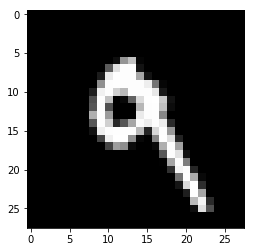

In [5]:
# Choosing a test image for the tutorial:
image = data[2][7:8]

plot.imshow(image.squeeze(), cmap='gray', interpolation='nearest')
plot.show()

In this first part we show how to create and use an analyzer. To do so we use an analyzer from *function* category, namely the gradient. The gradient shows how the linearized network function reacts on changes of a single feature.

This is simply done by passing the model without a softmax to the analyzer class:

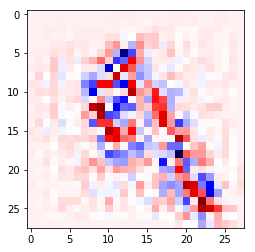

In [6]:
# Stripping the softmax activation from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

# Creating an analyzer
gradient_analyzer = innvestigate.analyzer.Gradient(model_wo_sm)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Displaying the gradient
plot.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
plot.show()

For convience there is a function that creates an analyzer for you. It passes all the parameter on to the class instantiation:

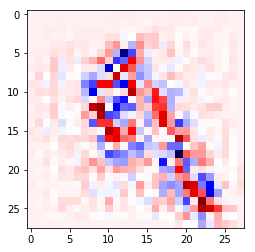

In [7]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model_wo_sm)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Displaying the gradient
plot.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
plot.show()

To emphasize different compontents of the analysis many people use instead of the "plain" gradient the absolute value or the square of it. With the gradient analyzer this can be done specifying additional parameters when creating the analyzer:

In [8]:
# Creating a parameterized analyzer
abs_gradient_analyzer = innvestigate.create_analyzer("gradient", model_wo_sm, postprocess="abs")
square_gradient_analyzer = innvestigate.create_analyzer("gradient", model_wo_sm, postprocess="square")

Similar other analyzers can be parameterized.

Now we visualize the result by projecting the gradient into a gray-color-image:

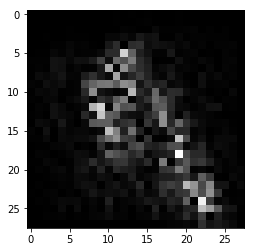

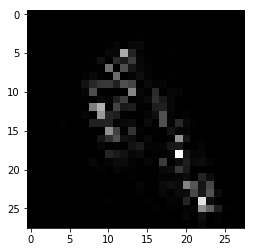

In [9]:
# Applying the analyzers
abs_analysis = abs_gradient_analyzer.analyze(image)
square_analysis = square_gradient_analyzer.analyze(image)

# Displaying the analyses, use gray map as there no negative values anymore
plot.imshow(abs_analysis.squeeze(), cmap='gray', interpolation='nearest')
plot.show()
plot.imshow(square_analysis.squeeze(), cmap='gray', interpolation='nearest')
plot.show()

## Training an analyzer

Some analyzers are data-dependent and need to be trained. In **iNNvestigate** this realized with a SKLearn-like interface. In the next piece of code we train the method PatternNet that analyzes the *signal*:

In [10]:
# Creating an analyzer
patternnet_analyzer = innvestigate.create_analyzer("pattern.net", model_wo_sm, pattern_type="relu")

# Train (or adapt) the analyzer to the training data
patternnet_analyzer.fit(data[0], verbose=True)

# Applying the analyzer
analysis = patternnet_analyzer.analyze(image)

Epoch 1/1
1875/1875 [==============================] - 23s 12ms/step - loss: 4.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000 - broadcast_3_loss: 1.0000 - broadcast_4_loss: 1.0000


And visualize it:

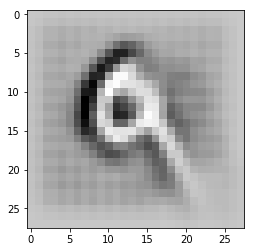

In [11]:
# Displaying the signal (projected back into input space)
plot.imshow(analysis.squeeze()/np.abs(analysis).max(), cmap="gray", interpolation="nearest")
plot.show()

## Choosing the output neuron

In the previous examples we always analyzed the output of the neuron with the highest activation. In the next one we show how one can choose the neuron to analyze:

In [12]:
# Creating an analyzer and set neuron_selection_mode to "index"
inputXgradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model_wo_sm,
                                                       neuron_selection_mode="index")

The gradient\*input analyzer is an example from the *attribution* category and we visualize it by means of a colored heatmap to highlight positive and negative attributions:

Analysis w.r.t. to neuron 0


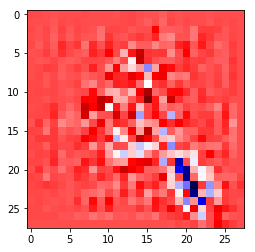

Analysis w.r.t. to neuron 1


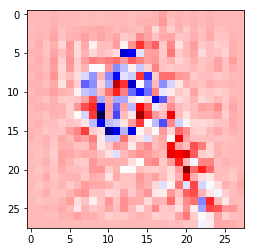

Analysis w.r.t. to neuron 2


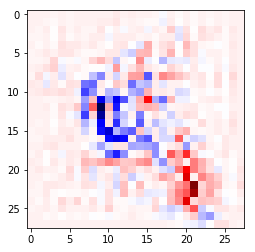

Analysis w.r.t. to neuron 3


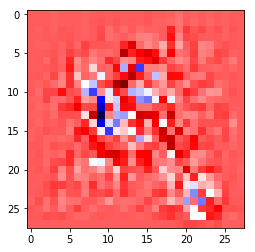

Analysis w.r.t. to neuron 4


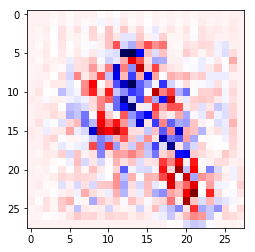

Analysis w.r.t. to neuron 5


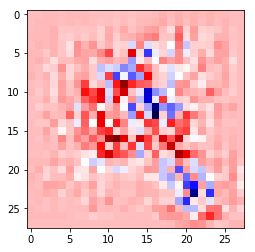

Analysis w.r.t. to neuron 6


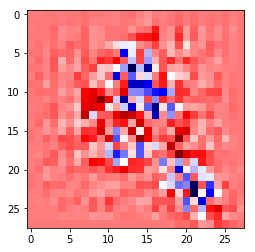

Analysis w.r.t. to neuron 7


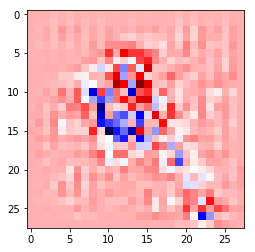

Analysis w.r.t. to neuron 8


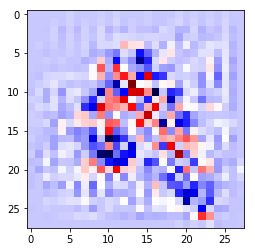

Analysis w.r.t. to neuron 9


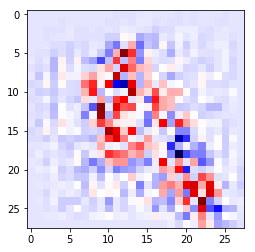

In [13]:
for neuron_index in range(10):
    print("Analysis w.r.t. to neuron", neuron_index)
    # Applying the analyzer and pass that we want 
    analysis = inputXgradient_analyzer.analyze(image, neuron_index)
    
    # Displaying the gradient
    plot.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
    plot.show()

## Additional resources

If you would like to learn more we have more notebooks for you, for example: [Comparing methods on MNIST](mnist_method_comparison.ipynb), [Comparing methods on ImageNet](imagenet_method_comparison.ipynb) and [Comparing networks on ImageNet](imagenet_network_comparison.ipynb)

If you want to know more about how to use the API of **iNNvestigate** look into: [Developing with iNNvestigate](introduction_development.ipynb)